## Load Libraries

In [1]:
from Code import *
import numpy as np
import uproot
from scipy.special import gamma
from scipy.stats import poisson
from numpy import linalg
from copy import copy, deepcopy
import math
from multiprocessing import Process, Pool, cpu_count
from functools import partial
import sys
from scipy import interpolate
import os

In [2]:
#Ensure dirs for output json files and plots exist
if not os.path.exists('fitspectra/'): os.makedirs('fitspectra/')
if not os.path.exists('plots/'): os.makedirs('plots/')
    
#Define different flux components
origins = {"pion": [211,-211], "kaon": [321,-321,310,130], "charm": [411,421,431,4122,-411,-421,-431,-4122]}
plabels = ['\pi','K','c']
basicp=[x for x in origins][0]
vpids = {12:[],14:[],16:[]}
Nptypes = len(list(origins.keys()))

detectors = ['FLARE','FASERv2','FASERv']

#Define the generators to be investigated
gens = [['SIBYLL', 'SIBYLL'],\
        ['DPMJET', 'BKRS'],\
        ['QGSJET', 'BDGJKR'],\
        ['EPOSLHC','BKSS'],\
        ['PYTHIA8','MS']]
#Gen.s in 1st col above are for light contributions, 2nd col for charm
genpars=['light', 'charm']

#Ensure proper formatting of input gens table
if np.array(gens[0]).ndim==0:
    gens = np.array([[g] for g in gens])
else:
    gens = np.array(gens)

#Numbers of independent generators in different "sectors", e.g. 0=light and 1=charm 
Ng = len(gens)  #Number of all generator (pairs)
Ngi=[]          #Number of indep. gen. per particle type
Nginames=[]     #Names of the gen. corresponding to^, helps in lambdamatrix interpretation
for isec in range(len(gens[0])):
    indeps=[]
    for g in gens[:,isec]:
        if g not in indeps:
            indeps.append(g)
    Ngi.append(len(indeps))
    Nginames.append(indeps)

#Assign numbers of gens to be used for different particle type
icharm = genpars.index('charm') if 'charm' in genpars else 0
ilight = genpars.index('light') if 'light' in genpars else 0
Ngp=[Ngi[icharm if 'charm' in p else ilight] for p in list(origins.keys())]
Ngpnames=[Nginames[icharm if 'charm' in p else ilight] for p in list(origins.keys())]

#AUX function to construct a matrix of lambdavalues to single out a given generator
def singleGenLambdaMatrix(genname):
    ret = []
    for Ngpnamesub in Ngpnames:
        if genname in Ngpnamesub:
            tmp=np.array([int(genname==name) for name in Ngpnamesub][1:])
            if sum(tmp)==0: tmp = np.multiply(-1,np.ones(len(tmp)))
        else:
            print('Generator ',genname,' not found for a particle type, returning avg. params')
            tmp = np.zeros(len(Ngpnamesub)-1)
        ret.append(tmp)
    return ret

#Default values for all lambdas -- redefining the "zero" here allows studying e.g. single-generator-centered models
lambdazeros = [np.zeros(n-1) for n in Ngp]  #All-zero lambdas
fszero = 0.0  #Likewise, possible to set enhnced strangeness parameter f_s baseline to a non-zero value

#Tags indicating the name of the code producing various plots etc.
#Due to many predictions' abbreviations starting with the same letter, we can't simply take the first letter for
#every prediction for filetagging purposes but define a few custom labels here.
codename=''
for ig in range(len(genpars))[::-1]:
    codename += '_l' if genpars[ig]=='light' else 'c'
    for g in gens[:,ig]:
        gentag=g[0]
        if 'BKSS' in g:
            gentag='A'
        elif 'BDGJKR' in g:
            gentag='Y'
        codename += gentag
fitspectratag='fitspectra/'+codename+'_'

## Energy-dependent acceptance factor for FASERv

Digitized acceptance points ($E_\nu$, acceptance), extracted from arXiv 1908.02310 [hep-ex]

In [3]:
FASERv_Enu = [28.350515463917475, 
              87.62886597938143,  
              154.63917525773172, 
              221.64948453608235, 
              296.3917525773194,  
              381.4432989690722,  
              474.2268041237113,  
              577.3195876288657,  
              688.1443298969073,  
              811.8556701030923,  
              948.4536082474224,  
              1097.9381443298967, 
              1262.886597938144,  
              1443.2989690721645, 
              1644.329896907216,  
              1863.40206185567,   
              2103.0927835051543, 
              2368.556701030928,  
              2659.793814432989,  
              2981.9587628865975]
FASERv_acc = [0.30036297640653353,
              0.5117967332123412,
              0.6225045372050824,
              0.6833030852994555,
              0.7241379310344827,
              0.7586206896551724,
              0.7831215970961886,
              0.8067150635208711,
              0.8248638838475498,
              0.8375680580762249,
              0.851179673321234,
              0.8602540834845734,
              0.8711433756805806,
              0.881125226860254,
              0.8911070780399273,
              0.8965517241379309,
              0.9019963702359346,
              0.9092558983666061,
              0.9137931034482758,
              0.9192377495462793]
ip_acc = interpolate.interp1d(FASERv_Enu, FASERv_acc, kind = 'linear', fill_value='extrapolate')

## Obtaining the Spectra from Event Files
In the following, we write a function `get_binned_spactra()` that takes the data from the event files and fills it into histograms. In particular it needs: 
- `inputs`: a set of input files
- `outputfile`: the name of the outpout file in `.csv` format stored under `fitspectra`
- `experiment`: the name of the experiment (options are defined in `code.py`)
- `ebins`: the binning in energy
- `rbins`: binning in radial position

The output file records the number of both neutrinos and neutrino interactions for different neutrino flavours, flux components, energy bins, and radial bins. 

In [4]:
def get_binned_spactra(inputs, outputfile, experiment, ebins, rbins):
        
    # initiate samples 
    samples={}
    for vpid in vpids:
        samples[vpid]={}
        for origin in origins: samples[vpid][origin]=[]
    
    # detector
    xmin = experiments[experiment]["xmin"]
    ymin = experiments[experiment]["ymin"]
    xmax = experiments[experiment]["xmax"]
    ymax = experiments[experiment]["ymax"]
    posz = experiments[experiment]["posz"]
    lumi = experiments[experiment]["lumi"]
    
    # loop through files and events
    for filename in inputs:
        events = readfile_txt(filename)
        for event in events:
            vpid, hpid, x0, y0, z0, thx, thy, en, w = event
            acc = 1.0  #Acceptance related factors to reduce statistics
            if experiment=='FASERv':
                acc=0.8  #Geometric acceptance-related factor to reduce statistics
                if   vpid==14: acc *= 0.86  #Lepton identification efficiency, assumed...
                elif vpid==16: acc *= 0.75  #...100% for electrons, less for mu, tau (individually)
                acc *= ip_acc(en) #E-dependent contribution, digitized from arXiv 1908.02310 [hep-ex]
            w *= acc
            vpid, hpid = int(vpid), int(hpid)
            x = x0 + thx*(posz-480)
            y = y0 + thy*(posz-480)
            r = np.sqrt(x**2+y**2)
            if x<xmin or x>xmax: continue
            if y<ymin or y>ymax: continue
            prob = get_interaction_probability(experiment,en,str(vpid)) 
            for origin in origins:
                if hpid in origins[origin]: samples[abs(vpid)][origin].append([en,r,w, w*prob])        
    
    # extraxt and save in pandas
    data = {}
    for vpid in vpids:
        data[vpid]={}
        for origin in origins:
            data[vpid][origin] = {}
            
            #get histogram
            sample = np.array(samples[vpid][origin])
            if len(sample)==0: 
                flux=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
                rate=np.array([[0 for _ in rbins[:-1]] for _ in ebins[:-1]])
            else: 
                flux, _, _ = np.histogram2d(sample.T[0], sample.T[1], weights=sample.T[2], bins=[ebins,rbins])
                rate, _, _ = np.histogram2d(sample.T[0], sample.T[1], weights=sample.T[3], bins=[ebins,rbins])
                
            # write to data
            data[vpid][origin]['ebins']=ebins.tolist() 
            data[vpid][origin]['rbins']=rbins.tolist() 
            data[vpid][origin]['n_nu']=(lumi*1000*flux).tolist() 
            data[vpid][origin]['n_int']=(lumi*1000*rate).tolist() 
            
    # convert to data frame and save
    save_json(fitspectratag+outputfile,data)

Let's get the spectra for the generators in the requested experiment (e.g. FLARE, FASERv2,...). We do a fit with only one radial bin, 3 radial bins and 8 radial bins:

In [5]:
#A handle to get all radN cases for one generator(pair), for multiprocessing
def get_binned_spactra_handle(igen):
    gen = gens[igen]
    fluxfiles = ['files/LHC13_'+gen[i]+'_'+genpars[i]+'_0.txt' for i in range(len(gen))]
    
    for detector in detectors:
        #Default 10 bins per decade
        ebins = np.logspace(1,4,31)
        #FLArE radial bins (default)
        rbins1 = np.array([0,2])
        rbins3 = np.array([0, 0.1, 0.25, 2])
        rbins8 = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 2])
        if   detector=='FASERv2': #.2
            rbins1 = np.array([0,0.3])
            rbins3 = np.array([0,0.1,0.2,0.3])
            rbins8 = np.array([0,0.03,0.06,0.1,0.13,0.16,0.2,0.24,0.3])
        elif detector=='FASERv':  #.125
            ebins = np.logspace(1,4,16)  #Coarser binning for FASERv, 5 bins per decade
            rbins1 = np.array([0,0.2])
            rbins3 = np.array([0,0.06,0.13,0.2])
            rbins8 = np.array([0,0.02,0.04,0.06,0.08,0.10,0.13,0.16,0.2])
        get_binned_spactra(
            outputfile = '_'.join(gen)+'_'+detector+'_rad1',
            inputs = fluxfiles,
            experiment=detector,
            ebins=ebins,
            rbins=rbins1,
        )
        get_binned_spactra(
            outputfile = '_'.join(gen)+'_'+detector+'_rad3',
            inputs = fluxfiles,
            experiment=detector,
            ebins=ebins,
            rbins=rbins3,
        )
        get_binned_spactra(
            outputfile = '_'.join(gen)+'_'+detector+'_rad8',
            inputs = fluxfiles,
            experiment=detector,
            ebins=ebins,
            rbins=rbins8,
        )    

#Fetch spectra for different generators and radial bin cases via the above handle
readprocs = Pool(processes=len(gens))  #N.B. currently assumes !(len(gens) >> ncpu)
readprocs.map(get_binned_spactra_handle, range(len(gens)))

[None, None, None, None, None]

## Defining the Model

We now define a `model()` which has model parameters corresponding to the weights of different generators when summing them up to obtain a total sample, with dedicated weights for different mesons (`lambdapi` for pions, etc). It rescales the flux components of a `baseline` model and returns the corresponding binned spectra.

With two generators, e.g. SIBYLL $S$ and DPMJET $D$, we would define the mean
$M = (S + D)/2$
and interpolate s.t. the model $m(\lambda)$ is
$m(\lambda) = M + \lambda (D - M)$
so that the parameter $\lambda$ is varied between -1 (SIBYLL) and 1 (DPMJET).
Note that this can also be written as 
$m(\lambda) = ( S(1-\lambda) + D(1+\lambda) )/2$.

To support use of $N_g > 2$ generators, $\lambda$ is replaced by a matrix, containing lists with $N_g-1$ entries for each particle type.  
The parent hadrons are divided into classes as defined in `origins` at the beginning of the code: e.g. pions ($\pi$), kaons ($K$), and charmed hadrons ($c$), each with a dedicated weight in the sum. Then with $p \in \{ \pi, K, c \}$, we employ $N_p$ predictions for the number of CC scattering events in the detector in a given energy and radial bin, $G_{n \geq 0}^{(p)}$ \Felix{Can we just write $G_i^{(p)}$?}\tm{The set notation is used for reminding the reader that $n$ starts from 0 and $i$ from 1. The sets of $G$ and $\lambda$ are not equal-sized, so we need to define different indices $n \geq 0$ and $i \geq 1$}, by introducing $N_p - 1$ nuisance parameters $\lambda_{i \geq 1}^{(p)}$ to obtain the interpolated prediction with the following expression

The above example generalizes into
\begin{equation}
m =
\sum_{p\in\{ \pi, K, c \}}
\frac{1}{N_p} \left[ G_0^{(p)} \left( 1 - \sum_{i=1}^{N_p-1} \lambda_i^{(p)}
                           \right)
                     + \sum_{i=1}^{N_p-1} G_i^{(p)}
                       \left( 1 + N_p \lambda_i^{(p)} - \sum_{j=1}^{N_p-1} \lambda_j^{(p)}
                       \right)
              \right].
\end{equation}
\end{widetext}
The model then reduces to the contribution of the $i\geq1$th prediction $G_i$ when 
$\lambda_{i} = 1,\lambda_{j\neq i} = 0$, 
while $\lambda_i = -1~\forall~i$ returns the spectrum of $G_0$. 
Setting $\lambda_i = 0~\forall~i$ yields the average of all predictions, chosen as the baseline for the discussion below. Note that such a setting is not imperative for implementing the model calculation, and choosing the baseline as a general set of parameter values is also possible by redefining the `lambdazeros` matrix (e.g. with the help of the `singleGenLambdaMatrix` function).

In [6]:
#The model expression
def modelExpr(lambdas,dataG,vpid,n2calc,orig,iorig):
    return (   (1.-sum(lambdas[orig]))\
               *np.array(dataG[0][vpid][orig][n2calc])\
             + sum( [ (1.+Ngp[iorig]*lam-sum(lambdas[orig]))\
                     *np.array(dataG[il+1][vpid][orig][n2calc])\
                     for il,lam in enumerate(lambdas[orig])])\
            ) / Ngp[iorig]

def model(detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0,\
          etau=0.0,mutau=0.0,taue=0.0,taumu=0.0,tautau=0.0,\
          E_nu_e_min=-1.0, E_nu_e_max=-1.0):
    
    #Load data
    dataG = []
    for gen in gens:
        dataG.append(load_json(fitspectratag+'_'.join(gen)+'_'+detector+radN))
    
    #Ensure no dimension mismatch
    for i,lvec in enumerate(lambdamat):
        if len(lvec)!=(Ngp[i]-1):
            print("ERROR #lambdas for particle type="+str(len(lvec))+" =/= #generators-1="+str(Ngp[i]-1))
            sys.exit()
    
    #Dictionary of flux components
    lambdas={}
    for iorig,orig in enumerate(list(origins.keys())):
        lambdas[orig] = deepcopy(lambdamat[iorig])

    #Compute number of events using model expression
    n_nu = {}
    n_int = {}
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        #Numbers per neutrino flavor and origin
        n_nu[vpid] = {}
        n_int[vpid] = {}
        for iorig,orig in enumerate(list(origins.keys())):
            n_nu[vpid][orig]  = modelExpr(lambdas,dataG,vpid,'n_nu' ,orig,iorig) 
            n_int[vpid][orig] = modelExpr(lambdas,dataG,vpid,'n_int',orig,iorig) 

    #Factors for reweighting the numbers of pions and kaons
    scalefs={}
    scalefs["pion"]  = (1.0 - (fs+fszero))
    scalefs["kaon"]  = (1.0 + (fs+fszero)*6.6)  #Approx 6.6 x more pions than kaons (pheno factor fitted by F. Kling)
    scalefs["charm"] = 1.0              
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        for orig in list(origins.keys()):
            n_nu[vpid][orig]  = np.multiply(scalefs[orig], n_nu[vpid][orig]) 
            n_int[vpid][orig] = np.multiply(scalefs[orig],n_int[vpid][orig])
    
    #Fetch numbers of neutrinos before applying any EFT factors
    NnuSM_nu={}
    NnuSM_int={}    
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        NnuSM_nu[vpid]  = sum(sum([ n_nu[vpid][orig] for orig in origins.keys()]).flatten())
        NnuSM_int[vpid] = sum(sum([n_int[vpid][orig] for orig in origins.keys()]).flatten())
    
    #Apply EFT factors if requested
    #Ntau *= (1 + 0.25*e_etau**2 + 100*e_mutau**2 + 40*e_taue**2 + 180*e_taumu**2 + 0.87*e_tautau**2)
    #Here, e_taue, e_taumu, e_tautau affect the detection side, 
    #and   e_etau, e_mutau                   at production side.
    #The operators connect to ud quark legs, so production side op.s only affect nu with pion parents.
    #The factors are originally for E-indep. change in n.o. tau evts, but we translate those E-indep. numbers 
    #into scale changes in nu_e, nu_mu spectra & propagate that shape information to the final nu_tau spectrum
    NtauAddProd = {}
    NtauAddProd['12'] =  -0.25*(etau**2) 
    NtauAddProd['14'] = -100.0*(mutau**2) 
    NtauAddProd['16'] = 0.0
    n_nu_tauAddProd = {}   #The parts of e, mu nu-spectra to be transformed into tau neutrinos
    n_int_tauAddProd = {}  #The parts of e, mu nu-interactions to be transformed into tau
    if 16 in list(vpids.keys()):
        for vpidint in list(vpids.keys()):
            vpid = str(vpidint)
            Npi_nu  = sum(sum(n_nu[ vpid]["pion"]).flatten())  #Production side operators affect only pions
            Npi_int = sum(sum(n_int[vpid]["pion"]).flatten())  #Production side operators affect only pions
            ratio_nu = 0
            ratio_int = 0
            if Npi_nu  > 0: ratio_nu  = NtauAddProd[vpid]*NnuSM_nu[ '16']/Npi_nu  #N.B. pions only in nu_e, nu_mu...
            if Npi_int > 0: ratio_int = NtauAddProd[vpid]*NnuSM_int['16']/Npi_int #...spectra in denominator
            #Compute Delta N (partial spectra) for e, mu neutrinos based on scaling down the original spectra
            n_nu_tauAddProd[ vpid] = np.multiply(n_nu[ vpid]["pion"],ratio_nu)   #N.B. these are...
            n_int_tauAddProd[vpid] = np.multiply(n_int[vpid]["pion"],ratio_int)  #...negative contributions
            #Update e, mu neutrino spectra
            n_nu[ vpid]["pion"] = np.add(n_nu[ vpid]["pion"],  n_nu_tauAddProd[vpid] )
            n_int[vpid]["pion"] = np.add(n_int[vpid]["pion"], n_int_tauAddProd[vpid] )
            #Transfer Delta N from e and tau spectrum changes to tau neutrino spectrum
            if vpid!='16':
                n_nu[ '16']["pion"] = np.add(n_nu[ '16']["pion"], np.multiply(-1.0, n_nu_tauAddProd[vpid]) )
                n_int['16']["pion"] = np.add(n_int['16']["pion"], np.multiply(-1.0,n_int_tauAddProd[vpid]) )
    
    #Fetch numbers of neutrinos after applying production side EFT factors
    NnuProd_nu={}
    NnuProd_int={}    
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        NnuProd_nu[vpid]  = sum(sum([ n_nu[vpid][orig] for orig in origins.keys()]).flatten())
        NnuProd_int[vpid] = sum(sum([n_int[vpid][orig] for orig in origins.keys()]).flatten())
        
    #Sum up different origins' contributions and apply detection side factors
    data = {}
    NtauAddDet = {}
    NtauAddDet['12'] =  -40.0*(taue**2) 
    NtauAddDet['14'] = -180.0*(taumu**2) 
    NtauAddDet['16'] =   0.87*(tautau**2)
    n_nu_tauAddDet = {}   #The parts of e, mu nu-spectra to be transformed into tau neutrinos
    n_int_tauAddDet = {}  #The parts of e, mu nu-interactions to be transformed into tau
    #(*) For reference: if tau neutrino spectrum was raised directly, indep. of E, it would look like this:
    #NtauAddDet['16'] = 0.25*(etau**2) + 100.0*(mutau**2) + 40.0*(taue**2) + 180.0*(taumu**2) + 0.87*(tautau**2)
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        data[vpid]={}
        #Store energy and radial bin info to data object
        data[vpid]['ebins'] = dataG[0][vpid][basicp]['ebins']
        data[vpid]['rbins'] = dataG[0][vpid][basicp]['rbins']
        #Form basis of spectra for data objects by summing over neutrino parent hadrons
        data[vpid]['n_nu' ] = sum(list(n_nu[ vpid].values()))
        data[vpid]['n_int'] = sum(list(n_int[vpid].values()))
        #Find EFT changes to spectra at detection side, if requested.
        #N.B. 1) This time the amount of neutrinos is unchanged, change only amount of interactions.
        #        In detection side effects a neutrino of flavor f interacts, producing a lepton of flavor f', so
        #        the amount of observed f' interactions changes, not what the initial nu distribution was.
        #     2) Now all origins contribute to denominator, evaluated after applying production side factors. 
        #        However in numerator, use original nu_tau SM spectra s.t. the numbers of (*) are reproduced. 
        if 16 in list(vpids.keys()):
            #ratio_nu = 0
            ratio_int = 0
            #if NnuProd_nu[vpid]  > 0: ratio_nu  = NtauAddDet[vpid]*NnuSM_nu[ '16']/NnuProd_nu[vpid]
            if NnuProd_int[vpid] > 0: ratio_int = NtauAddDet[vpid]*NnuSM_int['16']/NnuProd_int[vpid]
            #N.B. amounts of nu shouldn't change, only amounts of interactions
            #Compute Delta N (partial spectra) for e, mu neutrinos based on scaling down the original spectra
            #n_nu_tauAddDet[ vpid] = np.multiply(data[vpid]['n_nu' ],ratio_nu)   #N.B. these are...
            n_int_tauAddDet[vpid] = np.multiply(data[vpid]['n_int'],ratio_int)  #...negative contributions

    #Update neutrino spectra by Delta N from detection side EFT contributions
    if 16 in list(vpids.keys()):
        for vpidint in list(vpids.keys()):
            vpid=str(vpidint)
            #data[vpid]['n_nu' ] = np.add(data[vpid]['n_nu' ],  n_nu_tauAddDet[vpid] )
            data[vpid]['n_int'] = np.add(data[vpid]['n_int'], n_int_tauAddDet[vpid] )
            #Transfer Delta N from e and tau spectrum changes to tau neutrino spectrum
            if vpid!='16':
                #data['16']['n_nu' ] = np.add(data['16']['n_nu' ], np.multiply(-1.0, n_nu_tauAddDet[vpid]) )
                data['16']['n_int'] = np.add(data['16']['n_int'], np.multiply(-1.0,n_int_tauAddDet[vpid]) )
    
    #Apply factors to <in/de>crease statistics if requested
    for vpidint in list(vpids.keys()):
        vpid=str(vpidint)
        data[vpid]['n_nu' ] = np.multiply(fstat,data[vpid]['n_nu' ])
        data[vpid]['n_int'] = np.multiply(fstat,data[vpid]['n_int'])

    #If E_nu_e_max > 0 given, annul electron neutrino spectra above E_nu_e_max
    if E_nu_e_max > 0.0:
        iCutStart=0
        for eb in data['12']['ebins']:
            if eb < E_nu_e_max: iCutStart += 1
            else: break    
        data['12']['n_int'][iCutStart:] = 0.0
    #Similarly, annul electron neutrino spectra below E_nu_e_min if requested
    if E_nu_e_min > 0.0:
        iCutEnd=0
        for eb in data['12']['ebins']:
            if eb < E_nu_e_min: iCutEnd += 1
            else: break    
        data['12']['n_int'][:iCutEnd] = 0.0
    
    return data

## Fit Data

Let us denote the number of events observed in each bin as $n_i$. These are the observables in our binned histogram analysis. The likelihood function is then a product of the poisson likelihoods for all bins,

\begin{equation}
  L(\text{data}|\text{model})= \prod_{\text{bins}~i} \text{Pois}(n_i|N_i)
\end{equation}

where $N_i$ is the expected number of events per bin in the model. In the following we provide a function for the expected log-likelihood ratio $\log r$, where the likelihood ratio with respect to the is

\begin{equation}
   r(\lambda^\pi,\lambda^K,\lambda^c) = \frac{ L(\text{expected data}|\lambda^\pi,\lambda^K,\lambda^c)}{ L(\text{expected data}|\lambda^\pi=0,\lambda^K=0,\lambda^c=0)}
\end{equation}

where the expected data corresponds to $\lambda^\pi=\lambda^K=\lambda^c=0$ for generator comparisons. 

In [7]:
def get_llr(detector,radN='_rad1',lambdamat=deepcopy(lambdazeros), fstat=1.0, fs=0.0,\
            etau=0.0, mutau=0.0, taue=0.0, taumu=0.0, tautau=0.0,\
            E_nu_e_min=-1.0, E_nu_e_max=-1.0):
    
    modeldata    = model(detector=detector, radN=radN, lambdamat=deepcopy(lambdamat), fstat=fstat, fs=fs,\
                         etau=etau, mutau=mutau, taue=taue, taumu=taumu, tautau=tautau,\
                         E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max)
    expecteddata = model(detector=detector, radN=radN, lambdamat=deepcopy(lambdazeros), fstat=fstat, fs=0.0,\
                         etau=0.0,  mutau=0.0,   taue=0.0,  taumu=0.0,   tautau=0.0,\
                         E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max)

    llr = 0
    for vpid in expecteddata:
        nexpected = expecteddata[vpid]['n_int'].flatten()
        nmodel = modeldata[vpid]['n_int'].flatten()
        for k, mu in zip(nexpected,nmodel):
            #Log of probability mass function via scipy, log(r) = L - L(lambdas=0)
            kint=max(round(k),0)
            kreal=max(k,0.0)
            mureal=max(mu,0.0)
            llr+= poisson.logpmf(k=kint,mu=mureal) - poisson.logpmf(k=kint,mu=kreal)
            if np.isnan(llr):
                print('ERROR llr is nan for k='+str(k)+', round(k)='+str(round(k))+', mu='+str(mu))
                sys.exit()
    return llr

Approximate the expected likelihood ratio as

\begin{equation}
  -2\log r = - \frac{d^2 \log r}{d\lambda^{(i)} d\lambda^{(j)}} \Delta \lambda^{(i)} \Delta \lambda^{(j)}
           = I_{ij} \Delta \lambda^{(i)} \Delta \lambda^{(j)}
\end{equation}

where $i,j = \pi, K, c$. In the following, we calculate the so called Fisher Information $I_{ij}$. 
The Fisher information matrix is essentially given by the Hessian matrix, for which the element $H_{i_x,j_x}$ is computed, about the point "lambdazeros" in parameter space, as:

In [8]:
def HessianElement(ix,jx,ndim,detector,radN,fstat,usefs,\
                   useetau, usemutau, usetaue, usetaumu, usetautau,\
                   E_nu_e_min, E_nu_e_max):
    dx=0.01

    ipjp = np.zeros(ndim)
    ipjp[ix] += dx
    ipjp[jx] += dx
    ipjm = np.zeros(ndim)
    ipjm[ix] += dx
    ipjm[jx] -= dx
    imjp = np.zeros(ndim)
    imjp[ix] -= dx
    imjp[jx] += dx
    imjm = np.zeros(ndim)
    imjm[ix] -= dx
    imjm[jx] -= dx
    
    llrs=[]

    for pars in ipjp,ipjm,imjp,imjm:
        #For enhanced strangeness studies, fs parameter is the last entry in pars.
        #For EFT studies, mutau and taue arise from tau->mu & e->tau transition probabilities
        #Extract fs, and assign the rest of pars as lambdamatrix
        fs, etau, mutau, taue, taumu, tautau = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  #Defaults
              
        if usetautau:
            tautau = pars[-1]
            pars = pars[:-1]
        if usetaumu:
            taumu = pars[-1]
            pars = pars[:-1]
        if usetaue:
            taue = pars[-1]
            pars = pars[:-1]
        if usemutau:
            mutau = pars[-1]
            pars = pars[:-1]
        if useetau:
            etau = pars[-1]
            pars = pars[:-1]
        if usefs:
            fs = pars[-1]
            pars = pars[:-1]
        
        #Turn remaining input pars into properly shaped lambdamatrix and compute
        lpars = [pars[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]        

        #Add a "baseline" lambdamatrix elementwise to lpars:
        #to study cases centered around non-zero lambdas, one can simply redefine the global "lambdazeros"
        lpars = [np.add(lpars[i],lambdazeros[i]) for i in range(len(lpars))]

        llrs.append(-get_llr(detector=detector, radN=radN, lambdamat=lpars, fstat=fstat, fs=fs,\
                             etau=etau, mutau=mutau, taue=taue, taumu=taumu, tautau=tautau,\
                             E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max))

    return (llrs[0] - llrs[1] - llrs[2] + llrs[3])/(4.0*dx**2)

### The function to compute the full Fisher information matrix
Parameters
- `detector` : detector name as string, e.g. 'FASERv'
- `radN` : string indicating how many radial bins to use, e.g. '_rad3'
- `fstat` : scale the amount of statistics by this factor
- `usefs` : flag to include enhanced strangeness parameter in the fit
- `useetau,usemutau,usetaue,usetaumu,usetautau` : Flags to include NSI EFT Wilson coefficients in the fit
- `E_nu_e_min` : if positive, cut E-bins lower than this from nu_e spectra.
- `E_nu_e_max` : if positive, cut E-bins higher than this from nu_e spectra.

In [9]:
#AUX function to convert func([a1,a2,...,b,c]) to func([a1,a2,...],b,c) for multiprocessing
def funchandle(indicespercpu, ndim, detector, radN, fstat, usefs,\
               useetau, usemutau, usetaue, usetaumu, usetautau,\
               E_nu_e_min, E_nu_e_max):
    return np.array([HessianElement(indices[0], indices[1], ndim,\
                                    detector=detector, radN=radN, fstat=fstat,\
                                    usefs=usefs, useetau=useetau, usemutau=usemutau,\
                                    usetaue=usetaue, usetaumu=usetaumu, usetautau=usetautau,\
                                    E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max)\
                     for indices in indicespercpu])

def get_information(detector,radN = '_rad3',fstat=1.0,usefs=False,\
                    useetau=False,usemutau=False,usetaue=False,usetaumu=False,usetautau=False,\
                    E_nu_e_min=-1.0, E_nu_e_max=-1.0):
    ndim=sum([n-1 for n in Ngp])  #Total #[lambda param.s] =< dimensions for Hessian
    
    #Add further params to the same matrix w/ lambdas for computing the Hessian,
    if usefs:     ndim+=1
    if useetau:   ndim+=1
    if usemutau:  ndim+=1
    if usetaue:   ndim+=1
    if usetaumu:  ndim+=1
    if usetautau: ndim+=1        
    print('#dimensions = ',ndim)
    
    #Gather indices for which to compute values
    indexpairs = []
    for ix in range(ndim):
        for jx in range(ix,ndim):
            indexpairs.append([ix,jx]) 
    
    #Compute most entries in upper triangle using multiprocessing
    ncpu = cpu_count()
    ncpu = min(ncpu,len(indexpairs))
    calcspercpu = int(len(indexpairs)/ncpu)
    nextra = len(indexpairs) - ncpu*calcspercpu #How many computations performed using multiprocessing
    print('#cpu = ',ncpu,', #calculations/cpu = ',calcspercpu)
    print('Computing ',len(indexpairs)-nextra,'/',len(indexpairs),' entries using multiprocessing')
    indicespercpu = np.array([indexpairs[n*calcspercpu:(n+1)*calcspercpu] for n in range(ncpu)])
    procs = Pool(processes=ncpu)
    UT = np.array(procs.map(partial(funchandle,ndim=ndim,detector=detector,radN=radN,fstat=fstat,\
                                    usefs=usefs,useetau=useetau,usemutau=usemutau,\
                                    usetaue=usetaue,usetaumu=usetaumu,usetautau=usetautau,\
                                    E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max),\
                            indicespercpu)).flatten()
    
    #If process count was not divisible by ncpu, compute the remaining entries naively
    if nextra > 0:
        print('Computing remaining '+str(nextra)+' entries naively')
        for extra in indexpairs[ncpu*calcspercpu:]: 
            indices = deepcopy(extra)
            UT = np.append(UT,HessianElement(indices[0],indices[1],ndim,\
                                             detector=detector,radN=radN,fstat=fstat,\
                                             usefs=usefs,useetau=useetau,usemutau=usemutau,\
                                             usetaue=usetaue,usetaumu=usetaumu,usetautau=usetautau,\
                                             E_nu_e_min=E_nu_e_min, E_nu_e_max=E_nu_e_max))
    
    
    #Init return table, form upper triangle matrix out of the flat list in UT
    Hessian = np.zeros([ndim,ndim])
    Hessian[np.triu_indices(ndim, 0)] = UT
    
    #Fill lower triangle based on symmetry
    for ix in range(ndim):
        for jx in range(ix+1,ndim):
            Hessian[jx,ix] = Hessian[ix,jx]
    return Hessian

### Quick checks of flux / generator properties

Here we illustrate how the model can be used handily for checking e.g. the amount of interactions for any given generator (mix).

In [10]:
detector='FLARE'
#Let's look at the average, which is the baseline model
modelResult = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)
print('Examining model with lambdamatrix:')
print(lambdazeros)
for vpid in modelResult:
    nnus  = modelResult[vpid]['n_nu'].flatten()
    nints = modelResult[vpid]['n_int'].flatten()
    print('For nu id',vpid)
    print('  sum(n_nu)  = ',sum(nnus))
    print('  sum(n_int) = ',sum(nints))

#Let's look at some generators in isolation
genchoice='SIBYLL'
print('Examining ',genchoice,' in isolation')
modelResult = model(detector=detector,radN='_rad1',lambdamat=singleGenLambdaMatrix(genchoice),fstat=1.0,fs=0.0)
for vpid in modelResult:
    nnus  = modelResult[vpid]['n_nu'].flatten()
    nints = modelResult[vpid]['n_int'].flatten()
    print('For nu id',vpid)
    print('  sum(n_nu)  = ',sum(nnus))
    print('  sum(n_int) = ',sum(nints))
    
#Baseline result for FASERv
detector='FASERv'
modelResult = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)
print('Examining model with lambdamatrix:')
print(lambdazeros)
for vpid in modelResult:
    nnus  = modelResult[vpid]['n_nu'].flatten()
    nints = modelResult[vpid]['n_int'].flatten()
    print('For nu id',vpid)
    print('  sum(n_nu)  = ',sum(nnus))
    print('  sum(n_int) = ',sum(nints))


Examining model with lambdamatrix:
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
For nu id 12
  sum(n_nu)  =  43425069198041.55
  sum(n_int) =  52089.27883988073
For nu id 14
  sum(n_nu)  =  383787480972220.1
  sum(n_int) =  215812.52407517927
For nu id 16
  sum(n_nu)  =  1769529928795.2
  sum(n_int) =  1846.7725841590077
Examining  SIBYLL  in isolation
For nu id 12
  sum(n_nu)  =  30992858145000.15
  sum(n_int) =  33141.481886311
For nu id 14
  sum(n_nu)  =  291021882473980.9
  sum(n_int) =  183595.22568264045
For nu id 16
  sum(n_nu)  =  1441340207999.968
  sum(n_int) =  1111.9432210751659
Examining model with lambdamatrix:
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
For nu id 12
  sum(n_nu)  =  213067569142.67896
  sum(n_int) =  788.0871541982901
For nu id 14
  sum(n_nu)  =  1285204150700.1982
  sum(n_int) =  2758.62909526603
For nu id 16
  sum(n_nu)  =  5470092648.137853
  sum(n_int) =  15.612409618688693


## More Intepretation

The covariance matrix of our measurement is given by $\mathrm{Cov}_{ij}=I_{ij}^{-1}$ (that's the so called Cramer Rao bound). So we get

### Information matrix analysis for 3 radial bins

We consider FLArE the default detector for most applications, but note that info matrices must be computed separately for all considered detectors and any assumptions on the amount of collected statistics.

In [11]:
%%time
info3 = get_information(detector='FLARE',  radN = '_rad3',fstat=1.0,usefs=False)
info3_FASERv2     = get_information(detector='FASERv2',radN = '_rad3',fstat=1.0,usefs=False)
info3_FASERv2_10p = get_information(detector='FASERv2',radN = '_rad3',fstat=0.1,usefs=False) #Assume 10% statistics
info3_FASERv      = get_information(detector='FASERv', radN = '_rad3',fstat=1.0,usefs=False)

print('Fisher information (3 radial bins), FLARE')
print (np.matrix(info3))
print('Fisher information (3 radial bins), FASERv2')
print (np.matrix(info3_FASERv2))
print('Fisher information (3 radial bins), FASERv2 (10% data)')
print (np.matrix(info3_FASERv2_10p))
print('Fisher information (3 radial bins), FASERv')
print (np.matrix(info3_FASERv))

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
Fisher information (3 radial bins), FLARE
[[ 4.40927502e+02 -7.47861758e+02 -4.17927151e+02  5.16352413e+01
  -4.02159452e+02  2.31322604e+01  1.65267555e+02 -9.75673147e+01
   8.81602597e+01 -5.18331436e+02  9.94439878e+02 -1.03214612e+02]
 [-7.47861758e+02  1.64111174e+03  8.76675540e+02 -1.38271465e+02
   1.87097931e+02  3.03776894e+02  3.07810192e+01  1.56695076e+02
  -7.76192399e+01  6.16435297e+02 -1.19795766e+03  1.08561651e+

### Information matrix analysis for 1 radial bin

In [12]:
%%time
info1             = get_information(detector='FLARE',  radN = '_rad1',fstat=1.0,usefs=False)
info1_FASERv2     = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,usefs=False)
info1_FASERv2_10p = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,usefs=False)
info1_FASERv      = get_information(detector='FASERv', radN = '_rad1',fstat=1.0,usefs=False)
print('Fisher information (1 radial bin), FLARE')
print(np.matrix(info1))
print('Fisher information (1 radial bin), FASERv2')
print(np.matrix(info1_FASERv2))
print('Fisher information (1 radial bin), FASERv2 (10% data)')
print(np.matrix(info1_FASERv2_10p))
print('Fisher information (1 radial bin), FASERv')
print(np.matrix(info1_FASERv))

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
Fisher information (1 radial bin), FLARE
[[ 3.55290027e+02 -6.34324014e+02 -4.04846898e+02  4.71984261e+01
  -3.20287067e+02 -2.72843367e+01  1.04052194e+02 -9.80981616e+01
   7.17409353e+01 -4.95259024e+02  9.63851275e+02 -1.04187121e+02]
 [-6.34324014e+02  1.33843720e+03  9.18508936e+02 -4.88046968e+01
   2.13530102e+01  4.44562109e+02  1.35339531e+02  1.85536253e+02
  -5.82932242e+01  6.11971200e+02 -1.20057568e+03  1.06450436e+0

### Info matrix for 8 radial bins

In [13]:
%%time
info8             = get_information(detector='FLARE',  radN = '_rad8',fstat=1.0,usefs=False)
info8_FASERv2     = get_information(detector='FASERv2',radN = '_rad8',fstat=1.0,usefs=False)
info8_FASERv2_10p = get_information(detector='FASERv2',radN = '_rad8',fstat=0.1,usefs=False)
info8_FASERv      = get_information(detector='FASERv', radN = '_rad8',fstat=1.0,usefs=False)
print("Fisher information (8 radial bins), FLARE")
print (np.matrix(info8))
print('Fisher information (8 radial bins), FASERv2')
print(np.matrix(info8_FASERv2))
print('Fisher information (8 radial bins), FASERv2 (10% data)')
print(np.matrix(info8_FASERv2_10p))
print('Fisher information (8 radial bins), FASERv')
print(np.matrix(info8_FASERv))

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
Fisher information (8 radial bins), FLARE
[[ 5.70775589e+02 -8.21919407e+02 -4.41978705e+02  3.79455038e+01
  -4.37695032e+02  7.21887538e+01  1.56814390e+02 -9.33387090e+01
   8.35410272e+01 -5.07977584e+02  9.81263158e+02 -1.02237079e+02]
 [-8.21919407e+02  1.79169253e+03  8.53136694e+02 -1.67311254e+02
   2.00359470e+02  2.62910106e+02  1.55750148e+01  1.56006504e+02
  -7.84524919e+01  6.07769119e+02 -1.18350627e+03  1.09952258e+

### Info matrices with statistics varied up and down by a factor of 2

In [14]:
%%time
info1_05 = get_information(detector='FLARE',radN='_rad1',fstat=0.5,usefs=False)
info1_2  = get_information(detector='FLARE',radN='_rad1',fstat=2.0,usefs=False)
print("Fisher information (1 radial bin), 50% statistics")
print(np.matrix(info1_05))
print("Fisher information (1 radial bin), 200% statistics")
print(np.matrix(info1_2))

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
Fisher information (1 radial bin), 50% statistics
[[ 1.77628290e+02 -3.17140793e+02 -2.02391640e+02  2.36065346e+01
  -1.60150394e+02 -1.36327697e+01  5.20330240e+01 -4.90469950e+01
   3.58720441e+01 -2.47625045e+02  4.81912410e+02 -5.20912192e+01]
 [-3.17140793e+02  6.69187275e+02  4.59217451e+02 -2.44098957e+01
   1.06800521e+01  2.22275605e+02  6.76622152e+01  9.27675514e+01
  -2.91476896e+01  3.05980117e+02 -6.00275873e+02  5.32229954e+01]
 [-2.02391640e+02  4.59217451e+02  4.20323633e+02  2.03365582e+01
  -3.38105707e+02  3.25569418e+02  2.19351600e+02  3.87316726e+01
   3.88461006e+01 -5.47039828e+01  8.13172340e+01 -1.71573098e+01]
 [ 2.36065346e+01 -2.44098957e+01  2.03365582e+01  3.22461400e+01
  -1.

### EFT / NSI studies

In [15]:
%%time
info1_etau     = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,useetau=True)
info1_etau_10p = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,useetau=True)
print("Fisher information (1 radial bin), etau")
print (np.matrix(info1_etau))
print("Fisher information (1 radial bin), etau (10% data)")
print (np.matrix(info1_etau_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (1 radial bin), etau
[[ 1.58028747e+03 -3.22813706e+03 -1.20831130e+03  3.33082898e+02
  -5.69058679e+02 -8.65385032e+02 -2.48703582e+02 -5.16832346e+02
  -1.11843374e+02 -1.91265891e+03  4.06018506e+03 -4.12289662e+02
   0.00000000e+00]
 [-3.22813706e+03  9.14084588e+03  2.52645991e+03 -1.12863026e+03
  -3.34654650e+02  2.65862454e+03  1.43011937e+03  9.55914878e+02
   2.53099575e+02  2.66878353e+03 -5.56842659e+03  3.83725683e+02
   0.00000000e+00]
 [-1.20831130e+03  2.52645991e+03  1.84112867e+03  9.09166034e+01
  -1.85676220e+03  1.70092684e+03  1.21301344e+03  8.95439065e+01
   1.97601622e+02 -2.46909551e+02  3.07080755e+02 -1.99882492e+01
   0.00000000e+00]
 [ 3.33082898e+02 -1.1286

In [16]:
%%time
info1_mutau     = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,usemutau=True)
info1_mutau_10p = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,usemutau=True)
print("Fisher information (1 radial bin), mutau")
print (np.matrix(info1_mutau))
print("Fisher information (1 radial bin), mutau (10% data)")
print (np.matrix(info1_mutau_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (1 radial bin), mutau
[[ 1.58028747e+03 -3.22813706e+03 -1.20831130e+03  3.33082898e+02
  -5.69058679e+02 -8.65385032e+02 -2.48703582e+02 -5.16832346e+02
  -1.11843374e+02 -1.91265891e+03  4.06018506e+03 -4.12289662e+02
   0.00000000e+00]
 [-3.22813706e+03  9.14084588e+03  2.52645991e+03 -1.12863026e+03
  -3.34654650e+02  2.65862454e+03  1.43011937e+03  9.55914878e+02
   2.53099575e+02  2.66878353e+03 -5.56842659e+03  3.83725683e+02
   0.00000000e+00]
 [-1.20831130e+03  2.52645991e+03  1.84112867e+03  9.09166034e+01
  -1.85676220e+03  1.70092684e+03  1.21301344e+03  8.95439065e+01
   1.97601622e+02 -2.46909551e+02  3.07080755e+02 -1.99882492e+01
   0.00000000e+00]
 [ 3.33082898e+02 -1.128

In [17]:
%%time
info3_mutau     = get_information(detector='FASERv2',radN = '_rad3',fstat=1.0,usemutau=True)
info3_mutau_10p = get_information(detector='FASERv2',radN = '_rad3',fstat=0.1,usemutau=True)
print("Fisher information (3 radial bins), mutau")
print (np.matrix(info3_mutau))
print("Fisher information (3 radial bins), mutau (10% data)")
print (np.matrix(info3_mutau_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (3 radial bins), mutau
[[ 2.24859729e+03 -3.66921683e+03 -1.41926010e+03  2.15046611e+02
  -9.14940303e+02 -8.54225556e+02 -2.32629005e+01 -4.54233042e+02
  -8.50086531e+01 -1.88077841e+03  4.00109440e+03 -4.41622778e+02
   0.00000000e+00]
 [-3.66921683e+03  1.01434091e+04  2.51762568e+03 -1.42246826e+03
  -1.91591860e+02  2.21636516e+03  1.41978893e+03  9.52527425e+02
   1.89496024e+02  2.58746320e+03 -5.42589018e+03  4.58294111e+02
   0.00000000e+00]
 [-1.41926010e+03  2.51762568e+03  2.42448648e+03 -1.38121577e+02
  -1.74525052e+03  1.39490897e+03  1.29297564e+03  8.64132690e+01
   1.84264106e+02 -1.53328292e+02  4.36538189e+01  5.88903491e+01
   0.00000000e+00]
 [ 2.15046611e+02 -1.42

In [18]:
%%time
info1_taue     = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,usetaue=True)
info1_taue_10p = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,usetaue=True)
print("Fisher information (1 radial bin), taue")
print (np.matrix(info1_taue))
print("Fisher information (1 radial bin), taue (10% data)")
print (np.matrix(info1_taue_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (1 radial bin), taue
[[ 1.58028747e+03 -3.22813706e+03 -1.20831130e+03  3.33082898e+02
  -5.69058679e+02 -8.65385032e+02 -2.48703582e+02 -5.16832346e+02
  -1.11843374e+02 -1.91265891e+03  4.06018506e+03 -4.12289662e+02
   0.00000000e+00]
 [-3.22813706e+03  9.14084588e+03  2.52645991e+03 -1.12863026e+03
  -3.34654650e+02  2.65862454e+03  1.43011937e+03  9.55914878e+02
   2.53099575e+02  2.66878353e+03 -5.56842659e+03  3.83725683e+02
   0.00000000e+00]
 [-1.20831130e+03  2.52645991e+03  1.84112867e+03  9.09166034e+01
  -1.85676220e+03  1.70092684e+03  1.21301344e+03  8.95439065e+01
   1.97601622e+02 -2.46909551e+02  3.07080755e+02 -1.99882492e+01
   0.00000000e+00]
 [ 3.33082898e+02 -1.1286

In [19]:
%%time
info3_taue     = get_information(detector='FASERv2',radN = '_rad3',fstat=1.0,usetaue=True)
info3_taue_10p = get_information(detector='FASERv2',radN = '_rad3',fstat=0.1,usetaue=True)
print("Fisher information (3 radial bins), taue")
print (np.matrix(info3_taue))
print("Fisher information (3 radial bins), taue (10 %)")
print (np.matrix(info3_taue_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (3 radial bins), taue
[[ 2.24859729e+03 -3.66921683e+03 -1.41926010e+03  2.15046611e+02
  -9.14940303e+02 -8.54225556e+02 -2.32629005e+01 -4.54233042e+02
  -8.50086531e+01 -1.88077841e+03  4.00109440e+03 -4.41622778e+02
   0.00000000e+00]
 [-3.66921683e+03  1.01434091e+04  2.51762568e+03 -1.42246826e+03
  -1.91591860e+02  2.21636516e+03  1.41978893e+03  9.52527425e+02
   1.89496024e+02  2.58746320e+03 -5.42589018e+03  4.58294111e+02
   0.00000000e+00]
 [-1.41926010e+03  2.51762568e+03  2.42448648e+03 -1.38121577e+02
  -1.74525052e+03  1.39490897e+03  1.29297564e+03  8.64132690e+01
   1.84264106e+02 -1.53328292e+02  4.36538189e+01  5.88903491e+01
   0.00000000e+00]
 [ 2.15046611e+02 -1.422

In [20]:
%%time
info1_taumu     = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,usetaumu=True)
info1_taumu_10p = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,usetaumu=True)
print("Fisher information (1 radial bin), taumu")
print (np.matrix(info1_taumu))
print("Fisher information (1 radial bin), taumu (10% data)")
print (np.matrix(info1_taumu_10p))

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (1 radial bin), taumu
[[ 1.58028747e+03 -3.22813706e+03 -1.20831130e+03  3.33082898e+02
  -5.69058679e+02 -8.65385032e+02 -2.48703582e+02 -5.16832346e+02
  -1.11843374e+02 -1.91265891e+03  4.06018506e+03 -4.12289662e+02
   0.00000000e+00]
 [-3.22813706e+03  9.14084588e+03  2.52645991e+03 -1.12863026e+03
  -3.34654650e+02  2.65862454e+03  1.43011937e+03  9.55914878e+02
   2.53099575e+02  2.66878353e+03 -5.56842659e+03  3.83725683e+02
   0.00000000e+00]
 [-1.20831130e+03  2.52645991e+03  1.84112867e+03  9.09166034e+01
  -1.85676220e+03  1.70092684e+03  1.21301344e+03  8.95439065e+01
   1.97601622e+02 -2.46909551e+02  3.07080755e+02 -1.99882492e+01
   0.00000000e+00]
 [ 3.33082898e+02 -1.128

In [21]:
%%time
info1_mutau_taue        = get_information(detector='FASERv2',radN = '_rad1',fstat=1.0,usemutau=True,usetaue=True)
info1_mutau_taue_10p    = get_information(detector='FASERv2',radN = '_rad1',fstat=0.1,usemutau=True,usetaue=True)
info1_mutau_taue_FASERv = get_information(detector='FASERv', radN = '_rad1',fstat=1.0,usemutau=True,usetaue=True)
print("Fisher information (1 radial bin), mutau, taue (FASERv2)")
print (np.matrix(info1_mutau_taue))
print("Fisher information (1 radial bin), mutau, taue (FASERv2, 10% data)")
print (np.matrix(info1_mutau_taue_10p))
print("Fisher information (1 radial bin), mutau, taue (FASERv)")
print (np.matrix(info1_mutau_taue_FASERv))

#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
Fisher information (1 radial bin), mutau, taue (FASERv2)
[[ 1.58028747e+03 -3.22813706e+03 -1.20831130e+03  3.33082898e+02
  -5.69058679e+02 -8.65385032e+02 -2.48703582e+02 -5.16832346e+02
  -1.11843374e+02 -1.91265891e+03  4.06018506e+03 -4.12289662e+02
   0.00000000e+00  0.00000000e+00]
 [-3.22813706e+03  9.14084588e+03  2.52645991e+03 -1.12863026e+03
  -3.34654650e+02  2.65862454e+03  1.43011937e+03  9.55914878e+02
   2.53099575e+02  2.66878353e+03 -5.56842659e+03  3.83725683e+02
   0.00000000e+00  0.00000000e+00]
 [-1.20831130e+03  2.52645991e+03  1.84112867

In [22]:
%%time
info3_mutau_taue        = get_information(detector='FASERv2',radN = '_rad3',fstat=1.0,usemutau=True,usetaue=True)
info3_mutau_taue_10p    = get_information(detector='FASERv2',radN = '_rad3',fstat=0.1,usemutau=True,usetaue=True)
info3_mutau_taue_FASERv = get_information(detector='FASERv', radN = '_rad3',fstat=1.0,usemutau=True,usetaue=True)
print("Fisher information (3 radial bins), mutau, taue (FASERv2)")
print (np.matrix(info3_mutau_taue))
print("Fisher information (3 radial bins), mutau, taue (FASERv2, 10% data)")
print (np.matrix(info3_mutau_taue_10p))
print("Fisher information (3 radial bins), mutau, taue (FASERv)")
print (np.matrix(info3_mutau_taue_FASERv))

#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
#dimensions =  14
#cpu =  8 , #calculations/cpu =  13
Computing  104 / 105  entries using multiprocessing
Computing remaining 1 entries naively
Fisher information (3 radial bins), mutau, taue (FASERv2)
[[ 2.24859729e+03 -3.66921683e+03 -1.41926010e+03  2.15046611e+02
  -9.14940303e+02 -8.54225556e+02 -2.32629005e+01 -4.54233042e+02
  -8.50086531e+01 -1.88077841e+03  4.00109440e+03 -4.41622778e+02
   0.00000000e+00  0.00000000e+00]
 [-3.66921683e+03  1.01434091e+04  2.51762568e+03 -1.42246826e+03
  -1.91591860e+02  2.21636516e+03  1.41978893e+03  9.52527425e+02
   1.89496024e+02  2.58746320e+03 -5.42589018e+03  4.58294111e+02
   0.00000000e+00  0.00000000e+00]
 [-1.41926010e+03  2.51762568e+03  2.4244864

### Profiling

Profile over the i_nuis:th parameter in info, which has the dimensions $NxN$, with 
$N = (N_g^{\rm light} \times N_{\rm ptypes}^{\rm light} + N_g^{\rm charm} \times N_{\rm ptypes}^{\rm charm})$.

Returns a $(N-1) \times (N-1)$ matrix.
Note that profiling over several parameters can be done by repeatedly applying this function on the returned matrix.


In [23]:
def profile(info, i_nuis):
    #info theory
    info_th = np.delete(info, i_nuis, 0)
    info_th = np.delete(info_th, i_nuis, 1)
    # info mix 
    info_mix = info[i_nuis]
    info_mix = np.delete(info_mix, i_nuis, 0)
    # info nuis
    info_nuis = info[i_nuis][i_nuis]
    # profiled info 
    return info_th - np.outer(info_mix,info_mix)/float(info_nuis)

## EFT studies: profiling

### mutau

In [24]:
infomat=info3_mutau
radNstr='_rad3'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entries in info matrix correspond to EFT params.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

print('infoprof')
print(infoprof)
print('infopart')
print(infopart)

mutau3constraint=1.0/np.sqrt(infoprof[0][0])
print('3 R bins: mutau constrained (1 sigma) to ',mutau3constraint)

Eigenvalue  568687.6818027225
[ 1.06074272e-05 -1.44236907e-05  1.94468246e-07  3.92333151e-06
 -5.31007493e-05 -4.62738736e-05  2.73329369e-05 -3.05535524e-05
 -7.11729286e-05 -4.89127243e-04  1.20654889e-03 -2.26683908e-04
  0.00000000e+00]
Eigenvalue  34953.55856240576
[ 2.60895891e-05 -4.09350893e-04 -4.41187103e-04 -3.05766075e-04
  3.99674110e-03 -2.80115024e-03 -1.65294925e-03 -2.15540645e-04
 -9.07412770e-04  6.36970574e-04  2.00894747e-04 -5.33322935e-04
  0.00000000e+00]
Eigenvalue  13289.54243868184
[-0.00283305  0.00698361  0.00204803 -0.00098956  0.00172091  0.00082425
  0.00218226 -0.00014384 -0.00100095  0.00118037  0.00029578 -0.0015395
  0.        ]
Eigenvalue  10540.363506531086
[-0.00120035  0.00235041  0.00033206 -0.00040296 -0.00050162  0.00193313
 -0.00734169  0.00495349  0.0011475  -0.00136029  0.00016662  0.00141931
  0.        ]
Eigenvalue  6484.888962812606
[-0.00027272 -0.00156486 -0.00077884  0.0016106   0.00500157  0.00921785
 -0.00238327 -0.00552948  0.000

### taue

In [25]:
infomat=info3_taue
radNstr='_rad3'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entries in info matrix correspond to EFT params.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart  = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

print('infoprof')
print(infoprof)
print('infopart')
print(infopart)

taue3constraint=1.0/np.sqrt(infoprof[0][0])
print('3 R bins: taue constrained (1 sigma) to ',taue3constraint)

Eigenvalue  568687.6818027225
[ 1.06074272e-05 -1.44236907e-05  1.94468246e-07  3.92333151e-06
 -5.31007493e-05 -4.62738736e-05  2.73329369e-05 -3.05535524e-05
 -7.11729286e-05 -4.89127243e-04  1.20654889e-03 -2.26683908e-04
  0.00000000e+00]
Eigenvalue  34953.55856240576
[ 2.60895891e-05 -4.09350893e-04 -4.41187103e-04 -3.05766075e-04
  3.99674110e-03 -2.80115024e-03 -1.65294925e-03 -2.15540645e-04
 -9.07412770e-04  6.36970574e-04  2.00894747e-04 -5.33322935e-04
  0.00000000e+00]
Eigenvalue  13289.54243868184
[-0.00283305  0.00698361  0.00204803 -0.00098956  0.00172091  0.00082425
  0.00218226 -0.00014384 -0.00100095  0.00118037  0.00029578 -0.0015395
  0.        ]
Eigenvalue  10540.363506531086
[-0.00120035  0.00235041  0.00033206 -0.00040296 -0.00050162  0.00193313
 -0.00734169  0.00495349  0.0011475  -0.00136029  0.00016662  0.00141931
  0.        ]
Eigenvalue  6484.888962812606
[-0.00027272 -0.00156486 -0.00077884  0.0016106   0.00500157  0.00921785
 -0.00238327 -0.00552948  0.000

### NSI ellipsoid for 3 radial bins, using mutau & taue

The epsilon constraints at sigmas=1.645 are:
[0.0057, 0.026]
The $\Lambda$ constraints at sigmas=1.645 are [TeV]:
[0.9, 0.6]
infoprof
[[822.42959753   0.        ]
 [  0.          42.93532095]]
infopart
[[822.42959753   0.        ]
 [  0.          42.93532095]]
Eigenvalue  822.4295975284573
[0.03486989 0.        ]
Eigenvalue  42.93532095327534
[0.         0.15261339]
infoprof
[[11405.75809771     0.        ]
 [    0.           649.14703359]]
infopart
[[11405.75809771     0.        ]
 [    0.           649.14703359]]
Eigenvalue  11405.758097714204
[0.00936349 0.        ]
Eigenvalue  649.1470335948214
[0.         0.03924899]
infoprof
[[84400.11030145     0.        ]
 [    0.          4002.31449748]]
infopart
[[84400.11030145     0.        ]
 [    0.          4002.31449748]]
Eigenvalue  84400.1103014469
[0.00344214 0.        ]
Eigenvalue  4002.3144974787215
[0.         0.01580682]
Saved plots/cSBYAM_lSDQEP_prof_mutau_taue_only_experiments_rad3.pdf


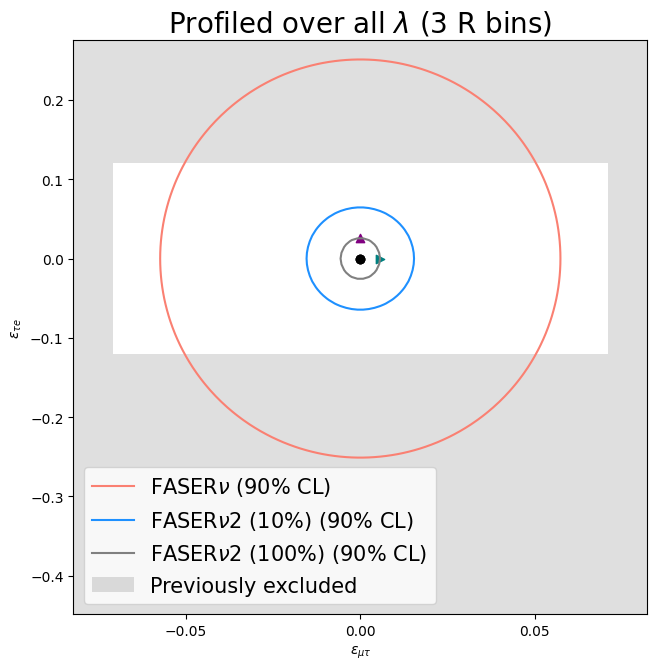

N.B. constraints from profiling over everything except a single parameteragree w/ eigenvector locations to a good approximation:
taue3constraint  =  0.015806815857746823
mutau3constraint =  0.0034421397048607356


In [26]:
radNstr='_rad3'
sigmas=1.645
infomats = [info3_mutau_taue_FASERv,\
            info3_mutau_taue_10p,\
            info3_mutau_taue]
colors   = ['salmon'     ,'dodgerblue'         ,'gray'                ]
tags     = [r'FASER$\nu$',r'FASER$\nu$2 (10%)',r'FASER$\nu$2 (100%)']

NSIlbl   = [r'$\epsilon_{\mu\tau}$', r'$\epsilon_{\tau e}$']
evcolors = ['teal'                 ,'purple'               ]
markers=[">","^"]

constraints = [round(sigmas*x*1e4)/1e4 for x in [mutau3constraint,taue3constraint]] #Higgs vev = 0.246 TeV
print('The epsilon constraints at sigmas='+str(sigmas)+' are:')
print(constraints)
Lambdaconstraints = [round((246.0/(sigmas*x)**0.25/100.0))/10.0 for x in [mutau3constraint,taue3constraint]] #Higgs vev = 0.246 TeV
print('The $\Lambda$ constraints at sigmas='+str(sigmas)+' are [TeV]:')
print(Lambdaconstraints)

fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.17, 0.12, 0.82, 0.82], )
#ax = plt.subplot(1,1,1)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'legend.fontsize': 15})
matplotlib.rcParams.update({'axes.labelsize': 'x-large'})
matplotlib.rcParams.update({'axes.titlesize': 20})
matplotlib.rcParams.update({'legend.loc':'lower left'})
matplotlib.rcParams.update({'xtick.labelsize': 15})
matplotlib.rcParams.update({'ytick.labelsize': 15})

for idet,infomat in enumerate(infomats):
    
    #Profile all lambda parameters, one at a time. The last entries in info matrix correspond to EFT/NSI params.
    #N.B. Here we have no EFT/NSI parameters to be profiled over, unlike in the above code block.
    #Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
    infoprof = deepcopy(infomat)
    infopart = deepcopy(infomat)
    for i in range(len(infomat)-2):  #Profile all lambdas, leave mutau, taue
        infoprof = profile(infoprof, 0)
        infopart = dimDel( infopart, 0)
        
        
    print('infoprof')
    print(infoprof)
    print('infopart')
    print(infopart)
    
    #Check eigenvectors v & -values w AFTER profiling
    w, v = linalg.eig(infoprof)
    for value,vector in zip(w, v.T):
        print('Eigenvalue ',value)
        print(vector/np.sqrt(value))
    
    #Define grids for plotting:
    #-2 first args based on plot limits;
    #-Last arg (#points) chosen conveniently, no dependency on number of generators or particle types
    lvals1 = np.linspace(-sigmas*0.05, sigmas*0.05, 102)
    lvals2 = np.linspace(-sigmas*0.22, sigmas*0.22, 101)
    lgrid1, lgrid2 = np.meshgrid(lvals1, lvals2)
    
    #Form arrays of llr values to be plotted according to the lvals grids
    llr_vals_profiled = np.array([[np.dot([l1,l2],np.dot(infoprof,[l1,l2])) for l2 in lvals2] for l1 in lvals1])
    llr_vals_info     = np.array([[np.dot([l1,l2],np.dot(infopart, [l1,l2])) for l2 in lvals2] for l1 in lvals1])
    
    #Plot
    ax.contour(lgrid1, lgrid2, llr_vals_profiled.T, colors=colors[idet],levels=[sigmas**2]) #levels=[1,4,9])
    #Instead of contours, simply print llr_vals_contents for unit test output here
    plotTest(llr_vals_profiled.T,\
             testsubdir = 'flux-fit-main',\
             testtag    = 'mutau_taue_constr_llr_vals_profiled_'+str(idet))
    ax.plot([0],[0],color=colors[idet], label=tags[idet]+r' (90% CL)')
    ax.scatter(0, 0, c="k")  #Center dot
    iev=0
    for wi,vi in zip(w,v.T): 
        if idet==2:
            evx = sigmas*vi[0]/np.sqrt(wi)
            evy = sigmas*vi[1]/np.sqrt(wi)
            ax.scatter(evx, evy, color=evcolors[iev], marker=markers[iev])
            iev+=1

#Plot bars for previous constraints:
#|mutau| < 0.071, |taue| < 0.12
previousConstraints=[0.071, 0.12]
ax.barh(y=-1.0,\
        width=1.0,\
        left=previousConstraints[0],\
        align='edge',\
        height=2.0, color='gray',\
        alpha=0.25, zorder=-1)
ax.barh(y=-1.0,\
        width=1.0-previousConstraints[0],\
        left=-1,\
        align='edge',\
        height=2.0, color='gray',\
        alpha=0.25, zorder=-1)
ax.barh(y=previousConstraints[1],\
        width=2.0*previousConstraints[0],\
        left=-previousConstraints[0],\
        align='edge',\
        height=1.0, color='gray',\
        alpha=0.25, zorder=-1)
ax.bar(x=-previousConstraints[0],\
       height=1.0-previousConstraints[1],\
       bottom=-1.0,\
       align='edge',\
       width=2.0*previousConstraints[0], color='gray',\
       alpha=0.25, zorder=-1, label='Previously excluded')

#Plot setup
xshift = -0.0*(lvals1[-1] - lvals1[0])
yshift = -0.12*(lvals2[-1] - lvals2[0])
ax.set_xlim(lvals1[0] + xshift, lvals1[-1] + xshift)
ax.set_ylim(lvals2[0] + yshift, lvals2[-1] + yshift)
plt.locator_params(axis='x', nbins=6)
RbinStr = radNstr[-1]+' R bin'
if radNstr[-1]!='1': RbinStr+='s'
ax.set_title(r'Profiled over all $\lambda$ ('+RbinStr+')')    
ax.set_xlabel(NSIlbl[0])
ax.set_ylabel(NSIlbl[1])
matplotlib.rcParams.update({'legend.loc':'lower left'})
ax.legend(frameon=True)

#Save plot
plotname='plots/'+codename+'_prof_mutau_taue_only_experiments'+radNstr+'.pdf'
plt.savefig(plotname)
print('Saved '+plotname)
plt.show()

print('N.B. constraints from profiling over everything except a single parameter'+\
      'agree w/ eigenvector locations to a good approximation:')
print('taue3constraint  = ',taue3constraint)
print('mutau3constraint = ',mutau3constraint)

### Plot all radial bins separately in rad3 case

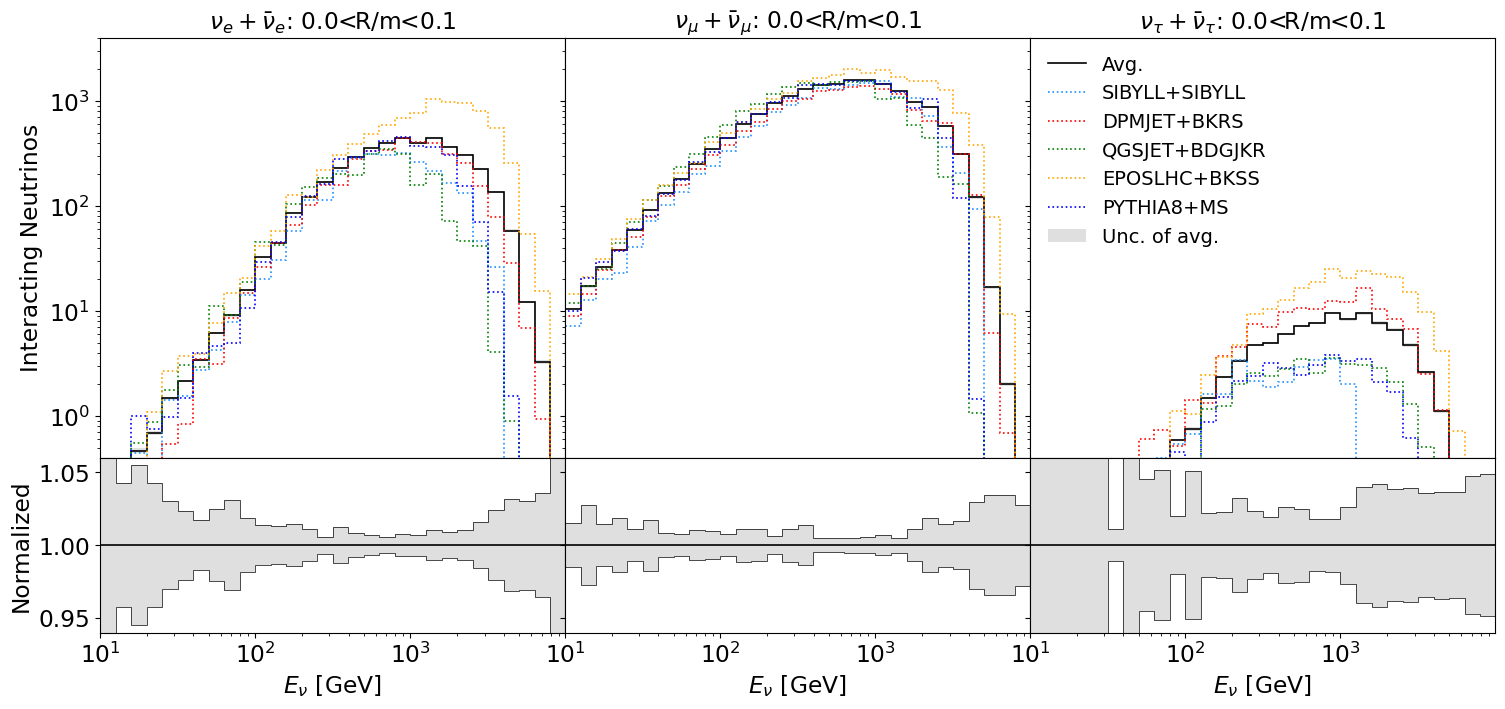

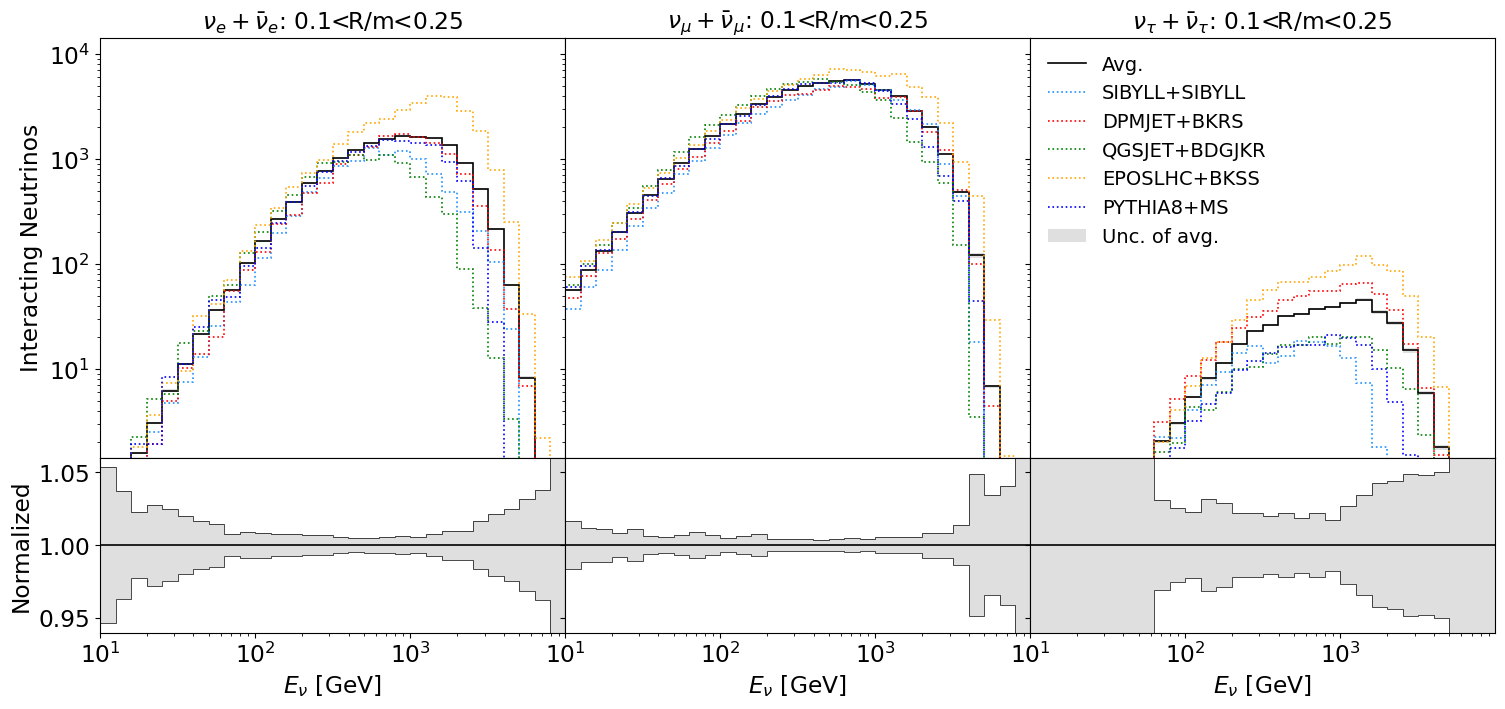

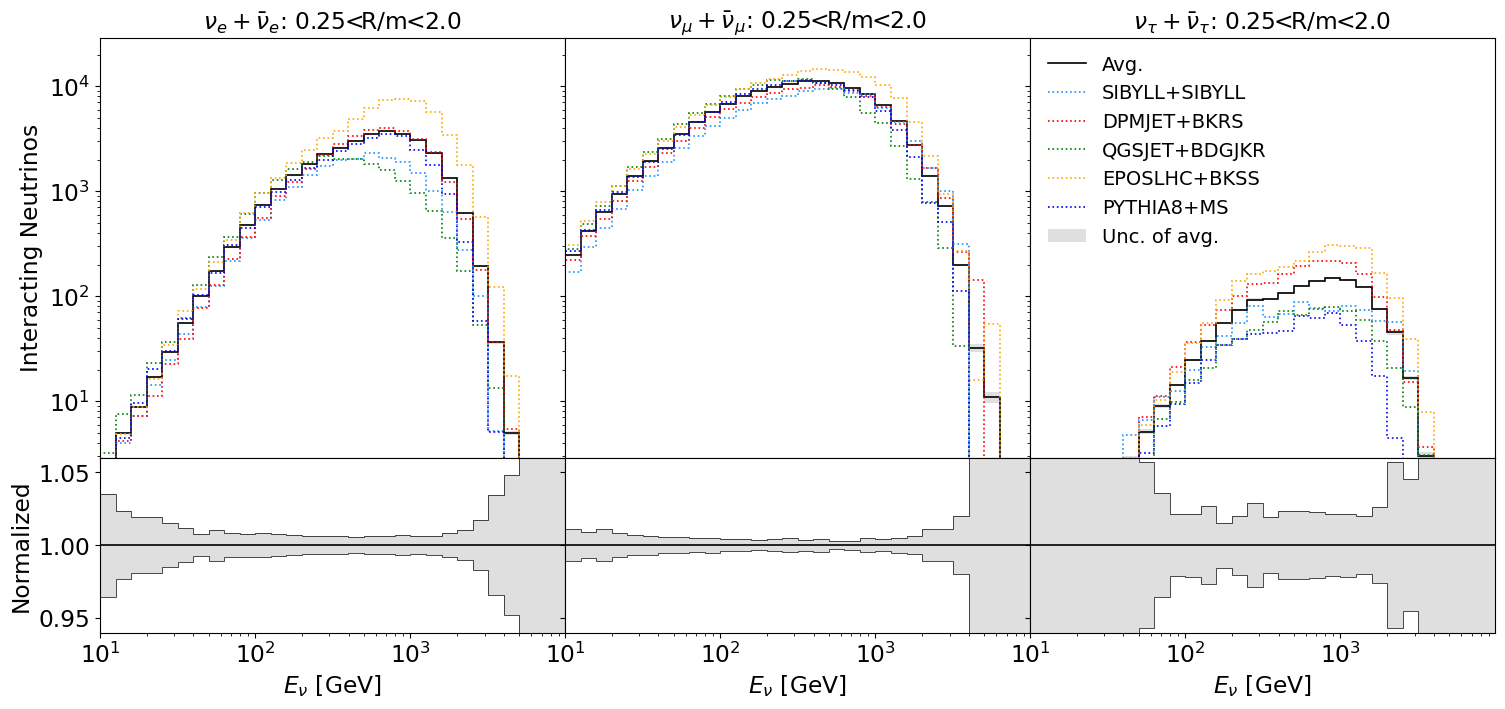

In [27]:
detector='FLARE'

for rbin in [0,1,2]:

    filename='plots/'+codename+'_rbin'+str(rbin)+'.pdf'
    vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]
    
    #setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'legend.fontsize': 'medium'})
    matplotlib.rcParams.update({'axes.labelsize': 'large'})
    matplotlib.rcParams.update({'axes.titlesize':'large'})
    matplotlib.rcParams.update({'xtick.labelsize':'large'})
    matplotlib.rcParams.update({'ytick.labelsize':'large'})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(15,7))
    ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
    ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
    ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
    ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
    ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
    ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
    axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])
    
    #Extract information from baseline
    baseline = model(detector=detector,radN='_rad3',lambdamat=deepcopy(lambdazeros),fs=0.0)    
    ebins = np.array(baseline["12"]['ebins'])
    ecenters = (ebins[1:]+ebins[:-1])/2
    rbins = np.array(baseline["12"]['rbins'])
    rmin, rmax = rbins[rbin], rbins[rbin+1] 
    base_entries={}
    nmax = 1
    for ivpid,vpid in enumerate(vpidstrs):
        entries = np.array(baseline[vpid]['n_int']).T[rbin]
        base_entries[vpid]=entries
        if max(entries)>nmax: nmax=max(entries)
        plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries, bins=ebins, histtype='step', color='black',\
                                    ls='solid', lw=1.2),\
                 testsubdir = 'flux-fit-main',\
                 testtag = 'FLARE_baseline_rad3_r'+str(rbin)+'_'+str(vpid),\
                 mode = 'histo')
        axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)
        axes[0,ivpid].plot(-1,1, color='black', ls='solid', lw=1.2,label='Avg.')                

    #Plot uncertainty
    values, vectors = linalg.eig(info3)
    for ivpid,vpid in enumerate(vpidstrs):
        base_entry = base_entries[vpid]
        uncertainty=base_entry-base_entry
        for value,vector in zip(values, vectors.T):
            point=vector/np.sqrt(value)
            lambdavars = [point[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavars = [np.add(lambdavars[i],lambdazeros[i]) for i in range(len(lambdavars))]
            varied = model(detector=detector,radN='_rad3', lambdamat=lambdavars)
            entry = np.array(varied[vpid]['n_int']).T[rbin]
            uncertainty += (entry - base_entry)**2
        uncertainty = np.sqrt(uncertainty)
        wgtp = 1+uncertainty/base_entry
        plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp,bins=ebins,\
                                    histtype='step',color='black',ls='solid',lw=0.5),\
                 testsubdir = 'flux-fit-main',\
                 testtag = 'FLARE_unc_rad3_r'+str(rbin)+'_'+str(vpid)+'_wgtp',\
                 mode = 'histo')
        wgtm = 1-uncertainty/base_entry        
        plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm,bins=ebins,\
                                    histtype='step',color='black',ls='solid',lw=0.5),\
                 testsubdir = 'flux-fit-main',\
                 testtag = 'FLARE_unc_rad3_r'+str(rbin)+'_'+str(vpid)+'_wgtm',\
                 mode = 'histo')        
        errhi=np.multiply(wgtp,base_entry)
        errlo=np.multiply(wgtm,base_entry)
        axes[0,ivpid].bar(x=ebins[:-1],\
                          height=np.add(errhi,np.multiply(-1,errlo)),\
                          bottom=errlo,\
                          width=np.diff(ebins),\
                          align='edge', linewidth=0, color='gray',\
                          alpha=0.25, zorder=-1, label='Unc. of avg.')
        axes[1,ivpid].bar(x=ebins[:-1],\
                          height=np.add(wgtp,np.multiply(-1,wgtm)),\
                          bottom=wgtm,\
                          width=np.diff(ebins),\
                          align='edge', linewidth=0, color='gray',\
                          alpha=0.25, zorder=-1, label='Unc. of avg.')
        
    #Plot individual generators -- The ordering is s.t.
    #  0th gen (e.g. SIBYLL) is obtained w/ all -1
    #  1st gen (e.g. DMPJET) w/ 1st lambda=1, others 0
    #  2nd gen w/ 2nd lambda=1, others 0
    #  3rd gen w/ 3rd lambda=1, others 0
    lambdagens=[] #lambdagens[i] will contain the lambdamatrix for retrieving only the ith generator
    #0th gen special case 
    lambdagens.append([np.multiply(-1.,np.ones(n-1)) for n in Ngp])
    #Init i>0 cases to all-0 baseline. N.B. #cases depends on total #[generator pairs]=Ng,...
    for i in range(Ng-1):  #...hence Ng-1 does NOT refer to particle type specific #lambdas here
        lambdagens.append(deepcopy(lambdazeros))
    #Set the relevant element of each i>0 case lambdamatrix to 1 to pick a single generator
    for j in range(Nptypes):
        for i in range(Ngp[j]-1):
            lambdagens[i+1][j][i] = 1

    #Store the "model" objects corresponding to above generator-specific lambdamatrices
    genmodels=[]
    for lgenspec in lambdagens:
        genmodels.append(model(detector=detector,radN='_rad3', lambdamat=lgenspec))
    
    #Fetch model result projection for this rbin, store different nu flavor contributions to "entries"
    entries=[]
    colors=['dodgerblue','red','green','orange','blue']
    nmax = 1  #tmp init
    for ivpid,vpid in enumerate(vpidstrs):  #Handle & plot
        for igm,genmodel in enumerate(genmodels):
            entries.append(np.array(genmodel[vpid]['n_int']).T[rbin])
            if max(entries[-1])>nmax: nmax=max(entries[-1])
            #Plot histos for this nu flavor
            plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries[-1], bins=ebins,\
                                        histtype='step', color=colors[igm], ls='dotted', lw=1.2),\
                     testsubdir = 'flux-fit-main',\
                     testtag = 'FLARE_rad3_r'+str(rbin)+'_'+str(vpid)+'_'+str(igm),\
                     mode = 'histo')
            axes[0,ivpid].plot(-1,1, color=colors[igm], ls='dotted', lw=1.2,label='+'.join(gens[igm]))        
        
    #Plotstyle setup
    vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
    for ivpid,vpid in enumerate(vpidstrs):
        axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
        if ivpid==0: axes[0,ivpid].set_ylabel("Interacting Neutrinos")
        if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
        axes[0,ivpid].set_xscale("log")
        axes[1,ivpid].set_xscale("log")
        axes[0,ivpid].set_yscale("log")
        axes[1,ivpid].set_yscale("linear")
        axes[0,ivpid].set_xlim(10,9900)
        axes[1,ivpid].set_xlim(10,9900)
        axes[0,ivpid].set_ylim(nmax*2/1.e4,nmax*2)
        axes[1,ivpid].set_ylim(0.94,1.06)
        axes[0,ivpid].set_xticklabels([])
        if ivpid>0: axes[0,ivpid].set_yticklabels([])
        if ivpid>0: axes[1,ivpid].set_yticklabels([])
        axes[0,ivpid].set_title(vpidlabels[vpid]+": "+str(rmin)+"<R/m<"+str(rmax))
    matplotlib.rcParams.update({'legend.loc':'upper left'})
    axes[0,2].legend(frameon=False)

    #finalize figure
    if filename is not None: plt.savefig(filename)

    plt.show()

### Plot spectra for 1 radial bin, vary statistics up and down

Saved  plots/cSBYAM_lSDQEP_1_radial_bin.pdf


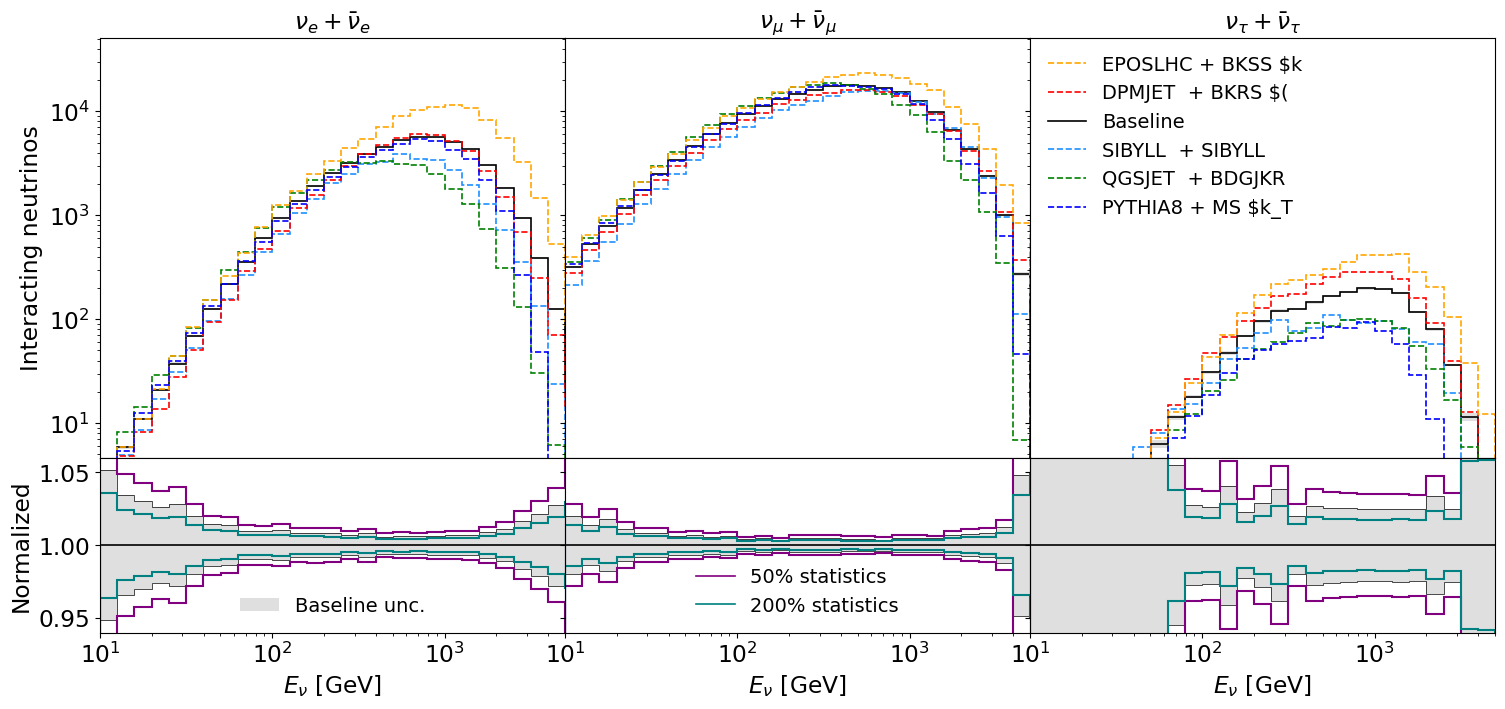

In [28]:
detector='FLARE'

filename='plots/'+codename+'_1_radial_bin.pdf'
vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]

#Setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'medium'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(15,7))
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

col1 ='black'
col05='purple'
col2 ='teal'

#Extract information from baseline
baseline1    = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros))    
baseline1_05 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=0.5)    
baseline1_2  = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=2.0)    
ebins = np.array(baseline1["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
base_entries1    = {}
base_entries1_05 = {}
base_entries1_2  = {}
nmax = 1
for ivpid,vpid in enumerate(vpidstrs):
    entries1    = np.array(baseline1[   vpid]['n_int']).T[0]
    entries1_05 = np.array(baseline1_05[vpid]['n_int']).T[0]
    entries1_2  = np.array(baseline1_2[ vpid]['n_int']).T[0]
    base_entries1[   vpid] = entries1
    base_entries1_05[vpid] = entries1_05
    base_entries1_2[ vpid] = entries1_2
    if max(entries1)>nmax: nmax=max(entries1)
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1, bins=ebins,\
                                histtype='step', color='black', ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_baseline_rad1_'+str(vpid),\
             mode = 'histo')
    axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)

#Plot uncertainty
values1,    vectors1    = linalg.eig(info1)
values1_05, vectors1_05 = linalg.eig(info1_05)
values1_2,  vectors1_2  = linalg.eig(info1_2)
for ivpid,vpid in enumerate(vpidstrs):
    #Central
    base_entry1 = base_entries1[vpid]
    uncertainty1 = base_entry1 - base_entry1
    for value1,vector1 in zip(values1, vectors1.T):
        point1        = vector1/np.sqrt(value1)
        lambdavars1   = [point1[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1   = [np.add(lambdavars1[i],lambdazeros[i]) for i in range(len(lambdavars1))]
        varied1       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1)
        entry1        = np.array(varied1[vpid]['n_int']).T[0]
        uncertainty1 += (entry1 - base_entry1)**2
    uncertainty1 = np.sqrt(uncertainty1)
    wgtp1 = 1 + uncertainty1/base_entry1
    wgtm1    = 1 -    uncertainty1/base_entry1
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1,bins=ebins,histtype='step',color=col1,ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_rad1_'+str(vpid)+'_wgtp1',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1,bins=ebins,histtype='step',color=col1,ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_rad1_'+str(vpid)+'_wgtm1',\
             mode = 'histo')
    errhi1    = np.multiply(wgtp1,base_entry1)
    errlo1    = np.multiply(wgtm1,base_entry1)
    axes[0,ivpid].bar(x=ebins[:-1],\
                      height=np.add(errhi1,np.multiply(-1,errlo1)),\
                      bottom=errlo1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    axes[1,ivpid].bar(x=ebins[:-1],\
                      height=np.add(wgtp1,np.multiply(-1,wgtm1)),\
                      bottom=wgtm1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    #50% statistics
    base_entry1_05 = base_entries1_05[vpid]
    uncertainty1_05 = base_entry1_05 - base_entry1_05
    for value1_05,vector1_05 in zip(values1_05, vectors1_05.T):
        point1_05        = vector1_05/np.sqrt(value1_05)
        lambdavars1_05   = [point1_05[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1_05   = [np.add(lambdavars1_05[i],lambdazeros[i]) for i in range(len(lambdavars1_05))]
        varied1_05       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1_05,fstat=0.5)
        entry1_05        = np.array(varied1_05[vpid]['n_int']).T[0]
        uncertainty1_05 += (entry1_05 - base_entry1_05)**2
    uncertainty1_05 = np.sqrt(uncertainty1_05)
    wgtp1_05 = 1 + uncertainty1_05/base_entry1_05
    wgtm1_05 = 1 - uncertainty1_05/base_entry1_05    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1_05,bins=ebins,\
                                histtype='step',color=col05, ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_05_rad1_'+str(vpid)+'_wgtp1_05',\
             mode = 'histo')    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1_05,bins=ebins,\
                                histtype='step',color=col05, ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_05_rad1_'+str(vpid)+'_wgtm1_05',\
             mode = 'histo')
    errhi1_05 = np.multiply(wgtp1_05,base_entry1_05)
    errlo1_05 = np.multiply(wgtm1_05,base_entry1_05)
    #200% statistics
    base_entry1_2 = base_entries1_2[ vpid]
    uncertainty1_2 = base_entry1_2 - base_entry1_2
    for value1_2,vector1_2 in zip(values1_2, vectors1_2.T):
        point1_2         = vector1_2/np.sqrt(value1_2)
        lambdavars1_2    = [point1_2[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1_2    = [np.add(lambdavars1_2[i],lambdazeros[i]) for i in range(len(lambdavars1_2))]
        varied1_2        = model(detector=detector,radN='_rad1',lambdamat=lambdavars1_2,fstat=2.0)
        entry1_2         = np.array(varied1_2[vpid]['n_int']).T[0]
        uncertainty1_2  += (entry1_2  - base_entry1_2 )**2
    uncertainty1_2  = np.sqrt(uncertainty1_2)
    wgtp1_2  = 1 +  uncertainty1_2/base_entry1_2
    wgtm1_2  = 1 -  uncertainty1_2/base_entry1_2    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1_2,bins=ebins,\
                                histtype='step',color=col2,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_2_rad1_'+str(vpid)+'_wgtp1_2',\
             mode = 'histo')    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1_2,bins=ebins,\
                                histtype='step',color=col2,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_unc_2_rad1_'+str(vpid)+'_wgtm1_2',\
             mode = 'histo')
    errhi1_2  = np.multiply(wgtp1_2, base_entry1_2)
    errlo1_2  = np.multiply(wgtm1_2, base_entry1_2)

lgdnames = gens.copy()  #Rewrite generator names in form suitable for legend
for genset in lgdnames:
    for ig in range(len(genset)):
        if   genset[ig]=='BKSS': genset[ig]='BKSS $k_T$'
        elif genset[ig]=='MS':   genset[ig]='MS $k_T$'
    genset[0] += ' $(\pi, K)$'
    genset[1] += ' $(c)$'
    
#Plot individual generators -- The ordering is s.t.
#  0th gen (e.g. SIBYLL) is obtained w/ all -1
#  1st gen (e.g. DMPJET) w/ 1st lambda=1, others 0
#  2nd gen w/ 2nd lambda=1, others 0
#  3rd gen w/ 3rd lambda=1, others 0
lambdagens1=[] #lambdagens[i] will contain the lambdamatrix for retrieving only the ith generator
#0th gen special case 
lambdagens1.append([np.multiply(-1.,np.ones(n-1)) for n in Ngp])
#Init i>0 cases to all-0 baseline. N.B. #cases depends on total #[generator pairs]=Ng,...
for i in range(Ng-1):  #...hence Ng-1 does NOT refer to particle type specific #lambdas here
    lambdagens1.append(deepcopy(lambdazeros))
#Set the relevant element of each i>0 case lambdamatrix to 1 to pick a single generator
for j in range(Nptypes):
    for i in range(Ngp[j]-1):
        lambdagens1[i+1][j][i] = 1
#Store the "model" objects corresponding to above generator-specific lambdamatrices
genmodels1=[]
for lgenspec in lambdagens1:
    genmodels1.append(model(detector=detector,radN='_rad1',lambdamat=lgenspec))
#Fetch model result projection, store different nu flavor contributions to "entries"
entries1=[]
colors=['dodgerblue','red','green','orange','blue']
nmax = 1  #tmp init
for ivpid,vpid in enumerate(vpidstrs):  #Handle & plot
    for igm,genmodel in enumerate(genmodels1):
        entries1.append(np.array(genmodel[vpid]['n_int']).T[0])
        if max(entries1[-1])>nmax: nmax=max(entries1[-1])
        #Plot histos for this nu flavor
        plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1[-1], bins=ebins,\
                                    histtype='step', color=colors[igm], ls='dashed', lw=1.2),\
                 testsubdir = 'flux-fit-main',\
                 testtag = detector+'_rad1_'+str(vpid)+'_gens'+str(igm),\
                 mode = 'histo')

#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel("Interacting neutrinos")
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(nmax*2/1.e4,nmax*2.2)
    axes[1,ivpid].set_ylim(0.94,1.06)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[0,ivpid].set_title(vpidlabels[vpid]) #+": 1 radial bin")

#Custom order for legend
lgdorder=[3,1,0,2,4]
for igm in lgdorder:
    if igm==lgdorder[round(0.5*len(lgdorder))]:
        axes[0,2].plot(-1,1, color='black', ls='solid', lw=1.2,label='Baseline')                
    axes[0,2].plot(-1,1, color=colors[igm], ls='dashed', lw=1.2,label=' + '.join(lgdnames[igm]))        
matplotlib.rcParams.update({'legend.loc':'upper left'})
axes[0,2].legend(frameon=False)

#Add legends to uncertainty bands in lower panel
axes[1,1].plot(-1,1, color=col05, ls='solid', lw=1.2,zorder=-1,label='50% statistics')              
axes[1,1].plot(-1,1, color=col2,  ls='solid', lw=1.2,zorder=-1,label='200% statistics')
axes[1,0].bar(-1,1,linewidth=0, color='gray', alpha=0.25, zorder=-1, label='Baseline unc.')
matplotlib.rcParams.update({'legend.loc':'lower center'})
axes[1,1].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'lower center'})
axes[1,0].legend(frameon=False)

#finalize figure
if filename is not None: 
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

### Same as above, demonstrating DPMJET+NLO1 as alternative baseline choice

In [29]:
%%time

#Redefine lambdazeros to DPMJET+NLO1
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=np.add(singleGenLambdaMatrix('DPMJET'),singleGenLambdaMatrix('BKRS'))

#Find infos for the chosen alternative baseline (AB)
info1AB    = get_information(detector='FLARE',radN='_rad1',fstat=1.0,usefs=False)
info1AB_05 = get_information(detector='FLARE',radN='_rad1',fstat=0.5,usefs=False)
info1AB_2  = get_information(detector='FLARE',radN='_rad1',fstat=2.0,usefs=False)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Generator  DPMJET  not found for a particle type, returning avg. params
Generator  BKRS  not found for a particle type, returning avg. params
Generator  BKRS  not found for a particle type, returning avg. params
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
CPU times: user 973 ms, sys: 105 ms, total: 1.08 s
Wall time: 4.25 s


Generator  DPMJET  not found for a particle type, returning avg. params
Generator  BKRS  not found for a particle type, returning avg. params
Generator  BKRS  not found for a particle type, returning avg. params
Saved  plots/cSBYAM_lSDQEP_1_radial_bin_DPMJET+NLO1_baseline.pdf


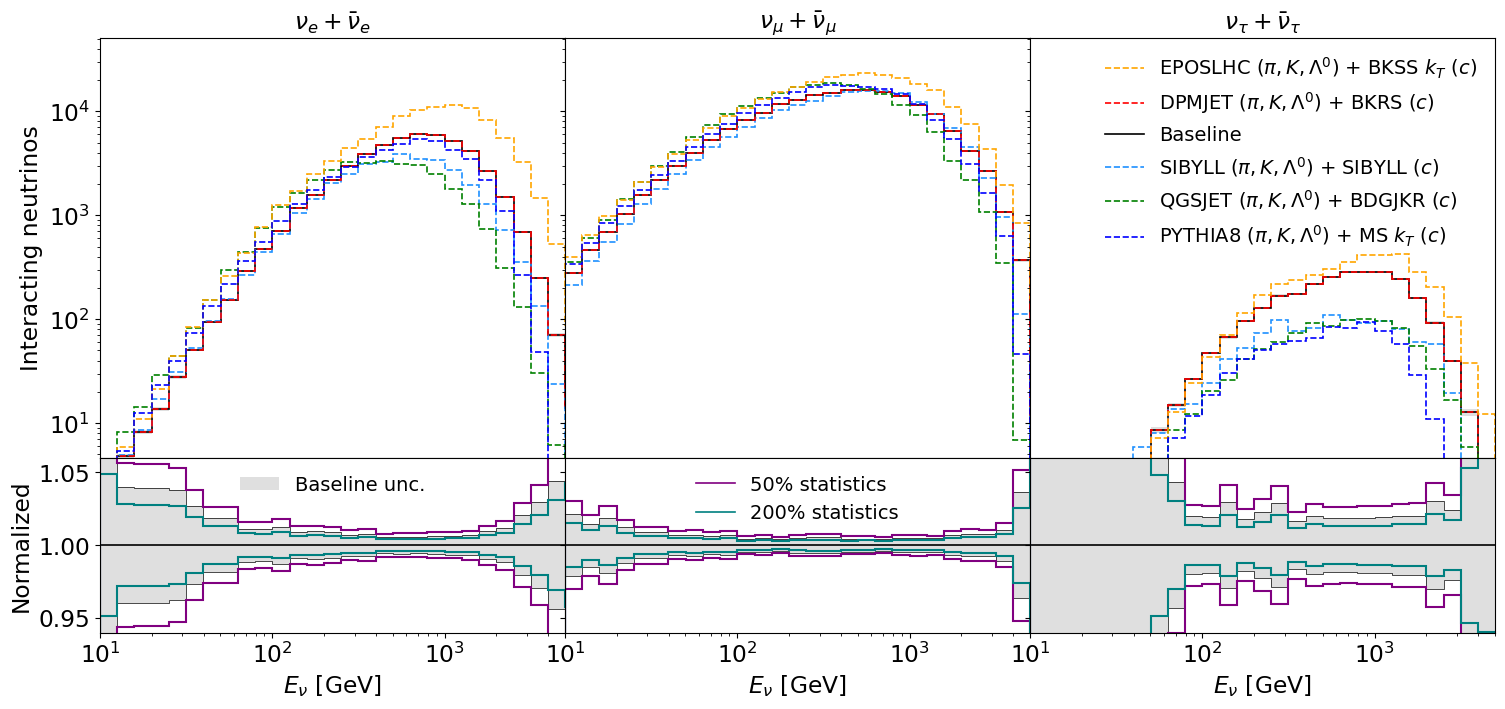

In [30]:
#Redefine lambdazeros to DPMJET+NLO1
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=np.add(singleGenLambdaMatrix('DPMJET'),singleGenLambdaMatrix('BKRS'))

detector='FLARE'

filename='plots/'+codename+'_1_radial_bin_DPMJET+NLO1_baseline.pdf'
vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]

#Setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'medium'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(15,7))
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

col1 ='black'
col05='purple'
col2 ='teal'

#Extract information from baseline
baseline1    = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros))    
baseline1_05 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=0.5)    
baseline1_2  = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=2.0)    
ebins = np.array(baseline1["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
base_entries1    = {}
base_entries1_05 = {}
base_entries1_2  = {}
nmax = 1
for ivpid,vpid in enumerate(vpidstrs):
    entries1    = np.array(baseline1[   vpid]['n_int']).T[0]
    entries1_05 = np.array(baseline1_05[vpid]['n_int']).T[0]
    entries1_2  = np.array(baseline1_2[ vpid]['n_int']).T[0]
    base_entries1[   vpid] = entries1
    base_entries1_05[vpid] = entries1_05
    base_entries1_2[ vpid] = entries1_2
    if max(entries1)>nmax: nmax=max(entries1)
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1, bins=ebins,\
                                histtype='step',color='black',ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_rad1_'+vpid,\
             mode = 'histo')
    axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)

#Plot uncertainty
values1,    vectors1    = linalg.eig(info1AB)
values1_05, vectors1_05 = linalg.eig(info1AB_05)
values1_2,  vectors1_2  = linalg.eig(info1AB_2)
for ivpid,vpid in enumerate(vpidstrs):
    #Central
    base_entry1 = base_entries1[vpid]
    uncertainty1 = base_entry1 - base_entry1
    for value1,vector1 in zip(values1, vectors1.T):
        point1        = vector1/np.sqrt(value1)
        lambdavars1   = [point1[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1   = [np.add(lambdavars1[i],lambdazeros[i]) for i in range(len(lambdavars1))]
        varied1       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1)
        entry1        = np.array(varied1[vpid]['n_int']).T[0]
        uncertainty1 += (entry1 - base_entry1)**2
    uncertainty1 = np.sqrt(uncertainty1)
    wgtp1 = 1 + uncertainty1/base_entry1
    wgtm1    = 1 -    uncertainty1/base_entry1
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1,bins=ebins,histtype='step',color=col1,ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_rad1_'+vpid+'_wgtp1',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1,bins=ebins,histtype='step',color=col1,ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_rad1_'+vpid+'_wgtm1',\
             mode = 'histo')
    errhi1    = np.multiply(wgtp1,base_entry1)
    errlo1    = np.multiply(wgtm1,base_entry1)
    axes[0,ivpid].bar(x=ebins[:-1],\
                      height=np.add(errhi1,np.multiply(-1,errlo1)),\
                      bottom=errlo1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    axes[1,ivpid].bar(x=ebins[:-1],\
                      height=np.add(wgtp1,np.multiply(-1,wgtm1)),\
                      bottom=wgtm1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    #50% statistics
    base_entry1_05 = base_entries1_05[vpid]
    uncertainty1_05 = base_entry1_05 - base_entry1_05
    for value1_05,vector1_05 in zip(values1_05, vectors1_05.T):
        point1_05        = vector1_05/np.sqrt(value1_05)
        lambdavars1_05   = [point1_05[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1_05   = [np.add(lambdavars1_05[i],lambdazeros[i]) for i in range(len(lambdavars1_05))]
        varied1_05       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1_05,fstat=0.5)
        entry1_05        = np.array(varied1_05[vpid]['n_int']).T[0]
        uncertainty1_05 += (entry1_05 - base_entry1_05)**2
    uncertainty1_05 = np.sqrt(uncertainty1_05)
    wgtp1_05 = 1 + uncertainty1_05/base_entry1_05
    wgtm1_05 = 1 - uncertainty1_05/base_entry1_05
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1_05,bins=ebins,\
                                histtype='step',color=col05, ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_05_rad1_'+vpid+'_wgtp1_05',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1_05,bins=ebins,\
                                histtype='step',color=col05, ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_05_rad1_'+vpid+'_wgtm1_05',\
             mode = 'histo')
    errhi1_05 = np.multiply(wgtp1_05,base_entry1_05)
    errlo1_05 = np.multiply(wgtm1_05,base_entry1_05)
    #200% statistics
    base_entry1_2 = base_entries1_2[ vpid]
    uncertainty1_2 = base_entry1_2 - base_entry1_2
    for value1_2,vector1_2 in zip(values1_2, vectors1_2.T):
        point1_2         = vector1_2/np.sqrt(value1_2)
        lambdavars1_2    = [point1_2[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1_2    = [np.add(lambdavars1_2[i],lambdazeros[i]) for i in range(len(lambdavars1_2))]
        varied1_2        = model(detector=detector,radN='_rad1',lambdamat=lambdavars1_2,fstat=2.0)
        entry1_2         = np.array(varied1_2[vpid]['n_int']).T[0]
        uncertainty1_2  += (entry1_2  - base_entry1_2 )**2
    uncertainty1_2  = np.sqrt(uncertainty1_2)
    wgtp1_2  = 1 +  uncertainty1_2/base_entry1_2
    wgtm1_2  = 1 -  uncertainty1_2/base_entry1_2
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1_2,bins=ebins,\
                                histtype='step',color=col2,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_2_rad1_'+vpid+'_wgtp1_2',\
             mode = 'histo')    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1_2,bins=ebins,\
                                histtype='step',color=col2,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_altBL_unc_2_rad1_'+vpid+'_wgtm1_2',\
             mode = 'histo')
    errhi1_2  = np.multiply(wgtp1_2, base_entry1_2)
    errlo1_2  = np.multiply(wgtm1_2, base_entry1_2)

lgdnames=[]  #Rewrite generator names in form suitable for legend
for genset in gens:
    gensettmp=[]
    for ig in range(len(genset)):
        if   genset[ig]=='BKSS': gensettmp.append('BKSS $k_T$')
        elif genset[ig]=='MS':   gensettmp.append('MS $k_T$')
        else: gensettmp.append(genset[ig])
    gensettmp[0] += ' $(\pi, K, \Lambda^0)$'
    gensettmp[1] += ' $(c)$'
    lgdnames.append(gensettmp)
    
#Plot individual generators -- The ordering is s.t.
#  0th gen (e.g. SIBYLL) is obtained w/ all -1
#  1st gen (e.g. DMPJET) w/ 1st lambda=1, others 0
#  2nd gen w/ 2nd lambda=1, others 0
#  3rd gen w/ 3rd lambda=1, others 0
lambdagens1=[] #lambdagens[i] will contain the lambdamatrix for retrieving only the ith generator
#0th gen special case 
lambdagens1.append([np.multiply(-1.,np.ones(n-1)) for n in Ngp])
#Init i>0 cases to all-0 baseline. N.B. #cases depends on total #[generator pairs]=Ng,...
for i in range(Ng-1):  #...hence Ng-1 does NOT refer to particle type specific #lambdas here
    lambdagens1.append(deepcopy(lambdazeros_orig))
#Set the relevant element of each i>0 case lambdamatrix to 1 to pick a single generator
for j in range(Nptypes):
    for i in range(Ngp[j]-1):
        lambdagens1[i+1][j][i] = 1
#Store the "model" objects corresponding to above generator-specific lambdamatrices
genmodels1=[]
for lgenspec in lambdagens1:
    genmodels1.append(model(detector=detector,radN='_rad1',lambdamat=lgenspec))
#Fetch model result projection, store different nu flavor contributions to "entries"
entries1=[]
colors=['dodgerblue','red','green','orange','blue']
nmax = 1  #tmp init
for ivpid,vpid in enumerate(vpidstrs):  #Handle & plot
    for igm,genmodel in enumerate(genmodels1):
        entries1.append(np.array(genmodel[vpid]['n_int']).T[0])
        if max(entries1[-1])>nmax: nmax=max(entries1[-1])
        #Plot histos for this nu flavor
        plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1[-1], bins=ebins,\
                                    histtype='step', color=colors[igm], ls='dashed', lw=1.2),\
                 testsubdir = 'flux-fit-main',\
                 testtag = detector+'_altBL_'+vpid+'_gens'+str(igm),\
                 mode = 'histo')
    
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel("Interacting neutrinos")
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(nmax*2/1.e4,nmax*2.2)
    axes[1,ivpid].set_ylim(0.94,1.06)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[0,ivpid].set_title(vpidlabels[vpid]) #+": 1 radial bin")

#Custom order for legend
lgdorder=[3,1,0,2,4]
for igm in lgdorder:
    if igm==lgdorder[round(0.5*len(lgdorder))]:
        axes[0,2].plot(-1,1, color='black', ls='solid', lw=1.2,label='Baseline')                
    axes[0,2].plot(-1,1, color=colors[igm], ls='dashed', lw=1.2,label=' + '.join(lgdnames[igm]))        
matplotlib.rcParams.update({'legend.loc':'upper right'})
axes[0,2].legend(frameon=False)

#Add legends to uncertainty bands in lower panel
axes[1,1].plot(-1,1, color=col05, ls='solid', lw=1.2,zorder=-1,label='50% statistics')              
axes[1,1].plot(-1,1, color=col2,  ls='solid', lw=1.2,zorder=-1,label='200% statistics')
axes[1,0].bar(-1,1,linewidth=0, color='gray', alpha=0.25, zorder=-1, label='Baseline unc.')
matplotlib.rcParams.update({'legend.loc':'upper center'})
axes[1,1].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'upper center'})
axes[1,0].legend(frameon=False)

#finalize figure
if filename is not None: 
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

### Radial info summary plot (3 bins)

Saved  plots/cSBYAM_lSDQEP_radial_summary.pdf


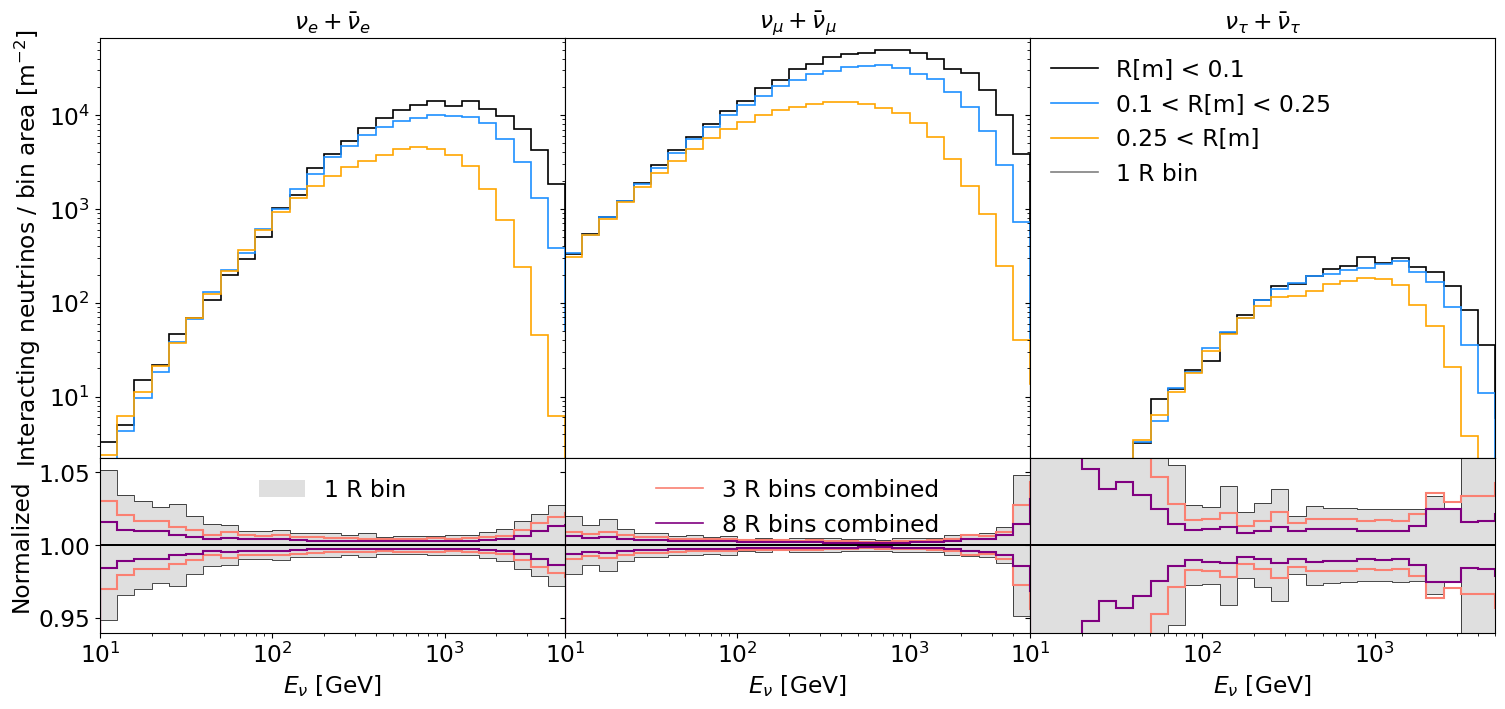

In [31]:
radNstr='_rad3'
infoN=deepcopy(info3) #3 radial bins
detector='FLARE'

filename='plots/'+codename+'_radial_summary.pdf'
fig = plt.figure(figsize=(15,7))

#setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'large'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

#Extract information from baseline
baseline  = model(detector=detector,radN=radNstr,lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
baseline1 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros))    
ebins = np.array(baseline["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
rbins = np.array(baseline["12"]['rbins'])

#Plots will be atop each other, declare scales to improve clarity etc here:
rbinscl  = [1 for _ in range(len(rbins)-1)] #[10**n for n in range(len(rbins)-1)]
rbincol  = ['black','dodgerblue','orange']  #Colors of the radial bin bands
RbinNunccol='salmon'
Rbin1unccol='gray'

rbinlgd =[str(rbins[i])+" < R[m] < "+str(rbins[i+1]) for i in range(len(rbins)-1)]
rbinlgd[0] = "R[m] < "+str(rbins[1])
rbinlgd[-1] = str(rbins[-2])+" < R[m]"

#Detector transverse areas for scaling event numbers
areas=[math.pi*(rbins[i+1]**2 - rbins[i]**2) for i in range(len(rbins)-1)]
areas[-1] = 1-math.pi*rbins[-2]**2  #Assuming FLArE is 1x1 m^2 in xy plane

### Plot different radial bins
uncertainty = [0.0 for _ in list(vpids.keys())]
for rbin in range(len(rbinscl)):

    vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]
        
    rmin, rmax = rbins[rbin], rbins[rbin+1] 
    base_entries={}
    nmax = 1
    for ivpid,vpid in enumerate(vpidstrs):
        entries = np.array(baseline[vpid]['n_int']).T[rbin]
        base_entries[vpid]=entries
        if max(entries)>nmax: nmax=max(entries)
        plotTest(axes[0,ivpid].hist(x=ecenters,\
                                    weights=np.multiply(np.multiply(entries,1.0/areas[rbin]),rbinscl[rbin]),\
                                    bins=ebins, histtype='step', color=rbincol[rbin],ls='solid', lw=1.2),\
                 testsubdir = 'flux-fit-main',\
                 testtag = detector+'_radsummary_rad3_r'+str(rbin)+'_'+vpid,\
                 mode = 'histo')
        axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)
        axes[0,ivpid].plot(-1,1, color=rbincol[rbin], ls='solid', lw=1.2,label=rbinlgd[rbin])                
    #Compute uncertainty
    values, vectors = linalg.eig(infoN)
    for ivpid,vpid in enumerate(vpidstrs):
        base_entry = base_entries[vpid]
        for value,vector in zip(values, vectors.T):
            point=vector/np.sqrt(value)
            lambdavars = [point[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavars = [np.add(lambdavars[i],lambdazeros[i]) for i in range(len(lambdavars))]
            varied = model(detector=detector,radN=radNstr, lambdamat=lambdavars, fs=0.0)
            entry = np.array(varied[vpid]['n_int']).T[rbin]
            uncertainty[ivpid] += (entry - base_entry)**2            
            
#Plot 1 radial bin case uncertainty for reference
base_entries1 = {}
values1, vectors1 = linalg.eig(info1)
for ivpid,vpid in enumerate(vpidstrs):
    #Central
    entries1 = np.array(baseline1[   vpid]['n_int']).T[0]
    base_entries1[vpid] = entries1
    base_entry1  = base_entries1[vpid]
    uncertainty1 = base_entry1 - base_entry1
    for value1,vector1 in zip(values1, vectors1.T):
        point1        = vector1/np.sqrt(value1)
        lambdavars1   = [point1[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1   = [np.add(lambdavars1[i],lambdazeros[i]) for i in range(len(lambdavars1))]
        varied1       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1)
        entry1        = np.array(varied1[vpid]['n_int']).T[0]
        uncertainty1 += (entry1 - base_entry1)**2
    uncertainty1 = np.sqrt(uncertainty1)
    wgtp1 = 1 + uncertainty1/base_entry1
    wgtm1 = 1 - uncertainty1/base_entry1
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1,bins=ebins,\
                                histtype='step',color='black',ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad1_uncref_'+vpid+'_wgtp1',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1,bins=ebins,\
                                histtype='step',color='black',ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad1_uncref_'+vpid+'_wgtm1',\
             mode = 'histo')
    axes[1,ivpid].bar(x=ebins[:-1],\
                      height=np.add(wgtp1,np.multiply(-1,wgtm1)),\
                      bottom=wgtm1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color=Rbin1unccol,\
                      alpha=0.25, zorder=-1)
    axes[0,ivpid].plot(-1,1, color=Rbin1unccol, ls='solid', lw=1.2,label='1 R bin')                
            
#Plot 3 radial bin combined uncertainty
for ivpid,vpid in enumerate(vpidstrs):
    for rbin in range(len(rbinscl)):
        entries = np.array(baseline[vpid]['n_int']).T[rbin]
        base_entries[vpid]=entries
        base_entry = base_entries[vpid]
        if rbin==0:
            base_entry_sum = base_entry
        else:
            base_entry_sum = np.add(base_entry_sum,base_entry)
    uncertainty[ivpid] = np.sqrt(uncertainty[ivpid])
    wgtp = 1+uncertainty[ivpid]/base_entry_sum
    wgtm = 1-uncertainty[ivpid]/base_entry_sum        
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp,bins=ebins,\
                                histtype='step',color=RbinNunccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad3combination_'+vpid+'_wgtp',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm,bins=ebins,\
                                histtype='step',color=RbinNunccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad3combination_'+vpid+'_wgtm',\
             mode = 'histo')

#Compute uncertainty for 8 R bins
uncertainty8 = [0.0 for _ in list(vpids.keys())]
base_entries8={}
Rbin8unccol='purple'
baseline8 = model(detector=detector,radN='_rad8',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
values8, vectors8 = linalg.eig(info8)
for ivpid,vpid in enumerate(vpidstrs):
    for rbin in range(8):
        entries8 = np.array(baseline8[vpid]['n_int']).T[rbin]
        base_entries8[vpid] = entries8
        base_entry8 = base_entries8[vpid]
        if rbin==0:
            base_entry_sum8 = base_entry8
        else:
            base_entry_sum8 = np.add(base_entry_sum8,base_entry8)
        for value8,vector8 in zip(values8, vectors8.T):
            point8=vector8/np.sqrt(value8)
            lambdavars8 = [point8[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavars8 = [np.add(lambdavars8[i],lambdazeros[i]) for i in range(len(lambdavars8))]
            varied8 = model(detector=detector,radN='_rad8', lambdamat=lambdavars8, fs=0.0)
            entry8 = np.array(varied8[vpid]['n_int']).T[rbin]
            uncertainty8[ivpid] += (entry8 - base_entry8)**2
    uncertainty8[ivpid] = np.sqrt(uncertainty8[ivpid])
    wgtp8 = 1+uncertainty8[ivpid]/base_entry_sum8
    wgtm8 = 1-uncertainty8[ivpid]/base_entry_sum8
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp8,bins=ebins,\
                                histtype='step',color=Rbin8unccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad8combination_'+vpid+'_wgtp8',\
             mode = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm8,bins=ebins,\
                                histtype='step',color=Rbin8unccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = detector+'_radsummary_rad8combination_'+vpid+'_wgtm8',\
             mode = 'histo')
    
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel(r'Interacting neutrinos / bin area [m$^{-2}$]')
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(nmax*2/1.e4,max(rbinscl)*nmax*6)
    axes[1,ivpid].set_ylim(0.94,1.06)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[0,ivpid].set_title(vpidlabels[vpid])
matplotlib.rcParams.update({'legend.loc':'upper left'})
axes[0,2].legend(frameon=False)

#Add legends to uncertainty bands in lower panel
axes[1,1].plot(-1,1, color=RbinNunccol, ls='solid', lw=1.2,label='3 R bins combined')                
axes[1,1].plot(-1,1, color=Rbin8unccol, ls='solid', lw=1.2,label='8 R bins combined')                
axes[1,0].bar(-1,1,linewidth=0, color='gray', alpha=0.25, zorder=-1, label='1 R bin')
matplotlib.rcParams.update({'legend.loc':'upper center'})
axes[1,1].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'upper center'})
axes[1,0].legend(frameon=False)

#finalize figure
if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

### Radial info summary plot (8 bins)

Saved  plots/radial_summary_rad8cSBYAM_lSDQEP.pdf


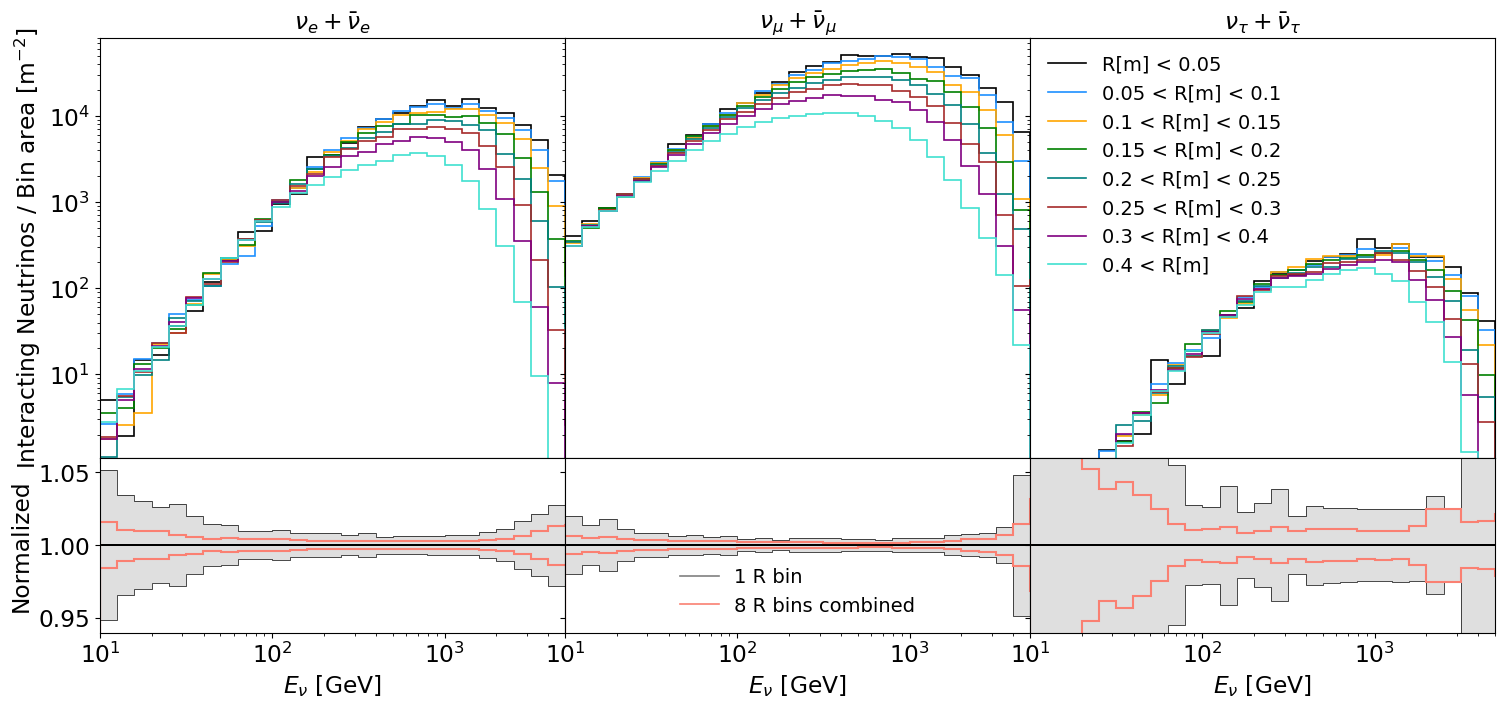

In [32]:
radNstr='_rad8'
infoN=deepcopy(info8) #8 radial bins
detector='FLARE'

filename='plots/radial_summary'+radNstr+codename+'.pdf'
fig = plt.figure(figsize=(15,7))

#setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'medium'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

#Extract information from baseline
baseline  = model(detector=detector,radN=radNstr,lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
baseline1 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
ebins = np.array(baseline["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
rbins = np.array(baseline["12"]['rbins'])

#Plots will be atop each other, declare scales to improve clarity etc here:
rbinscl  = [1 for _ in range(len(rbins)-1)]
rbincol  = ['black','dodgerblue','orange','green','teal','brown','purple','turquoise'] #Colors of the radial bin bands
RbinNunccol='salmon'
Rbin1unccol='gray'

rbinlgd =[str(rbins[i])+" < R[m] < "+str(rbins[i+1]) for i in range(len(rbins)-1)]
rbinlgd[0] = "R[m] < "+str(rbins[1])
rbinlgd[-1] = str(rbins[-2])+" < R[m]"

#Detector transverse areas for scaling event numbers
areas=[math.pi*(rbins[i+1]**2 - rbins[i]**2) for i in range(len(rbins)-1)]
areas[-1] = 1-math.pi*rbins[-2]**2  #Assuming FLArE is 1x1 m^2 in xy plane

### Plot different radial bins
uncertainty = [0.0 for _ in list(vpids.keys())]
for rbin in range(len(rbinscl)):

    vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]
        
    rmin, rmax = rbins[rbin], rbins[rbin+1] 
    base_entries={}
    nmax = 1
    for ivpid,vpid in enumerate(vpidstrs):
        entries = np.array(baseline[vpid]['n_int']).T[rbin]
        base_entries[vpid]=entries
        if max(entries)>nmax: nmax=max(entries)
        plotTest(axes[0,ivpid].hist(x=ecenters,\
                                    weights=np.multiply(np.multiply(entries,1.0/areas[rbin]),rbinscl[rbin]),\
                                    bins=ebins, histtype='step',color=rbincol[rbin],ls='solid',lw=1.2),\
                 testsubdir = 'flux-fit-main',\
                 testtag = detector+'_radsummary8_r'+str(rbin)+'_'+vpid,\
                 mode = 'histo')
        axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)
        axes[0,ivpid].plot(-1,1, color=rbincol[rbin], ls='solid', lw=1.2,label=rbinlgd[rbin])                
    #Compute uncertainty
    values, vectors = linalg.eig(infoN)
    for ivpid,vpid in enumerate(vpidstrs):
        base_entry = base_entries[vpid]
        for value,vector in zip(values, vectors.T):
            point=vector/np.sqrt(value)
            lambdavars = [point[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavars = [np.add(lambdavars[i],lambdazeros[i]) for i in range(len(lambdavars))]
            varied = model(detector=detector,radN=radNstr, lambdamat=lambdavars, fs=0.0)
            entry = np.array(varied[vpid]['n_int']).T[rbin]
            uncertainty[ivpid] += (entry - base_entry)**2

#Plot 1 radial bin case uncertainty for reference
values1, vectors1 = linalg.eig(info1)
for ivpid,vpid in enumerate(vpidstrs):
    #Central
    entries1 = np.array(baseline1[vpid]['n_int']).T[0]
    base_entries1[vpid] = entries1
    base_entry1  = base_entries1[vpid]
    uncertainty1 = base_entry1 - base_entry1
    for value1,vector1 in zip(values1, vectors1.T):
        point1        = vector1/np.sqrt(value1)
        lambdavars1   = [point1[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
        lambdavars1   = [np.add(lambdavars1[i],lambdazeros[i]) for i in range(len(lambdavars1))]
        varied1       = model(detector=detector,radN='_rad1',lambdamat=lambdavars1)
        entry1        = np.array(varied1[vpid]['n_int']).T[0]
        uncertainty1 += (entry1 - base_entry1)**2
    uncertainty1 = np.sqrt(uncertainty1)
    wgtp1 = 1 + uncertainty1/base_entry1
    wgtm1    = 1 -    uncertainty1/base_entry1
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp1,bins=ebins,\
                                histtype='step',color='black',ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad8_rad1ref_'+vpid+'_wgtp1',\
             mode       = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm1,bins=ebins,\
                                histtype='step',color='black',ls='solid',lw=0.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad8_rad1ref_'+vpid+'_wgtm1',\
             mode       = 'histo')
    axes[1,ivpid].bar(x=ebins[:-1],\
                      height=np.add(wgtp1,np.multiply(-1,wgtm1)),\
                      bottom=wgtm1,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color=Rbin1unccol,\
                      alpha=0.25, zorder=-1)
            
#Plot N bin combined uncertainty
for ivpid,vpid in enumerate(vpidstrs):
    for rbin in range(len(rbinscl)):
        entries = np.array(baseline[vpid]['n_int']).T[rbin]
        base_entries[vpid]=entries
        base_entry = base_entries[vpid]
        if rbin==0:
            base_entry_sum = base_entry
        else:
            base_entry_sum = np.add(base_entry_sum,base_entry)
    uncertainty[ivpid] = np.sqrt(uncertainty[ivpid])
    wgtp = 1+uncertainty[ivpid]/base_entry_sum
    wgtm = 1-uncertainty[ivpid]/base_entry_sum    
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp,bins=ebins,\
                                histtype='step',color=RbinNunccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad8_unc_'+vpid+'_wgtp',\
             mode       = 'histo')
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm,bins=ebins,\
                                histtype='step',color=RbinNunccol,ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad8_unc_'+vpid+'_wgtm',\
             mode       = 'histo')
                      
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel(r'Interacting Neutrinos / Bin area [m$^{-2}$]')
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(nmax*2/1.e4,max(rbinscl)*nmax*15)
    axes[1,ivpid].set_ylim(0.94,1.06)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[0,ivpid].set_title(vpidlabels[vpid])
matplotlib.rcParams.update({'legend.loc':'upper left'})
axes[0,2].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'lower center'})
axes[1,1].plot(-1,1, color=Rbin1unccol, ls='solid', lw=1.2,label='1 R bin')                
axes[1,1].plot(-1,1, color=RbinNunccol, ls='solid', lw=1.2,label='8 R bins combined')                
axes[1,1].legend(frameon=False)

#Add text to indicate multiplication by powers of 10
#rbinstrs=["R[m] < "+str(rbins[1]),
#          str(rbins[1])+" < R[m] < "+str(rbins[2])+r', N$\times$'+str(int(rbinscl[1])),
#          str(rbins[2])+" < R[m]"+r', N$\times$'+str(int(rbinscl[2]))]
# nu_e
#axes[0,0].text(12,  1050,rbinstrs[2],rotation=40.)
#axes[0,0].text(12,    20,rbinstrs[1],rotation=40.)
#axes[0,0].text(30,     5,rbinstrs[0],rotation=40.)
# nu_mu
#axes[0,1].text(10,  70000,rbinstrs[2],rotation=28.)
#axes[0,1].text(10,   1000,rbinstrs[1],rotation=28.)
#axes[0,1].text(12,     40,rbinstrs[0],rotation=28.)
# nu_tau
#axes[0,2].text( 12, 70,rbinstrs[2],rotation=45.)
#axes[0,2].text( 20,  5,rbinstrs[1],rotation=40.)
#axes[0,2].text(170,  6,rbinstrs[0],rotation=30.)

#finalize figure
if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

### Experiment comparison (3 R bins)

Saved  plots/experiments_cSBYAM_lSDQEP_3_radial_bins.pdf


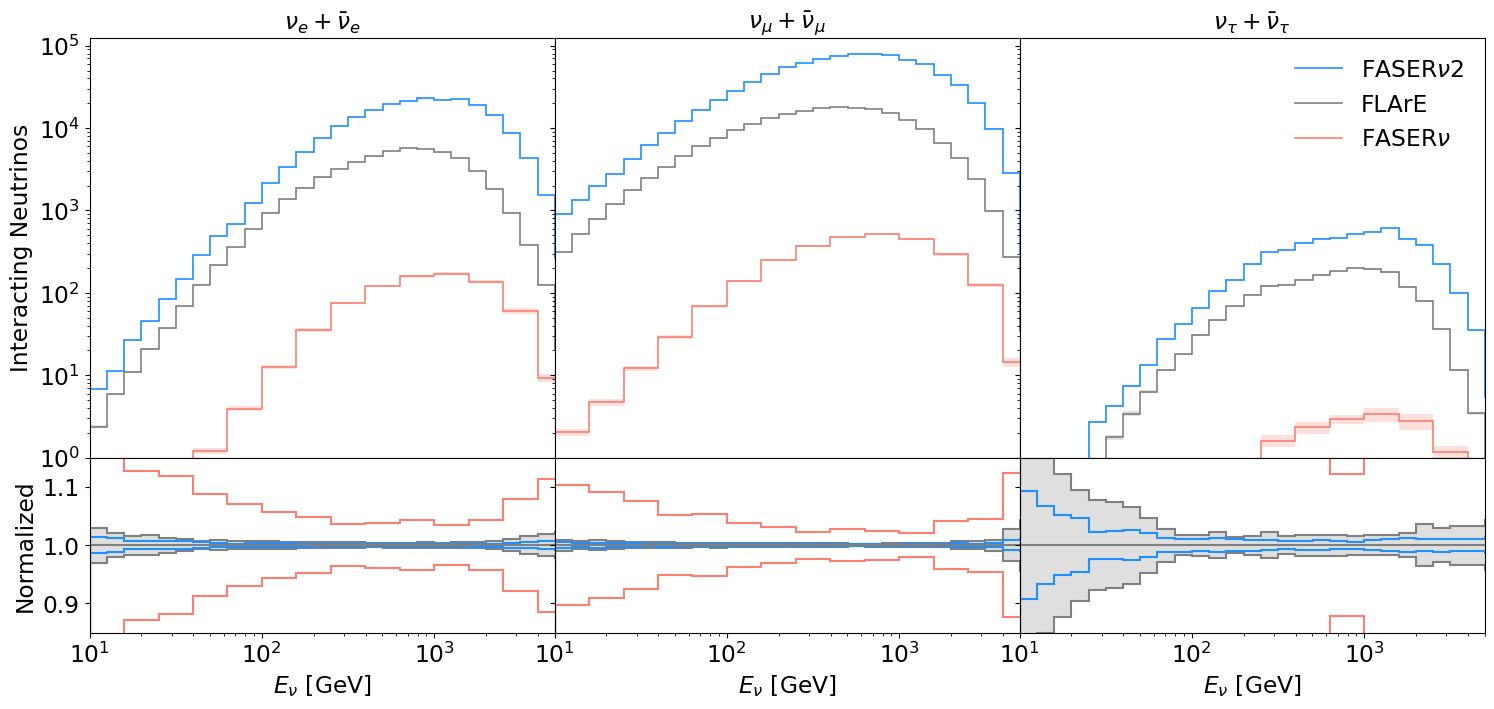

In [33]:
radNstr='_rad1'

filename='plots/experiments_'+codename+'_3_radial_bins.pdf'
vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]

#Setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'large'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(15,7))
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax13 = fig.add_axes([0.68, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
ax23 = fig.add_axes([0.68, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

colors={}
colors['FLARE']   = 'gray'
colors['FASERv']  = 'salmon'
colors['FASERv2'] = 'dodgerblue'

#Extract information from baseline
baseline1         = model(detector='FLARE',  radN=radNstr,lambdamat=deepcopy(lambdazeros))    
baseline1_FASERv  = model(detector='FASERv', radN=radNstr,lambdamat=deepcopy(lambdazeros))    
baseline1_FASERv2 = model(detector='FASERv2',radN=radNstr,lambdamat=deepcopy(lambdazeros))    
ebins        = np.array(baseline1["12"]['ebins'])
ebins_FASERv = np.array(baseline1_FASERv["12"]['ebins'])
ecenters        = (ebins[1:]+ebins[:-1])/2
ecenters_FASERv = (ebins_FASERv[1:]+ebins_FASERv[:-1])/2
base_entries1 = {}
base_entries1_FASERv = {}
base_entries1_FASERv2 = {}
nmax = 1
for ivpid,vpid in enumerate(vpidstrs):
    entries1         = np.array(baseline1[        vpid]['n_int']).T[0]
    entries1_FASERv  = np.array(baseline1_FASERv[ vpid]['n_int']).T[0]
    entries1_FASERv2 = np.array(baseline1_FASERv2[vpid]['n_int']).T[0]
    base_entries1[   vpid] = entries1
    base_entries1_FASERv[ vpid] = entries1_FASERv
    base_entries1_FASERv2[vpid] = entries1_FASERv2
    if max(entries1)>nmax: nmax=max(entries1)    
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1, bins=ebins,\
                                histtype='step', color=colors['FLARE'], ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FLARE_BL_rad3_rad1ref_expcomp_'+vpid,\
             mode       = 'histo')
    axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color=colors['FLARE'], ls='solid', lw=1.2)

    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1_FASERv2, bins=ebins,\
                                histtype='step', color=colors['FASERv2'], ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FASERv2_BL_rad3_rad1ref_expcomp_'+vpid,\
             mode       = 'histo')
    axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color=colors['FASERv2'], ls='solid', lw=1.2)

    plotTest(axes[0,ivpid].hist(x=ecenters_FASERv, weights=entries1_FASERv, bins=ebins_FASERv,\
                                histtype='step', color=colors['FASERv'], ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FASERv_BL_rad3_rad1ref_expcomp_'+vpid,\
             mode       = 'histo')
    axes[1,ivpid].hist(x=ecenters_FASERv, bins=ebins_FASERv, histtype='step', color=colors['FASERv'], ls='solid', lw=1.2)

#Compute uncertainty for 3 R bins
NRbins=3
for detStr in detectors:
    uncertainty = [0.0 for _ in list(vpids.keys())]
    base_entries={}
    baseline  = model(detector=detStr,radN='_rad'+str(NRbins),lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
    baseline1 = model(detector=detStr,radN='_rad1',           lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
    if detStr=='FLARE':
        values, vectors = linalg.eig(info3)
    elif detStr=='FASERv2':
        values, vectors = linalg.eig(info3_FASERv2)
    elif detStr=='FASERv':
        values, vectors = linalg.eig(info3_FASERv)
    for ivpid,vpid in enumerate(vpidstrs):
        for rbin in range(NRbins):
            entries  = np.array(baseline[ vpid]['n_int']).T[rbin]
            entries1 = np.array(baseline1[vpid]['n_int']).T[0]
            base_entries[ vpid] = entries
            base_entries1[vpid] = entries1
            base_entry  = base_entries[ vpid]
            base_entry1 = base_entries1[vpid]
            if rbin==0:
                base_entry_sum = base_entry
            else:
                base_entry_sum = np.add(base_entry_sum,base_entry)
            for value,vector in zip(values, vectors.T):
                point=vector/np.sqrt(value)
                lambdavars = [point[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
                lambdavars = [np.add(lambdavars[i],lambdazeros[i]) for i in range(len(lambdavars))]
                varied = model(detector=detStr,radN='_rad'+str(NRbins), lambdamat=lambdavars, fs=0.0)
                entry = np.array(varied[vpid]['n_int']).T[rbin]
                uncertainty[ivpid] += (entry - base_entry)**2
        uncertainty[ivpid] = np.sqrt(uncertainty[ivpid])
        wgtp = 1+uncertainty[ivpid]/base_entry_sum
        wgtm = 1-uncertainty[ivpid]/base_entry_sum
        if detStr=='FASERv':
            plotTest(axes[1,ivpid].hist(x=ecenters_FASERv,weights=wgtp,bins=ebins_FASERv,\
                                        histtype='step',color=colors[detStr],ls='solid',lw=1.5),\
                     testsubdir = 'flux-fit-main',\
                     testtag    = detStr+'_rad3_unc_expcomp_'+vpid+'_wgtp',\
                     mode       = 'histo')
            plotTest(axes[1,ivpid].hist(x=ecenters_FASERv,weights=wgtm,bins=ebins_FASERv,\
                                        histtype='step',color=colors[detStr],ls='solid',lw=1.5),\
                     testsubdir = 'flux-fit-main',\
                     testtag    = detStr+'_rad3_unc_expcomp_'+vpid+'_wgtm',\
                     mode       = 'histo')
        else:            
            plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtp,bins=ebins,\
                                        histtype='step',color=colors[detStr],ls='solid',lw=1.5),\
                     testsubdir = 'flux-fit-main',\
                     testtag    = detStr+'_rad3_unc_expcomp_'+vpid+'_wgtp',\
                     mode       = 'histo')           
            plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtm,bins=ebins,\
                                        histtype='step',color=colors[detStr],ls='solid',lw=1.5),\
                     testsubdir = 'flux-fit-main',\
                     testtag    = detStr+'_rad3_unc_expcomp_'+vpid+'_wgtm',\
                     mode       = 'histo')
        errhi = np.multiply(wgtp,base_entry1)
        errlo = np.multiply(wgtm,base_entry1)
        #Fill the FLARE uncertainty band
        if detStr=='FLARE':
            axes[1,ivpid].bar(x=ebins[:-1],\
                          height=np.add(wgtp,np.multiply(-1,wgtm)),\
                          bottom=wgtm,\
                          width=np.diff(ebins),\
                          align='edge', linewidth=0, color='gray',\
                          alpha=0.25, zorder=-1)
        if detStr=='FASERv':
            axes[0,ivpid].bar(x=ebins_FASERv[:-1],\
                              height=np.add(errhi,np.multiply(-1,errlo)),\
                              bottom=errlo,\
                              width=np.diff(ebins_FASERv),\
                              align='edge', linewidth=0, color=colors[detStr],\
                              alpha=0.25, zorder=-1)
        else:
            axes[0,ivpid].bar(x=ebins[:-1],\
                              height=np.add(errhi,np.multiply(-1,errlo)),\
                              bottom=errlo,\
                              width=np.diff(ebins),\
                              align='edge', linewidth=0, color=colors[detStr],\
                              alpha=0.25, zorder=-1)

lgdnames = detectors.copy()  #Rewrite detector names in form suitable for legend
for i in range(len(lgdnames)):
    if   lgdnames[i]=='FLARE':   lgdnames[ig]='FLArE'
    elif lgdnames[i]=='FASERv':  lgdnames[ig]='FASER$\nu$'
    elif lgdnames[i]=='FASERv2': lgdnames[ig]='FASER$\nu$2'        
        
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel("Interacting Neutrinos")
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(1.0,nmax*7)
    axes[1,ivpid].set_ylim(0.85,1.15)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[1,ivpid].plot([10,5000],[1,1],color='gray', ls='solid')        
    axes[0,ivpid].set_title(vpidlabels[vpid]) #+": 1 radial bin")

#Custom order for legend
axes[0,2].plot(-1,1, color=colors['FASERv2'], ls='solid', lw=1.2,label=r'FASER$\nu$2')        
axes[0,2].plot(-1,1, color=colors['FLARE'],   ls='solid', lw=1.2,label=r'FLArE')                
axes[0,2].plot(-1,1, color=colors['FASERv'],  ls='solid', lw=1.2,label=r'FASER$\nu$')        
matplotlib.rcParams.update({'legend.loc':'upper right'})
axes[0,2].legend(frameon=False)


#finalize figure
if filename is not None: 
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

###  Plot with both mutau and taue constraints (rad 3)

Saved  plots/cSBYAM_lSDQEP_mutau_taue_constraints_rad3.pdf


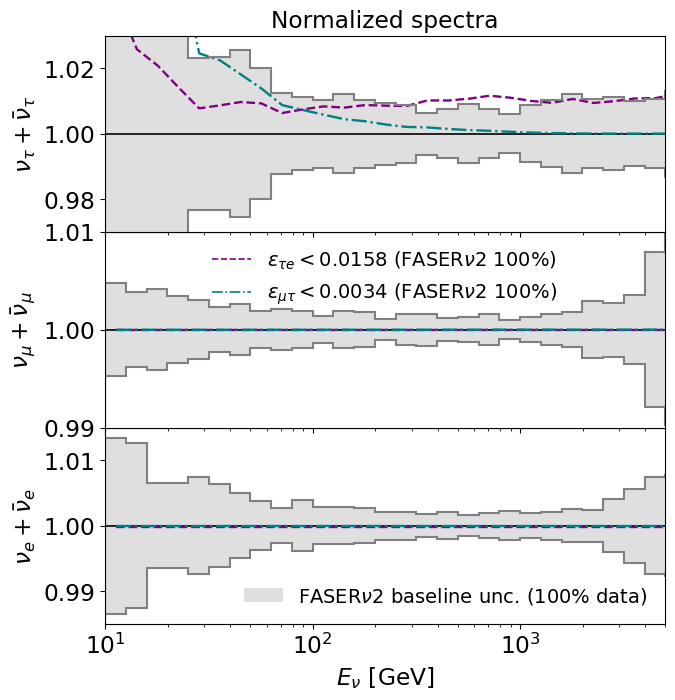

In [34]:
NRbins = 3
infobaseline = info3_FASERv2
filename='plots/'+codename+'_mutau_taue_constraints_rad'+str(NRbins)+'.pdf'
detector='FASERv2'

taueval  = taue3constraint
mutauval = mutau3constraint

#setup figure
fig = plt.figure(figsize=(7,7))
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'medium'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams['text.usetex'] = False
ax1 = fig.add_axes([0.17, 0.10, 0.80, 0.28], )
ax2 = fig.add_axes([0.17, 0.38, 0.80, 0.28], )
ax3 = fig.add_axes([0.17, 0.66, 0.80, 0.28], )
axes = np.array([[ax1],[ax2],[ax3]])

uncertainty = [0.0 for _ in list(vpids.keys())]
vpidstrs = [str(vpidkey) for vpidkey in list(vpids.keys())]

colors={}
styles={}
colors['taue' ] = 'purple'
colors['mutau'] = 'teal'
styles['taue' ] = 'dashed'
styles['mutau'] = 'dashdot'


#Extract information from baseline (using 1 radial bin case!)
baseline      = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
baselinetaue  = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0,taue=taueval)    
baselinemutau = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0,mutau=mutauval)    
ebins = np.array(baseline["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
base_entries={}
base_entriestaue={}
base_entriesmutau={}
nmax = 1
for ivpid,vpid in enumerate(vpidstrs):
    entries      = np.array(baseline[     vpid]['n_int']).T[0]
    entriestaue  = np.array(baselinetaue[ vpid]['n_int']).T[0]
    entriesmutau = np.array(baselinemutau[vpid]['n_int']).T[0]
    base_entries[     vpid] = entries
    base_entriestaue[ vpid] = entriestaue
    base_entriesmutau[vpid] = entriesmutau
    if max(entries)>nmax: nmax=max(entries)
    axes[ivpid,0].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)

#Plot ratios w/ vs w/o/ NSI (based on 1 radial bin case, although unc at N bins)
for ivpid,vpid in enumerate(vpidstrs):
    #Central
    base_entry1      = base_entries[     vpid]
    base_entry1taue  = base_entriestaue[ vpid]
    base_entry1mutau = base_entriesmutau[vpid]
    ratiotaue  = base_entry1taue/base_entry1
    ratiomutau = base_entry1mutau/base_entry1
    plotTest(axes[ivpid,0].plot(ecenters, ratiotaue,  color=colors['taue'],  ls=styles['taue'], lw=1.7),\
             testsubdir = 'flux-fit-main',\
             testtag = 'taue_constr_rad3_'+vpid,\
             mode = 'plot')                
    plotTest(axes[ivpid,0].plot(ecenters, ratiomutau, color=colors['mutau'], ls=styles['mutau'], lw=1.7),\
             testsubdir = 'flux-fit-main',\
             testtag = 'mutau_constr_rad3_'+vpid,\
             mode = 'plot')


#Compute uncertainty for 3 R bins
uncertaintyN = [0.0 for _ in list(vpids.keys())]
base_entriesN={}
baselineN = model(detector=detector,radN='_rad'+str(NRbins),lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
valuesN, vectorsN = linalg.eig(infobaseline)
for ivpid,vpid in enumerate(vpidstrs):
    for rbin in range(NRbins):
        entriesN = np.array(baselineN[vpid]['n_int']).T[rbin]
        base_entriesN[vpid] = entriesN
        base_entryN = base_entriesN[vpid]
        if rbin==0:
            base_entry_sumN = base_entryN
        else:
            base_entry_sumN = np.add(base_entry_sumN, base_entryN)
        for valueN, vectorN in zip(valuesN, vectorsN.T):
            pointN = vectorN / np.sqrt(valueN)
            lambdavarsN = [pointN[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavarsN = [np.add(lambdavarsN[i],lambdazeros[i]) for i in range(len(lambdavarsN))]
            variedN = model(detector=detector, radN='_rad'+str(NRbins), lambdamat=lambdavarsN, fs=0.0)
            entryN = np.array(variedN[vpid]['n_int']).T[rbin]
            uncertaintyN[ivpid] += (entryN - base_entryN)**2
    uncertaintyN[ivpid] = np.sqrt(uncertaintyN[ivpid])
    wgtpN = 1 + uncertaintyN[ivpid] / base_entry_sumN
    wgtmN = 1-uncertaintyN[ivpid]/base_entry_sumN    
    plotTest(axes[ivpid,0].hist(x=ecenters,weights=wgtpN,bins=ebins,\
                                histtype='step',color='gray',ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad3_unc_mutau_taue_constr_'+vpid+'_wgtpN',\
             mode       = 'histo')
    plotTest(axes[ivpid,0].hist(x=ecenters,weights=wgtmN,bins=ebins,\
                                histtype='step',color='gray',ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad3_unc_mutau_taue_constr_'+vpid+'_wgtmN',\
             mode       = 'histo')
    axes[ivpid,0].bar(x=ebins[:-1],\
                      height=np.add(wgtpN,np.multiply(-1,wgtmN)),\
                      bottom=wgtmN,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    axes[ivpid,0].set_ylabel(vpidlabels[vpid])
    axes[ivpid,0].set_xscale("log")
    axes[ivpid,0].set_xscale("log")
    axes[ivpid,0].set_yscale("log")
    axes[ivpid,0].set_yscale("linear")
    axes[ivpid,0].set_xlim(10,5000)
    axes[ivpid,0].set_title('Normalized spectra')
axes[1,0].set_xticklabels([])
axes[2,0].set_xticklabels([])
axes[2,0].set_ylim(0.97, 1.03)   #tau neutrinos
axes[1,0].set_ylim(0.99, 1.01)   #muon neutrinos
axes[0,0].set_ylim(0.985,1.015)  #electron neutrinos
axes[0,0].set_xlabel(r'$E_\nu$ [GeV]')

#Legend
Ndec=1e4  #Round fs constraints to 4 decimals
axes[1,0].plot(-1,1, color=colors['taue'],  ls=styles['taue'],  lw=1.2, label=r'$\epsilon_{\tau e}<$' +str(round(Ndec*taueval )/Ndec)+r' (FASER$\nu$2 100%) ')                
axes[1,0].plot(-1,1, color=colors['mutau'], ls=styles['mutau'], lw=1.2, label=r'$\epsilon_{\mu\tau}<$'+str(round(Ndec*mutauval)/Ndec)+r' (FASER$\nu$2 100%) ')                
matplotlib.rcParams.update({'legend.loc':'upper center'})
axes[1,0].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'lower right'})
axes[0,0].bar(-1,1,linewidth=0, color='gray', alpha=0.25, zorder=-1, label=r'FASER$\nu$2 baseline unc. (100% data)')
axes[0,0].legend(frameon=False)

#finalize figure
if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

## Enhanced strangeness

### Info matrices

In [35]:
%%time

#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

usePrecomputedInfo1fs = False

info1SIBYLL     = get_information(detector='FLARE',radN = '_rad1',fstat=1.0,usefs=False)
info1fs         = get_information(detector='FLARE',radN = '_rad1',fstat=1.0,usefs=True)
info1fs_FASERv  = get_information(detector='FASERv',radN = '_rad1',fstat=1.0,usefs=True)
info1SIBYLL_10p = get_information(detector='FLARE',radN = '_rad1',fstat=0.1,usefs=False)
info1fs_10p     = get_information(detector='FLARE',radN = '_rad1',fstat=0.1,usefs=True)
print("Fisher information (1 radial bin), SIBYLL as baseline")
print (np.matrix(info1SIBYLL))
print("Fisher information (1 radial bin), enhanced strangeness study")
print (np.matrix(info1fs))
print("Fisher information (1 radial bin), enhanced strangeness study, FASERv")
print (np.matrix(info1fs_FASERv))
print("Fisher information (1 radial bin), SIBYLL as baseline, 10% of data")
print (np.matrix(info1SIBYLL_10p))
print("Fisher information (1 radial bin), enhanced strangeness study, 10% of data")
print (np.matrix(info1fs_10p))

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (1 radial bin), SIBYLL as baseline
[[ 4.54877869e+02 -8.25644282e+02 -5.54007278e+02  5.46162089e+01
  -3.24703684e+02 -5.02900063e+01  1.06951595e+02 -1.09171240e+02
   8.11065819e+01 -5.17622684e+02  9.98713607e+02 -1.03401630e+02]
 [-8.25644282e+02  1.76006608e+03  1.24

In [36]:
%%time

#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

info3SIBYLL     = get_information(detector='FLARE', radN = '_rad3',fstat=1.0,usefs=False)
info3fs         = get_information(detector='FLARE', radN = '_rad3',fstat=1.0,usefs=True)
info3fs_FASERv  = get_information(detector='FASERv',radN = '_rad3',fstat=1.0,usefs=True)
info3SIBYLL_10p = get_information(detector='FLARE', radN = '_rad3',fstat=0.1,usefs=False)
info3fs_10p     = get_information(detector='FLARE', radN = '_rad3',fstat=0.1,usefs=True)
print("Fisher information (3 radial bins), SIBYLL as baseline")
print (np.matrix(info3SIBYLL))
print("Fisher information (3 radial bins), enhanced strangeness study")
print (np.matrix(info3fs))
print("Fisher information (3 radial bins), enhanced strangeness study, FASERv")
print (np.matrix(info3fs_FASERv))
print("Fisher information (3 radial bins), SIBYLL as baseline, 10% of data")
print (np.matrix(info3SIBYLL_10p))
print("Fisher information (3 radial bins), enhanced strangeness study, 10% of data")
print (np.matrix(info3fs_10p))

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (3 radial bins), SIBYLL as baseline
[[ 5.55479335e+02 -9.60687343e+02 -5.66913121e+02  6.10395086e+01
  -4.23953252e+02  1.82096627e+01  1.81361103e+02 -1.07092690e+02
   1.02282078e+02 -5.46943137e+02  1.03868087e+03 -1.04008641e+02]
 [-9.60687343e+02  2.12468319e+03  1.1

In [37]:
%%time

#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

usePrecomputedInfo8fs = False

info8SIBYLL     = get_information(detector='FLARE', radN = '_rad8',fstat=1.0,usefs=False)
info8fs         = get_information(detector='FLARE', radN = '_rad8',fstat=1.0,usefs=True)
info8fs_FASERv  = get_information(detector='FASERv',radN = '_rad8',fstat=1.0,usefs=True)
info8SIBYLL_10p = get_information(detector='FLARE', radN = '_rad8',fstat=0.1,usefs=False)
info8fs_10p     = get_information(detector='FLARE', radN = '_rad8',fstat=0.1,usefs=True)
print("Fisher information (8 radial bins), SIBYLL as baseline")
print (np.matrix(info8SIBYLL))
print("Fisher information (8 radial bins), enhanced strangeness study")
print (np.matrix(info8fs))
print("Fisher information (8 radial bins), enhanced strangeness study, FASERv")
print (np.matrix(info8fs_FASERv))
print("Fisher information (8 radial bins), SIBYLL as baseline, 10% of data")
print (np.matrix(info8SIBYLL_10p))
print("Fisher information (8 radial bins), enhanced strangeness study, 10% of data")
print (np.matrix(info8fs_10p))

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  12
#cpu =  8 , #calculations/cpu =  9
Computing  72 / 78  entries using multiprocessing
Computing remaining 6 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Fisher information (8 radial bins), SIBYLL as baseline
[[ 7.07339866e+02 -1.04753452e+03 -5.95321653e+02  4.85986896e+01
  -4.67397413e+02  7.83769349e+01  1.76581063e+02 -1.01247737e+02
   9.81309565e+01 -5.34600400e+02  1.02205269e+03 -1.03865525e+02]
 [-1.04753452e+03  2.31758000e+03  1.1

## Profiling (enhanced strangeness)
### FLARE constraints (100% data)

In [38]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info1fs  #1 radial bin
radNstr='_rad1'
detector='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs1constraint=1.0/np.sqrt(infoprof[0][0])
print('1 R bin: fs constrained (1 sigma) to ',fs1constraint)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  2948643.6412937175
[ 2.83568714e-06 -3.05396572e-06  1.22141702e-06  1.52655159e-06
 -1.92171548e-05  6.26513491e-06  8.48565519e-06 -3.36196494e-06
  4.82132981e-06 -3.46589338e-05  6.98310252e-05 -9.83102350e-06
  5.76566061e-04]
Eigenvalue  149601.11030586893
[-1.38116531e-05  1.17977660e-05 -1.15490381e-05 -1.04737801e-05
  7.88178661e-05 -1.42697196e-04 -3.85618240e-06 -3.09758374e-05
 -1.09260156e-04 -9.51592724e-04  2.31955526e-03 -4.91915355e-04
 -3.41374270e-04]
Eigenvalue  7796.961842603445
[ 0.00087948 -0.00250593 -0.00228976 -0.00042318  0.0060336  -0.00629974
 -0.00593559 -0.0006603  -0.0006036   0.00082071  0.00011701  0.00167382
  0.00041019]
Eigenvalue  5234.046167319848
[-5.95559369e-04  1.23663182e-03  8.56138656e-04  3.72076415e-05
  4.53938434e-04  5.38901550e-03 -5.01782882e-03  3.86037321e-03
  7.24768324e-03  1.22885781e-03  2.78493060e-03  7.56947237e-03
 -1.34468577e-04]
Eigenvalue  2781.220253034709
[ 0.00142642 -0.0035355  -0.00322408 -0.00016054 

In [39]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info3fs   #3 radial bins
radNstr='_rad3'
detectort='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs3constraint=1.0/np.sqrt(infoprof[0][0])
print('3 R bins: fs constrained (1 sigma) to ',fs3constraint)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  3020943.879636665
[ 3.04496038e-06 -3.49176169e-06  1.13665015e-06  1.55720498e-06
 -1.90699574e-05  6.45022670e-06  8.24578765e-06 -3.19578863e-06
  4.49481157e-06 -3.31926805e-05  6.71376673e-05 -9.52322335e-06
  5.69906657e-04]
Eigenvalue  186267.53192845007
[ 1.14333188e-05 -1.23108578e-05  8.55965785e-06  8.47010722e-06
 -7.29928660e-05  1.11263215e-04  2.56831814e-05  2.25507153e-05
  7.01990980e-05  8.49913913e-04 -2.07218900e-03  4.89683749e-04
  2.97119917e-04]
Eigenvalue  14293.962497211292
[ 2.11240431e-04 -6.86401812e-04 -7.55993301e-04 -2.12209424e-04
  5.60294982e-03 -3.92620468e-03 -4.22477041e-03 -1.79087129e-03
 -4.27392627e-04  5.54148912e-04 -7.70745307e-05  5.96406685e-04
  3.34449641e-04]
Eigenvalue  9979.327294368764
[ 4.55534183e-05 -9.21261861e-05 -4.88943634e-05  3.65757948e-06
  6.01894781e-04 -1.74698355e-04 -3.01867984e-04 -2.35382936e-04
 -2.28783902e-03 -5.11761161e-03 -3.91885652e-03 -7.27090882e-03
  8.45891182e-05]
Eigenvalue  5902.194129827

In [40]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info8fs   #8 radial bins
radNstr='_rad8'
detector='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs8constraint=1.0/np.sqrt(infoprof[0][0])
print('8 R bins: fs constrained (1 sigma) to ',fs8constraint)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  3050854.226159748
[ 3.10020300e-06 -3.52208515e-06  1.08064341e-06  1.50975272e-06
 -1.91240663e-05  6.32396145e-06  8.30084929e-06 -3.16137344e-06
  4.30318074e-06 -3.23446652e-05  6.54351477e-05 -9.16749638e-06
  5.67306328e-04]
Eigenvalue  203612.41232936966
[ 1.05308540e-05 -1.10686931e-05  7.15170965e-06  7.03723577e-06
 -5.88620290e-05  1.06643493e-04  1.41760338e-05  9.16187435e-06
  6.93596648e-05  8.05300391e-04 -1.98483716e-03  4.74731372e-04
  2.78509373e-04]
Eigenvalue  17066.589040732437
[-1.22834262e-04  4.46331793e-04  5.21557297e-04  1.49715633e-04
 -5.30298689e-03  2.23947253e-03  4.64982410e-03  1.71246075e-03
  2.22102088e-04 -2.75386655e-04  7.17382639e-05 -4.23103904e-04
 -2.92670162e-04]
Eigenvalue  11461.418309939081
[ 1.23034798e-05 -1.03481519e-05  2.16244842e-05  1.68235192e-05
  4.28167302e-04  4.64226345e-04 -5.51915957e-04 -3.33514643e-05
 -7.27101470e-04 -5.03568726e-03 -3.69302757e-03 -6.85681011e-03
  5.05024868e-05]
Eigenvalue  8010.01885802

### FLARE constraints (10% data)

In [41]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info1fs_10p  #1 radial bin
radNstr='_rad1'
detector='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs1constraint_10p=1.0/np.sqrt(infoprof[0][0])
print('1 R bin: '+detector+' (10% data) constrains fs (1 sigma) to ',fs1constraint_10p)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  294819.2139270723
[ 8.96849106e-06 -9.65842793e-06  3.86475999e-06  4.82879951e-06
 -6.07821283e-05  1.98186001e-05  2.68429280e-05 -1.06396625e-05
  1.52772556e-05 -1.09573537e-04  2.20690935e-04 -3.10313789e-05
  1.82342234e-03]
Eigenvalue  14789.791997721184
[-4.43548223e-05  3.78440946e-05 -3.71789296e-05 -3.36729940e-05
  2.52774462e-04 -4.58442714e-04 -1.32205260e-05 -9.88937568e-05
 -3.38367404e-04 -3.03677837e-03  7.37501998e-03 -1.55542743e-03
 -1.08511679e-03]
Eigenvalue  779.0693335325374
[ 0.00278942 -0.00794064 -0.00725133 -0.00133784  0.01908107 -0.0199124
 -0.01878897 -0.00209309 -0.0019687   0.00265022  0.00036284  0.00525876
  0.00130132]
Eigenvalue  522.3033547379882
[ 0.00188012 -0.00390929 -0.00271315 -0.00012103 -0.00150392 -0.0170784
  0.01589521 -0.01223254 -0.02287458 -0.00410326 -0.00885698 -0.02394733
  0.00041574]
Eigenvalue  276.658142930586
[-0.00481111  0.01177126  0.01063656  0.0004626   0.00417558 -0.00165646
  0.0099001  -0.00186402 -0.02598

In [42]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info3fs_10p  #1 radial bin
radNstr='_rad3'
detector='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs3constraint_10p=1.0/np.sqrt(infoprof[0][0])
print('3 R bins: '+detector+' (10% data) constrains fs (1 sigma) to ',fs3constraint_10p)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  301890.66784463666
[ 9.64072680e-06 -1.10541746e-05  3.59904872e-06  4.92780844e-06
 -6.03705978e-05  2.04485590e-05  2.60454454e-05 -1.01023392e-05
  1.41451274e-05 -1.05047462e-04  2.12510394e-04 -3.01348624e-05
  1.80279175e-03]
Eigenvalue  18583.067833957786
[-3.63354865e-05  3.91290347e-05 -2.71975220e-05 -2.68896490e-05
  2.31060375e-04 -3.55900431e-04 -7.35209214e-05 -7.33274455e-05
 -2.61644652e-04 -2.69228132e-03  6.55990640e-03 -1.54361750e-03
 -9.40911272e-04]
Eigenvalue  1428.7463487875652
[-0.00066698  0.00216949  0.00239043  0.00066998 -0.01769902  0.01231188
  0.01352988  0.00562523  0.0011488  -0.00174715  0.0002379  -0.00187533
 -0.00105623]
Eigenvalue  995.4856947725658
[-1.48772265e-04  3.00835763e-04  1.59685489e-04 -1.18318065e-05
 -1.94441428e-03  5.61272655e-04  9.87896022e-04  7.59277344e-04
  7.11690972e-03  1.61401613e-02  1.24194153e-02  2.30927901e-02
 -2.72478741e-04]
Eigenvalue  583.8233341784833
[-0.00105914  0.00184116  0.00076214 -0.00016627

In [43]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info8fs_10p  #1 radial bin
radNstr='_rad3'
detector='FLARE'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs8constraint_10p=1.0/np.sqrt(infoprof[0][0])
print('8 R bins: '+detector+' (10% data) constrains fs (1 sigma) to ',fs8constraint_10p)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  305040.1630797569
[ 9.80656290e-06 -1.11309297e-05  3.41380987e-06  4.76966475e-06
 -6.05067269e-05  2.00389894e-05  2.61957186e-05 -9.96650420e-06
  1.35619754e-05 -1.02296598e-04  2.06891599e-04 -2.89334606e-05
  1.79411939e-03]
Eigenvalue  20149.797217754473
[ 3.38259374e-05 -3.54801687e-05  2.29547447e-05  2.25760224e-05
 -1.90210442e-04  3.44938723e-04  3.85151704e-05  3.28502401e-05
  2.49912007e-04  2.56798450e-03 -6.30770790e-03  1.49663254e-03
  8.84894208e-04]
Eigenvalue  1704.2739845578903
[-0.00038797  0.0014139   0.00164949  0.0004718  -0.01676832  0.0070147
  0.01476796  0.00542252  0.0006109  -0.00087303  0.00023102 -0.0013204
 -0.00092519]
Eigenvalue  1144.7367282500181
[ 3.93494259e-05 -3.32438992e-05  6.77988934e-05  5.28845714e-05
  1.33339328e-03  1.44095481e-03 -1.72841260e-03 -9.20714168e-05
 -2.45755200e-03 -1.59285797e-02 -1.16781769e-02 -2.16918973e-02
  1.60139035e-04]
Eigenvalue  799.7609080606248
[-0.00115069  0.0029462   0.00244995  0.00065897 -

### FASERv constraints

In [44]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info1fs_FASERv  #1 radial bin
radNstr='_rad1'
detector='FASERv'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs1constraint_FASERv=1.0/np.sqrt(infoprof[0][0])
print('1 R bin: '+detector+' constrains fs (1 sigma) to ',fs1constraint_FASERv)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  48400.62673401896
[ 9.45048148e-06 -2.27172141e-05  7.23492834e-06  1.40400946e-05
 -1.15481196e-04  1.43767885e-05  4.90921157e-05 -3.07860008e-05
 -1.64792539e-05 -3.02079263e-04  6.94897184e-04 -1.09449899e-04
  4.47847624e-03]
Eigenvalue  6141.62102967642
[ 1.05805167e-05 -3.70198665e-05  2.16149486e-05  3.65842486e-05
 -2.41254610e-04  3.19712352e-04 -1.07483472e-04  7.25175231e-05
  8.64079160e-04  3.85701665e-03 -1.15649919e-02  2.95946775e-03
  2.12420446e-03]
Eigenvalue  221.31854901946292
[ 3.06399669e-04 -6.52904401e-04 -2.33519962e-04 -8.38401408e-05
  2.13317629e-03 -3.32490610e-03  2.22410358e-04 -5.60521081e-04
 -3.46243731e-02  3.52039380e-02  1.95556266e-02  4.10019862e-02
  2.70944036e-04]
Eigenvalue  87.35475564902127
[-0.00905017  0.02102824  0.00955077  0.0026571  -0.05136412  0.0549804
  0.01308051  0.01281269  0.056517    0.02428967  0.02073529  0.02469358
 -0.00222181]
Eigenvalue  74.76488206850183
[ 0.00988232 -0.02308187 -0.01108726 -0.00347277  0.

In [45]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info3fs_FASERv  #3 radial bins
radNstr='_rad3'
detector='FASERv'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs3constraint_FASERv=1.0/np.sqrt(infoprof[0][0])
print('3 R bins: '+detector+' constrains fs (1 sigma) to ',fs3constraint_FASERv)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  48683.318722895696
[ 9.99437809e-06 -2.25173287e-05  6.55249560e-06  1.34235076e-05
 -1.15907293e-04  1.40497949e-05  4.99226711e-05 -3.10086017e-05
 -1.70821394e-05 -2.99834071e-04  6.83244994e-04 -1.08031248e-04
  4.46702522e-03]
Eigenvalue  5754.534880159114
[-1.27489853e-05  4.10069825e-05 -2.27814379e-05 -3.85974369e-05
  2.51524143e-04 -3.27423480e-04  1.46994557e-04 -9.24030557e-05
 -1.08205917e-03 -4.31413248e-03  1.17715327e-02 -3.24408101e-03
 -2.16699973e-03]
Eigenvalue  388.8611547592827
[ 1.59789046e-05 -9.40176832e-06 -8.33028403e-05 -8.21592754e-05
  5.64104032e-04 -9.97050904e-04  1.76185134e-04 -1.30420889e-04
  4.63297824e-03  3.00165441e-02  2.09136770e-02  3.47893992e-02
 -3.09796649e-04]
Eigenvalue  170.0435972379966
[ 6.47810835e-04 -1.53993373e-03 -5.15064630e-04 -6.76705967e-07
  5.40438083e-03 -7.46110415e-03  2.54719111e-03 -2.28168534e-03
 -7.54475281e-02  6.70503111e-03 -3.08447926e-03  5.79960674e-03
  8.84512448e-04]
Eigenvalue  90.578485124190

In [46]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

infomat=info8fs_FASERv  #3 radial bins
radNstr='_rad8'
detector='FASERv'

#Check eigenvectors v & -values w BEFORE profiling
w, v = linalg.eig(infomat)
for value,vector in zip(w, v.T):
    print('Eigenvalue ',value)
    print(vector/np.sqrt(value))

print('Profiling info matrix')

#Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
#Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
infoprof = deepcopy(infomat)
infopart = deepcopy(infomat)
for i in range(len(infomat)-1):
    infoprof = profile(infoprof, 0)
    infopart = dimDel( infopart, 0)

#print('infoprof')
#print(infoprof)
#print('infopart')
#print(infopart)
fs8constraint_FASERv=1.0/np.sqrt(infoprof[0][0])
print('8 R bins: '+detector+' constrains fs (1 sigma) to ',fs8constraint_FASERv)

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

Eigenvalue  48760.94431772086
[ 1.04451076e-05 -2.30925133e-05  6.81470792e-06  1.39822356e-05
 -1.16174541e-04  1.44561048e-05  4.64678566e-05 -3.06246111e-05
 -1.46275024e-05 -2.89077661e-04  6.50728847e-04 -1.00571169e-04
  4.46913717e-03]
Eigenvalue  6037.975017624261
[-1.12498501e-05  3.56216708e-05 -1.99933546e-05 -3.58680753e-05
  1.96882036e-04 -3.46594591e-04  3.37604618e-04 -6.58827340e-05
 -1.16372840e-03 -4.33969965e-03  1.14510110e-02 -3.15343406e-03
 -2.02017179e-03]
Eigenvalue  555.7454943194924
[-2.12011744e-06  2.51541475e-05 -3.39941635e-05 -6.70861679e-05
  2.05203818e-04 -5.75217092e-04  4.23684540e-04  1.16618789e-05
  9.24399225e-03  2.47241402e-02  1.79113501e-02  2.79491506e-02
 -3.46273404e-04]
Eigenvalue  207.71265611306606
[ 3.21172080e-04 -8.70793698e-04 -1.84533709e-04  9.65380894e-05
  3.39861119e-03 -6.80446750e-03  7.57000424e-03 -3.53518850e-03
 -6.64877071e-02  1.26189990e-02  4.78392184e-04  1.02528472e-02
  7.61841832e-04]
Eigenvalue  139.42767669834

### Enhanced strangeness spectra (3 R bins)

/tmp/ipykernel_55377/3491257300.py:121: RuntimeWarning: divide by zero encountered in divide
  wgtpN = 1 + uncertaintyN[ivpid] / base_entry_sumN
/home/makelat/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1447: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/tmp/ipykernel_55377/3491257300.py:127: RuntimeWarning: divide by zero encountered in divide
  wgtmN = 1-uncertaintyN[ivpid]/base_entry_sumN
/home/makelat/.local/lib/python3.8/site-packages/matplotlib/patches.py:737: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/home/makelat/.local/lib/python3.8/site-packages/matplotlib/transforms.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty
/tmp/ipykernel_55377/3491257300.py:147: RuntimeWarning: invalid value encountered in divide
  ratio = base_entry1fs/base_entry1
/tmp/ipykernel_55377/3491257300.py:152: RuntimeWarning: invalid val

Saved  plots/cSBYAM_lSDQEP_enhanced_strangeness_FLARE_rad3.pdf


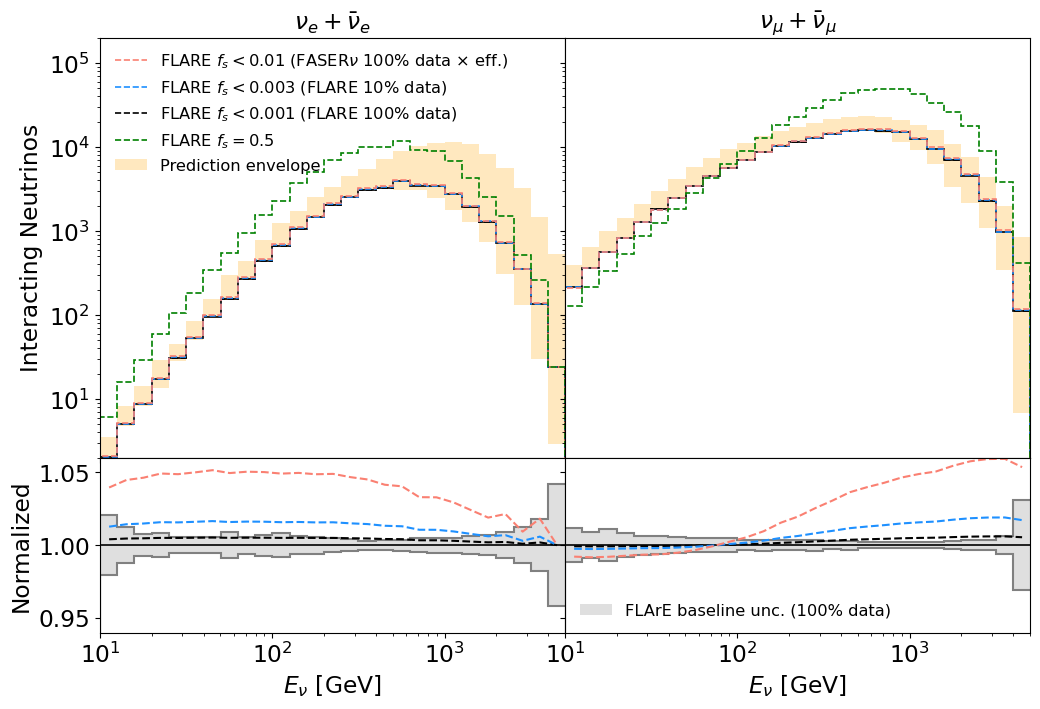

In [47]:
#Redefine lambdazeros to SIBYLL
lambdazeros_orig=deepcopy(lambdazeros)
lambdazeros=singleGenLambdaMatrix('SIBYLL')

NRbins = 3
infobaseline = info3SIBYLL
fig = plt.figure(figsize=(15,7))
radNstr = '_rad'+str(NRbins)
detector='FLARE'
filename='plots/'+codename+'_enhanced_strangeness_'+detector+radNstr+'.pdf'

#setup figure
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'small'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams.update({'legend.loc':'upper left'})
matplotlib.rcParams['text.usetex'] = False
ax11 = fig.add_axes([0.06, 0.35, 0.31, 0.60], xticklabels=[], )
ax12 = fig.add_axes([0.37, 0.35, 0.31, 0.60], xticklabels=[], yticklabels=[],)
ax21 = fig.add_axes([0.06, 0.10, 0.31, 0.25], )
ax22 = fig.add_axes([0.37, 0.10, 0.31, 0.25], yticklabels=[], )
axes = np.array([[ax11,ax12],[ax21,ax22]])
vpidstrs=[str(vpidkey) for vpidkey in list(vpids.keys())]

detcols={}
detcols['FLARE']='black'
detcols['FLARE_10p']='dodgerblue'
detcols['FASERv']='salmon'

#Value(s) of f_s to plot against the baseline model
studyfs   = fs3constraint
studyfs_1 = fs3constraint_10p
studyfs_2 = fs3constraint_FASERv
    
#Extract information from baseline using 1 radial bin (for upper panel) but 3 radial bin constraints for fs cases
baseline1     = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
baseline1fs   = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=studyfs)    
baseline1fs_1 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=studyfs_1)    
baseline1fs_2 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=studyfs_2)    
base_entries1={}
base_entries1fs={}
base_entries1fs_1={}
base_entries1fs_2={}
ebins = np.array(baseline["12"]['ebins'])
ecenters = (ebins[1:]+ebins[:-1])/2
nmax = 1
for ivpid,vpid in enumerate(vpidstrs):
    if ivpid>1: continue
    #1 R bin
    entries1     = np.array(baseline1[    vpid]['n_int']).T[0]
    entries1fs   = np.array(baseline1fs[  vpid]['n_int']).T[0]
    entries1fs_1 = np.array(baseline1fs_1[vpid]['n_int']).T[0]
    entries1fs_2 = np.array(baseline1fs_2[vpid]['n_int']).T[0]
    base_entries1[    vpid] = entries1
    base_entries1fs[  vpid] = entries1fs
    base_entries1fs_1[vpid] = entries1fs_1
    base_entries1fs_2[vpid] = entries1fs_2
    if max(entries)>nmax: nmax=max(entries)
    #For the upper panel, plot 1 R bin case i.e. total distribution
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1, bins=ebins, histtype='step',\
                                color='black', ls='solid', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_BL_nofs_'+vpid,\
             mode       = 'histo')
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1fs, bins=ebins, histtype='step',\
                                color=detcols['FLARE'], ls='dashed', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FLARE_BL_fs_'+vpid,\
             mode       = 'histo')
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1fs_1, bins=ebins, histtype='step',\
                                color=detcols['FLARE_10p'],ls='dashed', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FLARE_10p_constr_BL_fs_1_'+vpid,\
             mode       = 'histo')
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entries1fs_2, bins=ebins, histtype='step',\
                                color=detcols['FASERv'], ls='dashed', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = 'FASERv_constr_BL_fs_1_'+vpid,\
             mode       = 'histo')
    axes[1,ivpid].hist(x=ecenters, bins=ebins, histtype='step', color='black', ls='solid', lw=1.2)
    axes[0,ivpid].plot(-1,1, color='black',       ls='solid',  lw=1.2)                

#Plot f_s=0.5 for reference -- upper panel only, so this is with 1 radial bin
modelfs05 = model(detector=detector,radN='_rad1',lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.5)    
for ivpid,vpid in enumerate(vpidstrs):
    if ivpid>1: continue
    entriesfs05 = np.array(modelfs05[vpid]['n_int']).T[0]
    plotTest(axes[0,ivpid].hist(x=ecenters, weights=entriesfs05, bins=ebins, histtype='step',\
                       color='green',ls='dashed', lw=1.2),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_fs05_'+vpid,\
             mode       = 'histo')

#Compute uncertainty for 3 R bins
uncertaintyN = [0.0 for _ in list(vpids.keys())]
valuesN, vectorsN = linalg.eig(infobaseline)
baselineN = model(detector=detector,radN=radNstr,lambdamat=deepcopy(lambdazeros),fstat=1.0,fs=0.0)    
base_entriesN={}
for ivpid,vpid in enumerate(vpidstrs):
    if ivpid>1: continue
    #N R bins
    for rbin in range(NRbins):
        entriesN = np.array(baselineN[vpid]['n_int']).T[rbin]
        base_entriesN[vpid] = entriesN
        base_entryN = base_entriesN[vpid]
        if rbin==0:
            base_entry_sumN = base_entryN
        else:
            base_entry_sumN = np.add(base_entry_sumN, base_entryN)
        for valueN, vectorN in zip(valuesN, vectorsN.T):
            pointN = vectorN / np.sqrt(valueN)
            lambdavarsN = [pointN[sum([Ngp[m]-1 for m in range(n)]):sum([Ngp[m]-1 for m in range(n+1)])] for n in range(Nptypes)]
            lambdavarsN = [np.add(lambdavarsN[i],lambdazeros[i]) for i in range(len(lambdavarsN))]
            variedN = model(detector=detector, radN='_rad'+str(NRbins), lambdamat=lambdavarsN, fs=0.0)
            entryN = np.array(variedN[vpid]['n_int']).T[rbin]
            uncertaintyN[ivpid] += (entryN - base_entryN)**2
    uncertaintyN[ivpid] = np.sqrt(uncertaintyN[ivpid])
    wgtpN = 1 + uncertaintyN[ivpid] / base_entry_sumN
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtpN,bins=ebins,\
                                histtype='step',color='gray',ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad3_unc_fs_'+vpid+'_wgtpN',\
             mode       = 'histo')
    wgtmN = 1-uncertaintyN[ivpid]/base_entry_sumN                 
    plotTest(axes[1,ivpid].hist(x=ecenters,weights=wgtmN,bins=ebins,\
                                histtype='step',color='gray',ls='solid',lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag    = detector+'_rad3_unc_fs_'+vpid+'_wgtmN',\
             mode       = 'histo')
    axes[1,ivpid].bar(x=ebins[:-1],\
                      height=np.add(wgtpN,np.multiply(-1,wgtmN)),\
                      bottom=wgtmN,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='gray',\
                      alpha=0.25, zorder=-1)
    
#Plot ratios to lower panel using 1 radial bin info (in order to correspond to upper panel)
for ivpid,vpid in enumerate(vpidstrs):
    if ivpid>1: continue
    base_entry1     = base_entries1[vpid]
    base_entry1fs   = base_entries1fs[vpid]
    base_entry1fs_1 = base_entries1fs_1[vpid]
    base_entry1fs_2 = base_entries1fs_2[vpid]
    ratio = base_entry1fs/base_entry1
    plotTest(axes[1,ivpid].plot(ecenters,ratio,color=detcols['FLARE'], ls='dashed', lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_fs_ratio_'+vpid,\
             mode = 'plot')
    ratio_1 = base_entry1fs_1/base_entry1                
    plotTest(axes[1,ivpid].plot(ecenters,ratio_1,color=detcols['FLARE_10p'], ls='dashed', lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FLARE_10p_fs_ratio_'+vpid,\
             mode = 'plot')
    ratio_2 = base_entry1fs_2/base_entry1
    plotTest(axes[1,ivpid].plot(ecenters,ratio_2,color=detcols['FASERv'], ls='dashed', lw=1.5),\
             testsubdir = 'flux-fit-main',\
             testtag = 'FASERv_fs_ratio_'+vpid,\
             mode = 'plot')

#Fetch envelope of input predictions
lambdazeros_tmp=deepcopy(lambdazeros)
lambdazeros=deepcopy(lambdazeros_orig)
lambdagens1=[] #lambdagens[i] will contain the lambdamatrix for retrieving only the ith generator
#0th gen special case 
lambdagens1.append([np.multiply(-1.,np.ones(n-1)) for n in Ngp])
#Init i>0 cases to all-0 baseline. N.B. #cases depends on total #[generator pairs]=Ng,...
for i in range(Ng-1):  #...hence Ng-1 does NOT refer to particle type specific #lambdas here
    lambdagens1.append(deepcopy(lambdazeros_orig))
#Set the relevant element of each i>0 case lambdamatrix to 1 to pick a single generator
for j in range(Nptypes):
    for i in range(Ngp[j]-1):
        lambdagens1[i+1][j][i] = 1
#Store the "model" objects corresponding to above generator-specific lambdamatrices
genmodels1=[]
for lgenspec in lambdagens1:
    genmodels1.append(model(detector=detector,radN='_rad1',lambdamat=lgenspec))
#Fetch model result projection, store different nu flavor contributions to "entries"
for ivpid,vpid in enumerate(vpidstrs):  #Handle & plot
    entries1=[]
    if ivpid>1: continue
    for igm,genmodel in enumerate(genmodels1):
        entries1.append(np.array(genmodel[vpid]['n_int']).T[0])
    entrieslo = [min([entry[i] for entry in entries1]) for i in range(len(entries1[0]))]
    entrieshi = [max([entry[i] for entry in entries1]) for i in range(len(entries1[0]))]
    axes[0,ivpid].bar(x=ebins[:-1],\
                      height=np.add(entrieshi,np.multiply(-1,entrieslo)),\
                      bottom=entrieslo,\
                      width=np.diff(ebins),\
                      align='edge', linewidth=0, color='orange',\
                      alpha=0.25, zorder=-1)
lambdazeros=deepcopy(lambdazeros_tmp)
    
#Plotstyle setup
vpidlabels = {"12": r"$\nu_e+\bar\nu_e$", "14": r"$\nu_\mu+\bar\nu_\mu$", "16": r"$\nu_\tau+\bar\nu_\tau$"}
for ivpid,vpid in enumerate(vpidstrs):
    if ivpid>1: continue
    axes[1,ivpid].set_xlabel(r'$E_\nu$ [GeV]')
    if ivpid==0: axes[0,ivpid].set_ylabel(r'Interacting Neutrinos')
    if ivpid==0: axes[1,ivpid].set_ylabel("Normalized")
    axes[0,ivpid].set_xscale("log")
    axes[1,ivpid].set_xscale("log")
    axes[0,ivpid].set_yscale("log")
    axes[1,ivpid].set_yscale("linear")
    axes[0,ivpid].set_xlim(10,5000)
    axes[1,ivpid].set_xlim(10,5000)
    axes[0,ivpid].set_ylim(2,2e5)
    axes[1,ivpid].set_ylim(0.94,1.06)
    axes[0,ivpid].set_xticklabels([])
    if ivpid>0: axes[0,ivpid].set_yticklabels([])
    if ivpid>0: axes[1,ivpid].set_yticklabels([])
    axes[0,ivpid].set_title(vpidlabels[vpid])

#Legend    
Ndec=1e3  #Round fs constraints to 4 decimals
axes[0,0].plot(-1,1, color=detcols['FASERv'],    ls='dashed', lw=1.2,label=r'FLARE $f_s<$'+str(round(Ndec*studyfs_2)/Ndec)+r' (FASER$\nu$ 100% data $\times$ eff.)')                
axes[0,0].plot(-1,1, color=detcols['FLARE_10p'], ls='dashed', lw=1.2,label=r'FLARE $f_s<$'+str(round(Ndec*studyfs_1)/Ndec)+' (FLARE 10% data)')                
axes[0,0].plot(-1,1, color=detcols['FLARE'],     ls='dashed', lw=1.2,label=r'FLARE $f_s<$'+str(round(Ndec*studyfs  )/Ndec)+' (FLARE 100% data)')                
axes[0,0].bar(-1,1,linewidth=0, color='orange', alpha=0.25, zorder=-1, label='Prediction envelope')
axes[0,0].plot(-1,1, color='green', ls='dashed', lw=1.2, label=r'FLARE $f_s=0.5$')                
axes[0,0].legend(frameon=False)
matplotlib.rcParams.update({'legend.loc':'lower left'})
axes[1,1].bar(-1,1,linewidth=0, color='gray',  alpha=0.25, zorder=-1, label='FLArE baseline unc. (100% data)')
axes[1,0].legend(frameon=False)
axes[1,1].legend(frameon=False)

#finalize figure
if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

#Reset lambdazeros (always do this at the end of a cell w/ non-std lambdazeros, in case things are moved around)
lambdazeros=deepcopy(lambdazeros_orig)

### Set fs baseline to a non-zero value

In [48]:
fs_discovery={}

for genfs in ['SIBYLL', 'EPOSLHC', 'QGSJET']:
    #Redefine lambdazeros to chosen generator
    lambdazeros_orig = deepcopy(lambdazeros)
    lambdazeros = singleGenLambdaMatrix(genfs)
    radNstr = '_rad3'
    detStr = 'FASERv'
    
    #Redefine baseline fs
    fszero_orig=fszero
    fszlast=[]
    fscons=[]
    
    for fsz in np.linspace(0,0.99,100):
        fszero = fsz #Set global baseline fszero to loop stepper value
        infomat = get_information(detector=detStr, radN =radNstr,fstat=1.0,usefs=True)
    
        #Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
        #Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
        infoprof = deepcopy(infomat)
        infopart = deepcopy(infomat)
        for i in range(len(infomat)-1):
            infoprof = profile(infoprof, 0)
            infopart = dimDel( infopart, 0)
        fscons.append(1.0/np.sqrt(infoprof[0][0]))
        fszlast.append(fsz)
        fscheck=round(fsz*100)/100
        fslim=round(fscons[-1]*5*100)/100
        if fscheck>fslim:
            fscons=fscons[:-1]
            fszlast=fszlast[:-1]
            break
        elif fscheck==fslim: 
            break
    
    #Print resulting constraints:
    print('Using '+genfs)
    print('Baseline f_s =  ' + str(fszlast[-1]) + \
          ', constrained f_s = ' + str(fscons[-1]) + ' (' + detStr + ', 1 sigma), ' + \
          'constr*5 = ' + str(5.0*fscons[-1]))
    fs_discovery[genfs] = fszlast[-1]
    
    #Reset to defaults
    fszero = fszero_orig
    lambdazeros = deepcopy(lambdazeros_orig)

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
Using 

### Alternative baseline fs studies with cuts on lepton flavor and $E_{\nu_e}$

In [49]:
fs_discovery_cuts={}

for genfs in ['SIBYLL', 'EPOSLHC', 'QGSJET']:
    #Redefine lambdazeros to the chosen prediction
    lambdazeros_orig = deepcopy(lambdazeros)
    lambdazeros = singleGenLambdaMatrix(genfs)
    radNstr = '_rad3'
    detStr = 'FASERv'
    
    #Disable tau neutrinos
    vpids_orig = deepcopy(vpids)
    vpids = {12:[],14:[]}
    
    #Redefine baseline fs
    fszero_orig=fszero
    fszeros = [0.001, 0.005, 0.01, 0.05, 0.056, 0.06, 0.07, 0.10, 0.18, 0.19, 0.15, 0.20, 0.25, 0.27, 0.28, 0.30, 0.31, 0.35, 0.40, 0.45, 0.5]
    fscons = []
    
    for fsz in fszeros:
        fszero = fsz
        infomat = get_information(detector=detStr,radN=radNstr,fstat=1.0,usefs=True,E_nu_e_max=300.0)
            
        #Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
        #Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
        infoprof = deepcopy(infomat)
        infopart = deepcopy(infomat)
        for i in range(len(infomat)-1):
            infoprof = profile(infoprof, 0)
            infopart = dimDel( infopart, 0)
        fscons.append(1.0/np.sqrt(infoprof[0][0]))
        fszlast.append(fsz)
        fscheck=round(fsz*100)/100
        fslim=round(fscons[-1]*5*100)/100
        if fscheck>fslim:
            fscons=fscons[:-1]
            fszlast=fszlast[:-1]
            break
        elif fscheck==fslim: 
            break
    
    #Print resulting constraints:
    print('Using '+genfs)
    print('Baseline f_s =  ' + str(fszlast[-1]) + \
          ', constrained f_s = ' + str(fscons[-1]) + ' (' + detStr + ', 1 sigma), ' + \
          'constr*5 = ' + str(5.0*fscons[-1]))
    fs_discovery_cuts[genfs] = fszlast[-1]
    
    #Reset to defaults
    vpids = deepcopy(vpids_orig)
    fszero = fszero_orig
    lambdazeros = deepcopy(lambdazeros_orig)

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimen

### Comparison of fs constraints

All constraints at 2.0 sigma:
 FLARE (SIBYLL) : 0.002017171129786165
 FLARE (SIBYLL, 10% data) : 0.006388868488185342
 FASER$\nu$ (SIBYLL, eff. cuts): 0.01993300710286783
 FASER$\nu$ (EPOSLHC, eff. cuts): 0.026654169756401568
 FASER$\nu$ (QGSJET, eff. cuts): 0.024937535534885247
Saved  plots/cSBYAM_lSDQEP_fs_summary_rad3.pdf


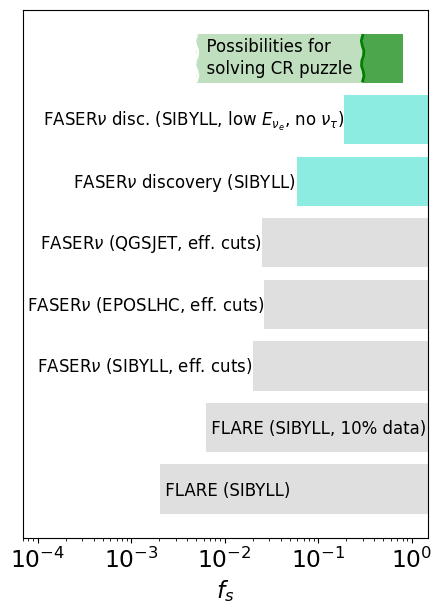

In [50]:
filename='plots/'+codename+'_fs_summary_rad3.pdf'

#setup figure
fig = plt.figure(figsize=(4.5,6.0))
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'small'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams.update({'legend.loc':'upper left'})
matplotlib.rcParams['text.usetex'] = False
ax = fig.add_axes([0.06, 0.11, 0.90, 0.88], xticklabels=[], )
ax.set_xscale("log")
ax.set_yticks([])

#Constrained values, transformed to N sigma
sigmas=2.0  #N in^
constraints = {}
constraints[r' FLARE (SIBYLL) '                ] = fs3constraint*sigmas
constraints[r' FLARE (SIBYLL, 10% data) '      ] = fs3constraint_10p*sigmas
constraints[r' FASER$\nu$ (SIBYLL, eff. cuts)' ] = fs3constraint_FASERv*sigmas
constraints[r' FASER$\nu$ (EPOSLHC, eff. cuts)'] = 0.013327084878200784*sigmas
constraints[r' FASER$\nu$ (QGSJET, eff. cuts)' ] = 0.012468767767442624*sigmas
print('All constraints at '+str(sigmas)+' sigma:')
for key in list(constraints.keys()) : print(key+": "+str(constraints[key]))

#Discovery limits
discoveries = {}
discoveries[r' FASER$\nu$ discovery (SIBYLL) '       ] = fs_discovery['SIBYLL']
discoveries[r' FASER$\nu$ disc. (SIBYLL, low $E_{\nu_e}$, no $\nu_\tau$)' ] = fs_discovery_cuts['SIBYLL']

cbins = range(len(constraints)+1)
dbins = [i+len(cbins)-1 for i in range(len(discoveries)+1)]
constrvals = np.array(list(constraints.values()))
discovals  = np.array(list(discoveries.values()))
ax.barh(y=cbins[:-1],\
        width=np.add(constrvals,1e2),\
        left=constrvals,\
        align='edge',\
        linewidth=0.5, color='gray',\
        alpha=0.25, zorder=-1)
ax.barh(y=dbins[:-1],\
        width=np.add(discovals,1e2),\
        left=discovals,\
        align='edge',\
        linewidth=0.5, color='turquoise',\
        alpha=0.6, zorder=-1)
ax.barh(y=[len(cbins)+len(dbins)-2 for i in range(1)],\
        width=[0.5],\
        left=[0.3],\
        align='edge',\
        linewidth=0.5, color='green',\
        alpha=0.7, zorder=-1)
possibilitiesLO = 0.005
ax.barh(y=[len(cbins)+len(dbins)-2 for i in range(1)],\
        width=[0.3],\
        left=[possibilitiesLO],\
        align='edge',\
        linewidth=0.5, color='green',\
        alpha=0.25, zorder=-1)

#Write names next to the histo bars
matplotlib.rcParams.update({'font.size': 12})
switchTextSideAt = 0.01
for i,name in enumerate(list(constraints.keys())):
    xcrd = constrvals[i]
    align = 'left'
    if xcrd > switchTextSideAt:
        align = 'right'
    plt.text(xcrd, cbins[i]+0.3, name, rotation=0., horizontalalignment=align)
for i,name in enumerate(list(discoveries.keys())):
    xcrd = discovals[i]
    align = 'left'
    if xcrd > switchTextSideAt:
        align = 'right'
    plt.text(xcrd, dbins[i]+0.3, name, rotation=0., horizontalalignment=align)
plt.text(possibilitiesLO, dbins[-1]+0.5, r'  Possibilities for ', rotation=0, horizontalalignment='left')
plt.text(possibilitiesLO, dbins[-1]+0.15, r'  solving CR puzzle ', rotation=0, horizontalalignment='left')

#Plot a sin curve to illustrate CR puzzle region lower limit ambiguity
N_sin = 10
y_sin = np.linspace(dbins[-1]+0.03,dbins[-1]+0.77,N_sin)
x_sin = np.add(0.3,np.multiply(0.01,np.sin(np.linspace(0.0,4*math.pi,N_sin))))
plt.plot(x_sin,y_sin,color='green',lw=2)
#Also for the lower limit of the light-shaded band
y_sin = np.linspace(dbins[-1]+0.03,dbins[-1]+0.77,N_sin)
x_sin = np.add(possibilitiesLO,np.multiply(2e-4,np.sin(np.linspace(0.0,4*math.pi,N_sin))))
plt.plot(x_sin,y_sin,color='white',lw=2)


ax.set_xlabel(r'$f_s$')
ax.set_xlim(7e-5,1.5)

if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()

### Same as above but also including low-E cut for electron neutrinos at FASERv

In [51]:
fs_discovery_cuts={}

for genfs in ['SIBYLL', 'EPOSLHC', 'QGSJET']:
    #Redefine lambdazeros to the chosen prediction
    lambdazeros_orig = deepcopy(lambdazeros)
    lambdazeros = singleGenLambdaMatrix(genfs)
    radNstr = '_rad3'
    detStr = 'FASERv'
    
    #Disable tau neutrinos
    vpids_orig = deepcopy(vpids)
    vpids = {12:[],14:[]}
    
    #Redefine baseline fs
    fszero_orig=fszero
    fszeros = [0.001, 0.005, 0.01, 0.05, 0.056, 0.06, 0.07, 0.10, 0.18, 0.19, 0.15, 0.20, 0.25, 0.27, 0.28, 0.30, 0.31, 0.35, 0.40, 0.45, 0.5]
    fscons = []
    
    for fsz in fszeros:
        fszero = fsz
        infomat = get_information(detector=detStr,radN=radNstr,fstat=1.0,usefs=True,E_nu_e_min=100.0,E_nu_e_max=300.0)
            
        #Profile all lambda parameters, one at a time. The last entry in info matrix corresponds to fs.
        #Simultaneously, remove rows and columns from infopart to provide a projection compared to the profiled result
        infoprof = deepcopy(infomat)
        infopart = deepcopy(infomat)
        for i in range(len(infomat)-1):
            infoprof = profile(infoprof, 0)
            infopart = dimDel( infopart, 0)
        fscons.append(1.0/np.sqrt(infoprof[0][0]))
        fszlast.append(fsz)
        fscheck=round(fsz*100)/100
        fslim=round(fscons[-1]*5*100)/100
        if fscheck>fslim:
            fscons=fscons[:-1]
            fszlast=fszlast[:-1]
            break
        elif fscheck==fslim: 
            break
    
    #Print resulting constraints:
    print('Using '+genfs)
    print('Baseline f_s =  ' + str(fszlast[-1]) + \
          ', constrained f_s = ' + str(fscons[-1]) + ' (' + detStr + ', 1 sigma), ' + \
          'constr*5 = ' + str(5.0*fscons[-1]))
    fs_discovery_cuts[genfs] = fszlast[-1]
    
    #Reset to defaults
    vpids = deepcopy(vpids_orig)
    fszero = fszero_orig
    lambdazeros = deepcopy(lambdazeros_orig)

#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimensions =  13
#cpu =  8 , #calculations/cpu =  11
Computing  88 / 91  entries using multiprocessing
Computing remaining 3 entries naively
#dimen

All constraints at 2.0 sigma:
 FLARE (SIBYLL) : 0.002017171129786165
 FLARE (SIBYLL, 10% data) : 0.006388868488185342
 FASER$\nu$ (SIBYLL, eff. cuts): 0.01993300710286783
 FASER$\nu$ (EPOSLHC, eff. cuts): 0.026654169756401568
 FASER$\nu$ (QGSJET, eff. cuts): 0.024937535534885247
Saved  plots/cSBYAM_lSDQEP_Enue100-300_fs_summary_rad3.pdf


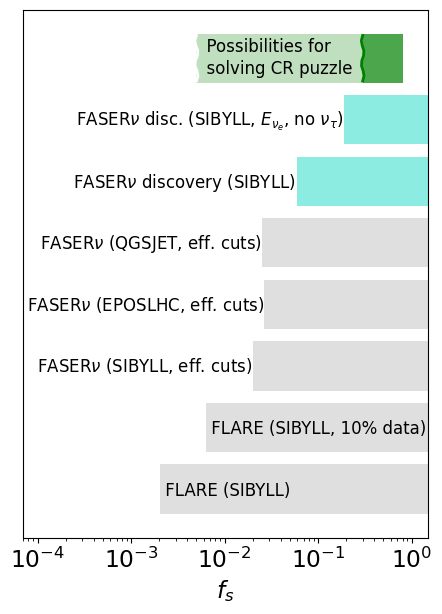

In [52]:
filename='plots/'+codename+'_Enue100-300_fs_summary_rad3.pdf'

#setup figure
fig = plt.figure(figsize=(4.5,6.0))
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 'small'})
matplotlib.rcParams.update({'axes.labelsize': 'large'})
matplotlib.rcParams.update({'axes.titlesize':'large'})
matplotlib.rcParams.update({'xtick.labelsize':'large'})
matplotlib.rcParams.update({'ytick.labelsize':'large'})
matplotlib.rcParams.update({'legend.loc':'upper left'})
matplotlib.rcParams['text.usetex'] = False
ax = fig.add_axes([0.06, 0.11, 0.90, 0.88], xticklabels=[], )
ax.set_xscale("log")
ax.set_yticks([])

#Constrained values, transformed to N sigma
sigmas=2.0  #N in^
constraints = {}
constraints[r' FLARE (SIBYLL) '                ] = fs3constraint*sigmas
constraints[r' FLARE (SIBYLL, 10% data) '      ] = fs3constraint_10p*sigmas
constraints[r' FASER$\nu$ (SIBYLL, eff. cuts)' ] = fs3constraint_FASERv*sigmas
constraints[r' FASER$\nu$ (EPOSLHC, eff. cuts)'] = 0.013327084878200784*sigmas
constraints[r' FASER$\nu$ (QGSJET, eff. cuts)' ] = 0.012468767767442624*sigmas
print('All constraints at '+str(sigmas)+' sigma:')
for key in list(constraints.keys()) : print(key+": "+str(constraints[key]))

#Discovery limits
discoveries = {}
discoveries[r' FASER$\nu$ discovery (SIBYLL) '       ] = fs_discovery['SIBYLL']
discoveries[r' FASER$\nu$ disc. (SIBYLL, $E_{\nu_e}$, no $\nu_\tau$)' ] = fs_discovery_cuts['SIBYLL']

cbins = range(len(constraints)+1)
dbins = [i+len(cbins)-1 for i in range(len(discoveries)+1)]
constrvals = np.array(list(constraints.values()))
discovals  = np.array(list(discoveries.values()))
ax.barh(y=cbins[:-1],\
        width=np.add(constrvals,1e2),\
        left=constrvals,\
        align='edge',\
        linewidth=0.5, color='gray',\
        alpha=0.25, zorder=-1)
ax.barh(y=dbins[:-1],\
        width=np.add(discovals,1e2),\
        left=discovals,\
        align='edge',\
        linewidth=0.5, color='turquoise',\
        alpha=0.6, zorder=-1)
ax.barh(y=[len(cbins)+len(dbins)-2 for i in range(1)],\
        width=[0.5],\
        left=[0.3],\
        align='edge',\
        linewidth=0.5, color='green',\
        alpha=0.7, zorder=-1)
possibilitiesLO = 0.005
ax.barh(y=[len(cbins)+len(dbins)-2 for i in range(1)],\
        width=[0.3],\
        left=[possibilitiesLO],\
        align='edge',\
        linewidth=0.5, color='green',\
        alpha=0.25, zorder=-1)

#Write names next to the histo bars
matplotlib.rcParams.update({'font.size': 12})
switchTextSideAt = 0.01
for i,name in enumerate(list(constraints.keys())):
    xcrd = constrvals[i]
    align = 'left'
    if xcrd > switchTextSideAt:
        align = 'right'
    plt.text(xcrd, cbins[i]+0.3, name, rotation=0., horizontalalignment=align)
for i,name in enumerate(list(discoveries.keys())):
    xcrd = discovals[i]
    align = 'left'
    if xcrd > switchTextSideAt:
        align = 'right'
    plt.text(xcrd, dbins[i]+0.3, name, rotation=0., horizontalalignment=align)
plt.text(possibilitiesLO, dbins[-1]+0.5, r'  Possibilities for ', rotation=0, horizontalalignment='left')
plt.text(possibilitiesLO, dbins[-1]+0.15, r'  solving CR puzzle ', rotation=0, horizontalalignment='left')

#Plot a sin curve to illustrate CR puzzle region lower limit ambiguity
N_sin = 10
y_sin = np.linspace(dbins[-1]+0.03,dbins[-1]+0.77,N_sin)
x_sin = np.add(0.3,np.multiply(0.01,np.sin(np.linspace(0.0,4*math.pi,N_sin))))
plt.plot(x_sin,y_sin,color='green',lw=2)
#Also for the lower limit of the light-shaded band
y_sin = np.linspace(dbins[-1]+0.03,dbins[-1]+0.77,N_sin)
x_sin = np.add(possibilitiesLO,np.multiply(2e-4,np.sin(np.linspace(0.0,4*math.pi,N_sin))))
plt.plot(x_sin,y_sin,color='white',lw=2)


ax.set_xlabel(r'$f_s$')
ax.set_xlim(7e-5,1.5)

if filename is not None:
    plt.savefig(filename)
    print('Saved ',filename)
plt.show()